In [1]:
import sys
import torch
from torch.nn import MSELoss
import numpy as np
from tqdm import tqdm
from torch.autograd import Variable
from torch_geometric_temporal.signal import temporal_signal_split
sys.path.append('../../model/geometric_temporal/')
sys.path.append('../../dataset/')
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
from recurrent import LSTMGCNModel
from gdelt_dataset import GDELTDatasetLoader
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
seed = torch.random.manual_seed(52)

In [3]:
loader = GDELTDatasetLoader('../../data/dataset/gdelt_data_2.pkl', 1000)
dataset = loader.get_dataset()

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [5]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [6]:
from tqdm import tqdm

model = RecurrentGCN(node_features = 7)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

model.train()

for epoch in tqdm(range(100)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        max_x = torch.add(torch.max(torch.nan_to_num(snapshot.x), 0).values, 1)
        X = torch.div(snapshot.x, max_x)
        #X = torch.clamp(X, 10e-5, 10e3)
        X = torch.nan_to_num(X)
        
        max_w = torch.add(torch.max(torch.nan_to_num(snapshot.edge_attr), 0).values, 1)
        W = torch.div(snapshot.edge_attr, max_w)
        #W = torch.clamp(W, 10e-5, 100)
        W = torch.nan_to_num(W)
        
        y_hat = model(X, snapshot.edge_index, W)
        y_hat = torch.sum(torch.mul(y_hat[snapshot.edge_index[0]], y_hat[snapshot.edge_index[1]]), 1)
        
#         y_hat = torch.mm(y_hat, y_hat.T)
        y_true = torch.diagonal(snapshot.y[snapshot.edge_index[0]][:, snapshot.edge_index[1]])
        cost = cost + torch.mean((y_hat-y_true)**2)
    cost = cost / (time+1)
    print(f'Cost: {cost}')
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Cost: 15.09592056274414


  1%|▊                                                                                 | 1/100 [00:03<05:13,  3.17s/it]

Cost: 15.061275482177734


  2%|█▋                                                                                | 2/100 [00:06<05:15,  3.22s/it]

Cost: 15.0224609375


  3%|██▍                                                                               | 3/100 [00:09<05:11,  3.21s/it]

Cost: 14.978707313537598


  4%|███▎                                                                              | 4/100 [00:12<05:12,  3.26s/it]

Cost: 14.929117202758789


  5%|████                                                                              | 5/100 [00:16<05:07,  3.24s/it]

Cost: 14.872442245483398


  6%|████▉                                                                             | 6/100 [00:19<05:07,  3.27s/it]

Cost: 14.8082275390625


  7%|█████▋                                                                            | 7/100 [00:23<05:13,  3.38s/it]

Cost: 14.735918045043945


  8%|██████▌                                                                           | 8/100 [00:27<05:33,  3.62s/it]

Cost: 14.654793739318848


  9%|███████▍                                                                          | 9/100 [00:30<05:27,  3.60s/it]

Cost: 14.563728332519531


 10%|████████                                                                         | 10/100 [00:34<05:22,  3.59s/it]

Cost: 14.461198806762695


 11%|████████▉                                                                        | 11/100 [00:37<05:18,  3.58s/it]

Cost: 14.345383644104004


 12%|█████████▋                                                                       | 12/100 [00:41<05:14,  3.57s/it]

Cost: 14.21432876586914


 13%|██████████▌                                                                      | 13/100 [00:44<05:09,  3.56s/it]

Cost: 14.066407203674316


 14%|███████████▎                                                                     | 14/100 [00:48<05:06,  3.56s/it]

Cost: 13.900589942932129


 15%|████████████▏                                                                    | 15/100 [00:52<05:02,  3.56s/it]

Cost: 13.715614318847656


 16%|████████████▉                                                                    | 16/100 [00:55<04:59,  3.56s/it]

Cost: 13.511087417602539


 17%|█████████████▊                                                                   | 17/100 [00:59<04:55,  3.56s/it]

Cost: 13.286332130432129


 18%|██████████████▌                                                                  | 18/100 [01:02<04:52,  3.56s/it]

Cost: 13.041291236877441


 19%|███████████████▍                                                                 | 19/100 [01:06<04:51,  3.60s/it]

Cost: 12.77599811553955


 20%|████████████████▏                                                                | 20/100 [01:10<04:47,  3.59s/it]

Cost: 12.493023872375488


 21%|█████████████████                                                                | 21/100 [01:13<04:44,  3.60s/it]

Cost: 12.194282531738281


 22%|█████████████████▊                                                               | 22/100 [01:17<04:39,  3.58s/it]

Cost: 11.886563301086426


 23%|██████████████████▋                                                              | 23/100 [01:21<04:45,  3.71s/it]

Cost: 11.578465461730957


 24%|███████████████████▍                                                             | 24/100 [01:24<04:37,  3.65s/it]

Cost: 11.281471252441406


 25%|████████████████████▎                                                            | 25/100 [01:28<04:38,  3.71s/it]

Cost: 11.009773254394531


 26%|█████████████████████                                                            | 26/100 [01:32<04:42,  3.81s/it]

Cost: 10.781135559082031


 27%|█████████████████████▊                                                           | 27/100 [01:36<04:31,  3.71s/it]

Cost: 10.615521430969238


 28%|██████████████████████▋                                                          | 28/100 [01:39<04:26,  3.71s/it]

Cost: 10.531949043273926


 29%|███████████████████████▍                                                         | 29/100 [01:43<04:23,  3.71s/it]

Cost: 10.541448593139648


 30%|████████████████████████▎                                                        | 30/100 [01:47<04:16,  3.66s/it]

Cost: 10.634714126586914


 31%|█████████████████████████                                                        | 31/100 [01:50<04:10,  3.63s/it]

Cost: 10.771040916442871


 32%|█████████████████████████▉                                                       | 32/100 [01:54<04:05,  3.61s/it]

Cost: 10.891801834106445


 33%|██████████████████████████▋                                                      | 33/100 [01:57<04:00,  3.59s/it]

Cost: 10.953110694885254


 34%|███████████████████████████▌                                                     | 34/100 [02:01<03:55,  3.56s/it]

Cost: 10.943931579589844


 35%|████████████████████████████▎                                                    | 35/100 [02:04<03:50,  3.54s/it]

Cost: 10.879216194152832


 36%|█████████████████████████████▏                                                   | 36/100 [02:08<03:46,  3.53s/it]

Cost: 10.784917831420898


 37%|█████████████████████████████▉                                                   | 37/100 [02:11<03:45,  3.57s/it]

Cost: 10.686385154724121


 38%|██████████████████████████████▊                                                  | 38/100 [02:15<03:42,  3.59s/it]

Cost: 10.602339744567871


 39%|███████████████████████████████▌                                                 | 39/100 [02:19<03:38,  3.58s/it]

Cost: 10.542755126953125


 40%|████████████████████████████████▍                                                | 40/100 [02:22<03:34,  3.57s/it]

Cost: 10.509929656982422


 41%|█████████████████████████████████▏                                               | 41/100 [02:26<03:32,  3.59s/it]

Cost: 10.500519752502441


 42%|██████████████████████████████████                                               | 42/100 [02:29<03:28,  3.60s/it]

Cost: 10.508270263671875


 43%|██████████████████████████████████▊                                              | 43/100 [02:33<03:29,  3.67s/it]

Cost: 10.525901794433594


 44%|███████████████████████████████████▋                                             | 44/100 [02:38<03:40,  3.94s/it]

Cost: 10.546806335449219


 45%|████████████████████████████████████▍                                            | 45/100 [02:41<03:30,  3.82s/it]

Cost: 10.565871238708496


 46%|█████████████████████████████████████▎                                           | 46/100 [02:45<03:23,  3.76s/it]

Cost: 10.579678535461426


 47%|██████████████████████████████████████                                           | 47/100 [02:49<03:16,  3.71s/it]

Cost: 10.586379051208496


 48%|██████████████████████████████████████▉                                          | 48/100 [02:52<03:10,  3.66s/it]

Cost: 10.585478782653809


 49%|███████████████████████████████████████▋                                         | 49/100 [02:56<03:05,  3.63s/it]

Cost: 10.577615737915039


 50%|████████████████████████████████████████▌                                        | 50/100 [02:59<03:00,  3.61s/it]

Cost: 10.564184188842773


 51%|█████████████████████████████████████████▎                                       | 51/100 [03:03<02:55,  3.59s/it]

Cost: 10.547101974487305


 52%|██████████████████████████████████████████                                       | 52/100 [03:06<02:53,  3.62s/it]

Cost: 10.528578758239746


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:10<02:49,  3.61s/it]

Cost: 10.510784149169922


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:14<02:46,  3.62s/it]

Cost: 10.495617866516113


 55%|████████████████████████████████████████████▌                                    | 55/100 [03:17<02:41,  3.60s/it]

Cost: 10.484479904174805


 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:21<02:37,  3.58s/it]

Cost: 10.478046417236328


 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:24<02:32,  3.56s/it]

Cost: 10.476187705993652


 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:28<02:29,  3.55s/it]

Cost: 10.478009223937988


 59%|███████████████████████████████████████████████▊                                 | 59/100 [03:31<02:25,  3.55s/it]

Cost: 10.482028007507324


 60%|████████████████████████████████████████████████▌                                | 60/100 [03:35<02:21,  3.54s/it]

Cost: 10.486522674560547


 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:39<02:20,  3.60s/it]

Cost: 10.4899263381958


 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:43<02:21,  3.73s/it]

Cost: 10.491150856018066


 63%|███████████████████████████████████████████████████                              | 63/100 [03:46<02:16,  3.68s/it]

Cost: 10.489770889282227


 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:50<02:11,  3.65s/it]

Cost: 10.486061096191406


 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:53<02:07,  3.63s/it]

Cost: 10.480769157409668


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:58<02:12,  3.88s/it]

Cost: 10.474869728088379


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:01<02:05,  3.79s/it]

Cost: 10.46933364868164


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:05<02:02,  3.81s/it]

Cost: 10.464832305908203


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:09<01:58,  3.82s/it]

Cost: 10.461755752563477


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:13<01:52,  3.76s/it]

Cost: 10.46008014678955


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [04:16<01:48,  3.75s/it]

Cost: 10.459546089172363


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [04:20<01:43,  3.71s/it]

Cost: 10.45973014831543


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [04:24<01:39,  3.69s/it]

Cost: 10.460156440734863


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [04:28<01:37,  3.76s/it]

Cost: 10.460437774658203


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [04:31<01:34,  3.78s/it]

Cost: 10.460247039794922


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [04:35<01:30,  3.76s/it]

Cost: 10.459464073181152


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [04:39<01:25,  3.74s/it]

Cost: 10.458108901977539


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [04:42<01:21,  3.68s/it]

Cost: 10.456282615661621


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [04:46<01:19,  3.79s/it]

Cost: 10.454218864440918


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [04:50<01:17,  3.85s/it]

Cost: 10.45212173461914


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [04:54<01:11,  3.75s/it]

Cost: 10.450222969055176


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [04:58<01:06,  3.69s/it]

Cost: 10.448652267456055


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [05:01<01:02,  3.66s/it]

Cost: 10.447464942932129


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [05:05<00:58,  3.67s/it]

Cost: 10.446646690368652


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [05:09<00:55,  3.71s/it]

Cost: 10.446094512939453


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [05:12<00:51,  3.68s/it]

Cost: 10.445682525634766


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [05:16<00:47,  3.65s/it]

Cost: 10.445245742797852


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [05:19<00:43,  3.63s/it]

Cost: 10.444711685180664


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [05:23<00:40,  3.66s/it]

Cost: 10.444007873535156


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [05:27<00:36,  3.63s/it]

Cost: 10.443124771118164


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [05:30<00:32,  3.62s/it]

Cost: 10.442120552062988


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [05:34<00:28,  3.60s/it]

Cost: 10.441051483154297


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [05:37<00:25,  3.60s/it]

Cost: 10.439994812011719


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [05:41<00:21,  3.60s/it]

Cost: 10.43902587890625


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [05:45<00:17,  3.60s/it]

Cost: 10.438170433044434


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [05:48<00:14,  3.57s/it]

Cost: 10.437438011169434


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [05:52<00:11,  3.70s/it]

Cost: 10.436811447143555


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [05:56<00:07,  3.76s/it]

Cost: 10.436256408691406


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [06:00<00:03,  3.69s/it]

Cost: 10.4357271194458


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:03<00:00,  3.64s/it]


In [7]:
 with open('../../data/dataset/gdelt_data_2.pkl', 'rb') as f:
    data = pickle.load(f)

In [8]:
country_names = data['node_ids']

In [9]:
data = None

In [10]:
def plot_confusion_matrix(y_hat, y_true):
    x_ticks = []
    for i, j in zip(snapshot.edge_index[0], snapshot.edge_index[1]):
        ci = list(country_names.keys())[list(country_names.values()).index(i)]
        cj = list(country_names.keys())[list(country_names.values()).index(j)]
        x_ticks.append(f'{ci}-{cj}')
    plt.figure(figsize=(30, 5))
    sns.heatmap([y_true.detach().numpy(), y_hat.detach().numpy()], annot=True, yticklabels=['True', 'Predicted'], xticklabels=x_ticks)
    plt.title('Confusion matrix')
    plt.show()

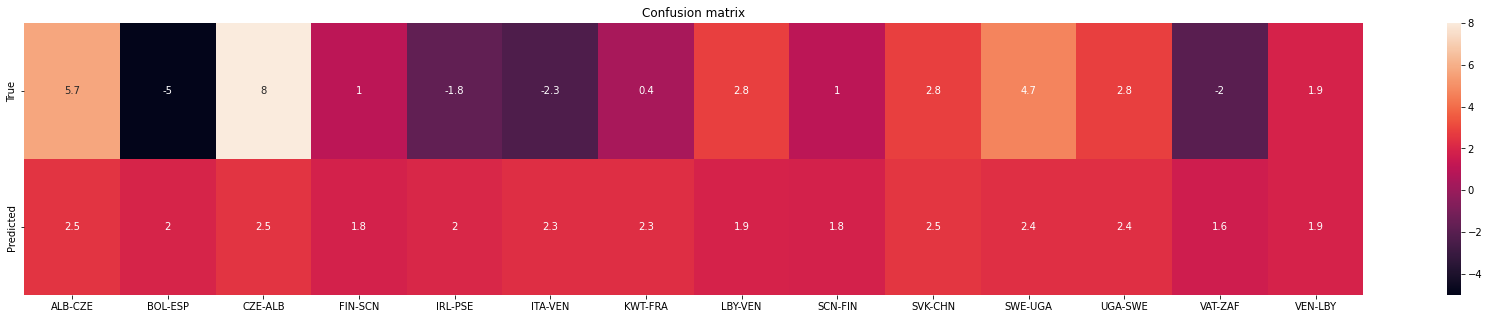

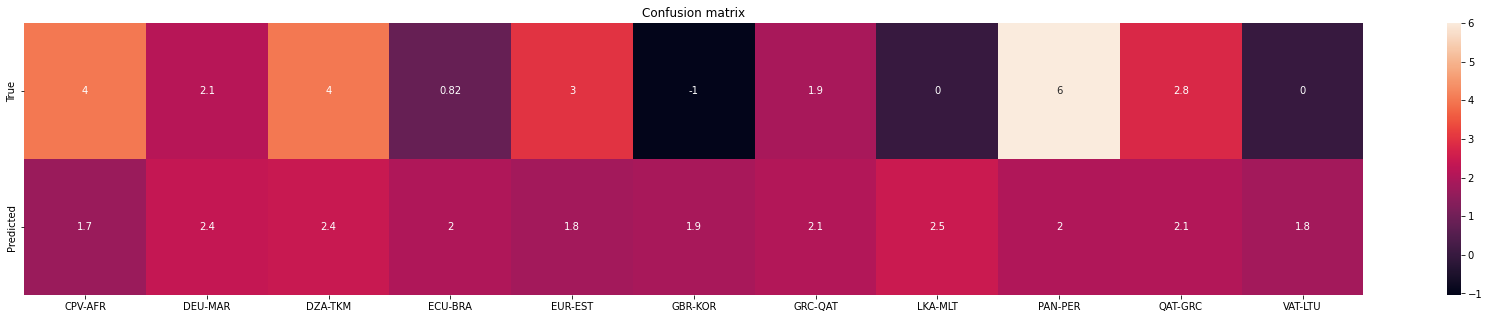

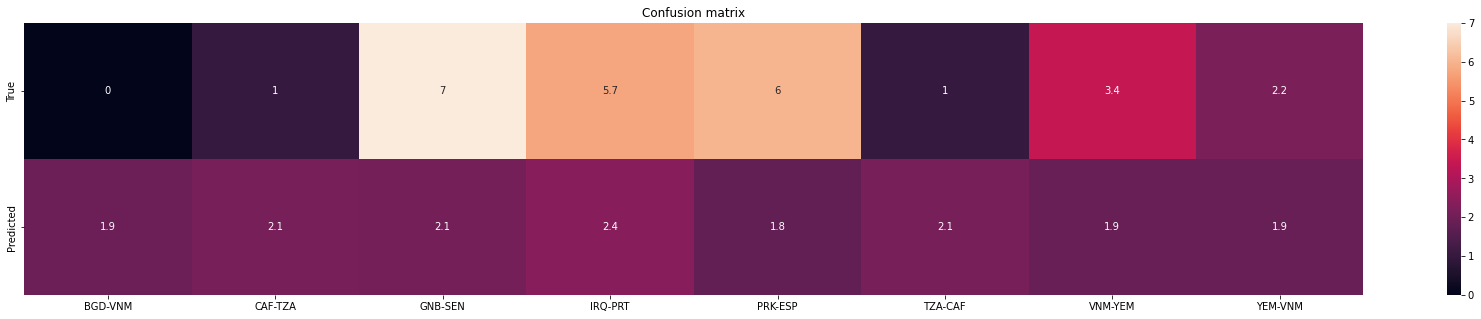

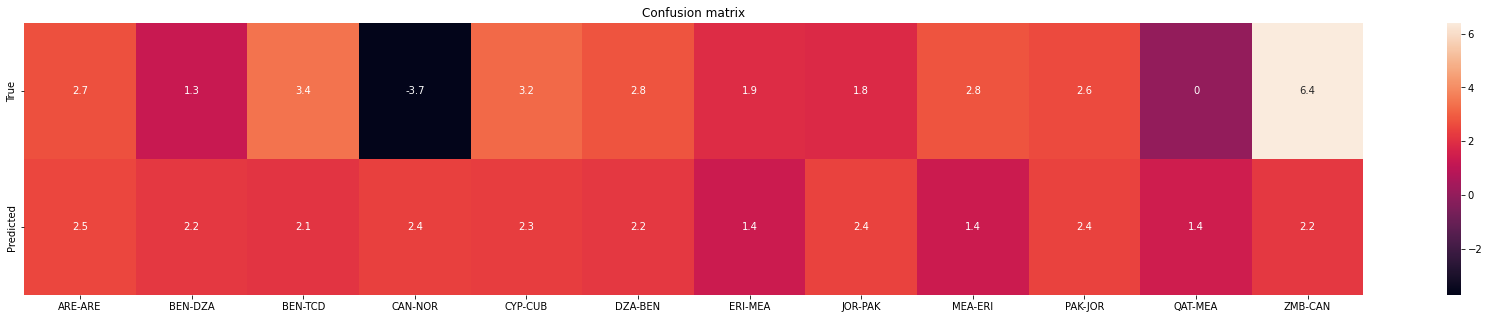

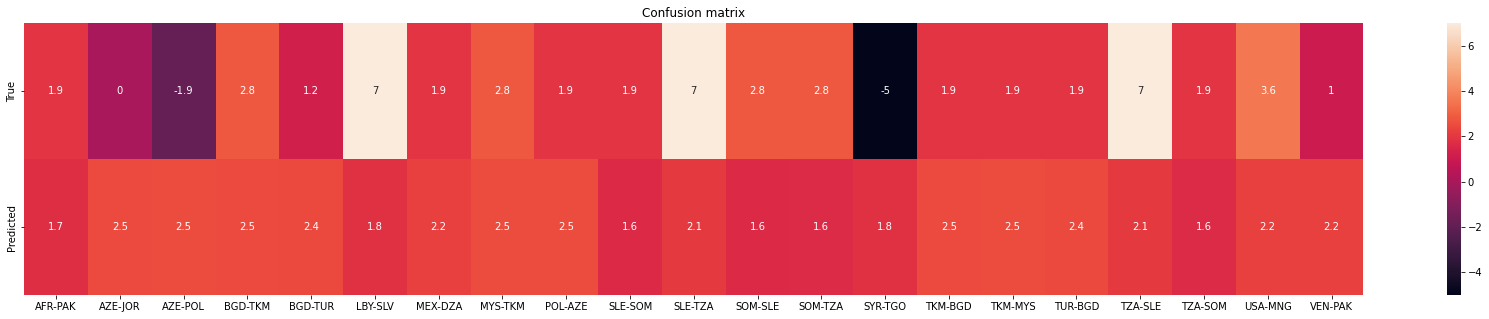

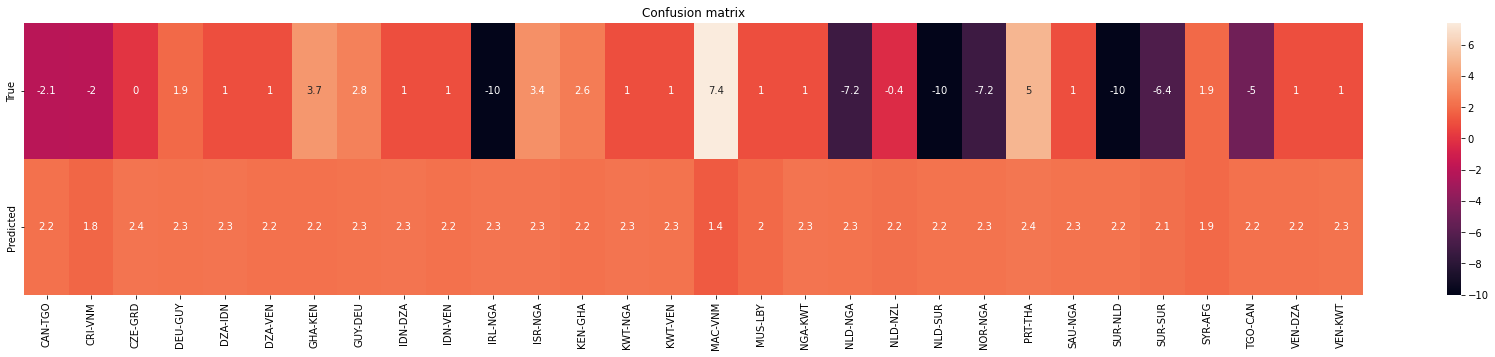

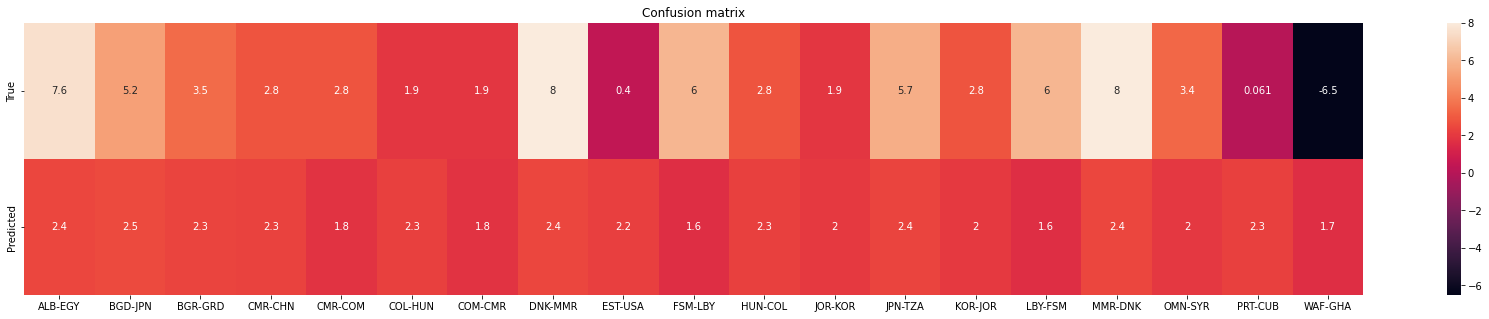

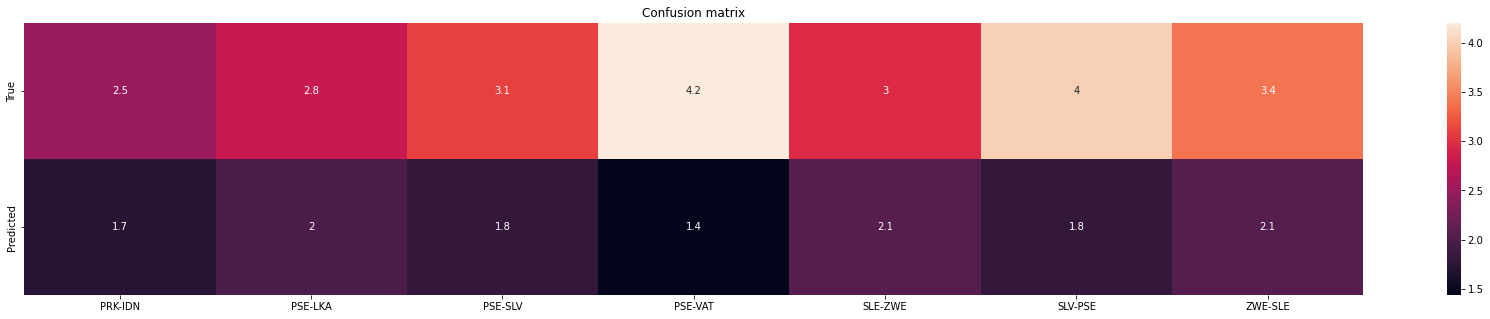

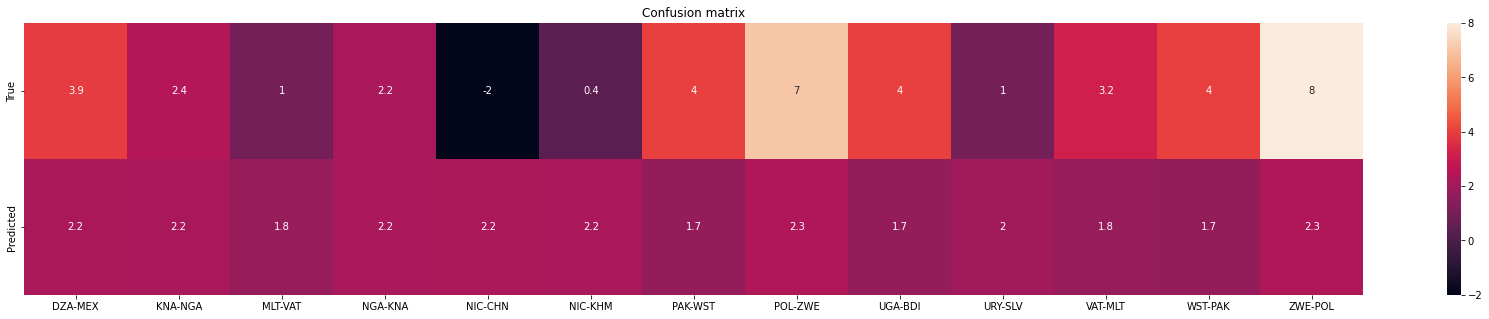

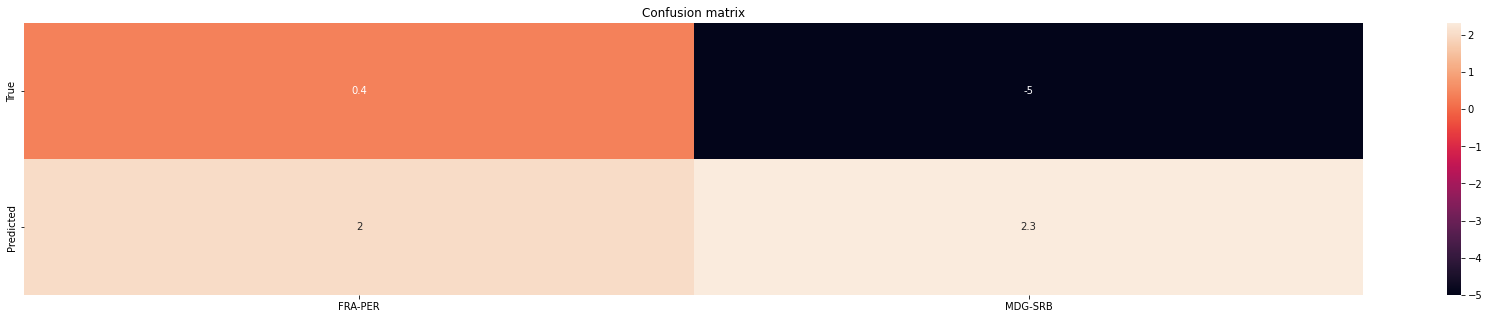

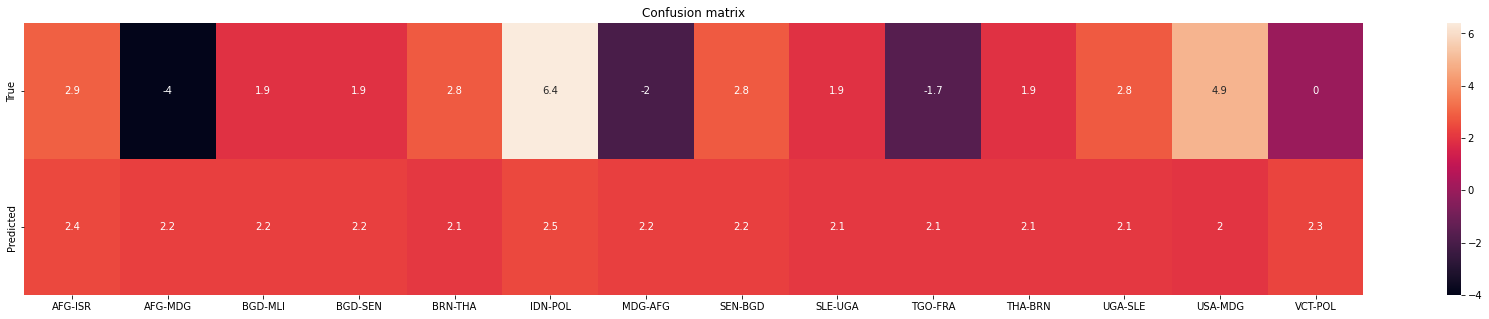

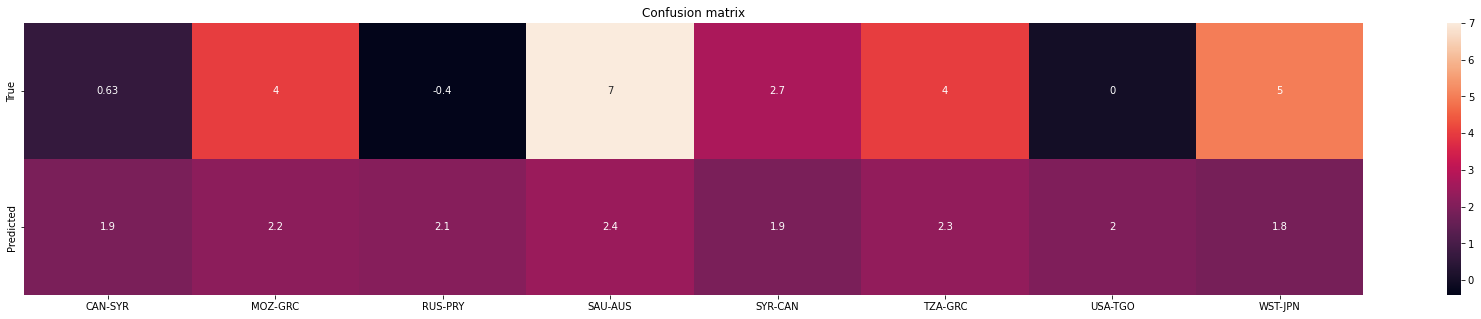

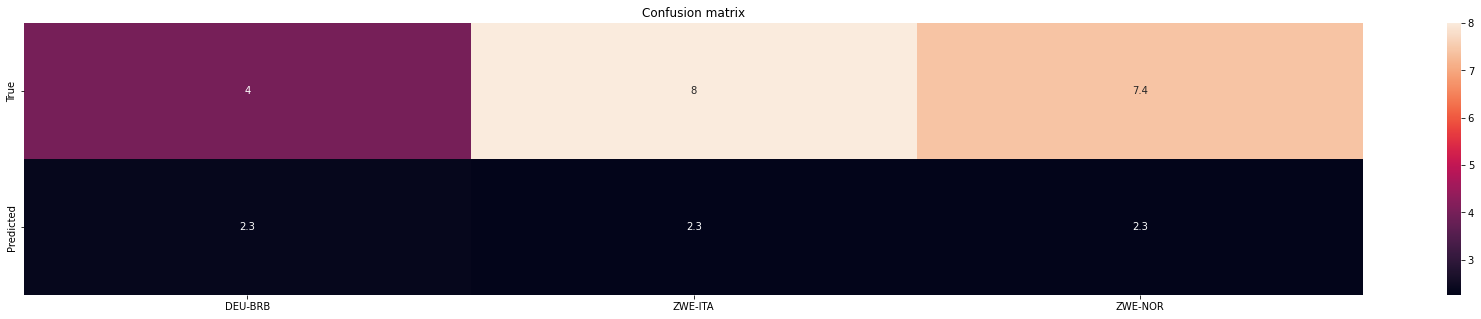

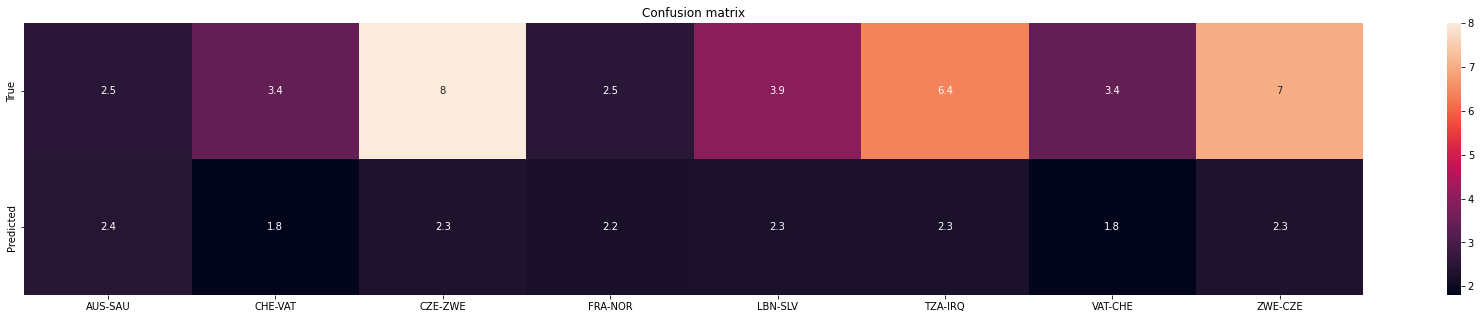

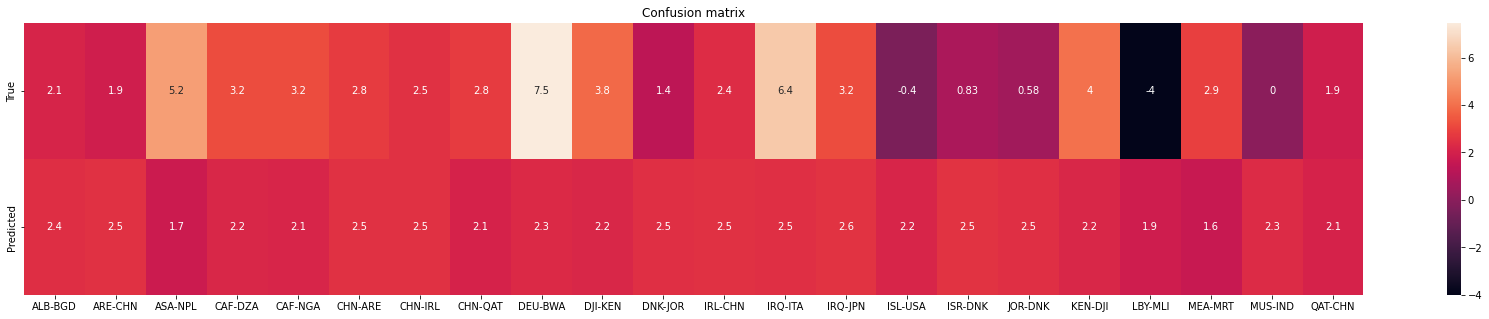

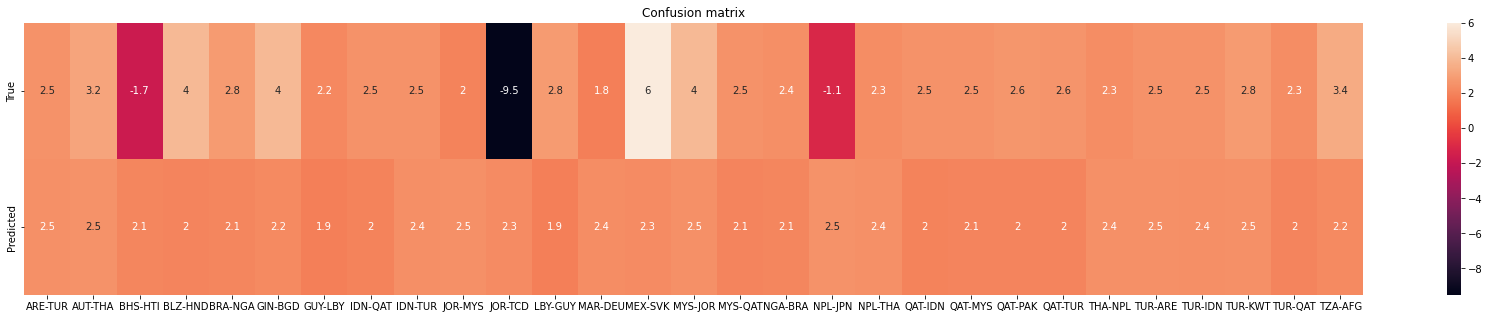

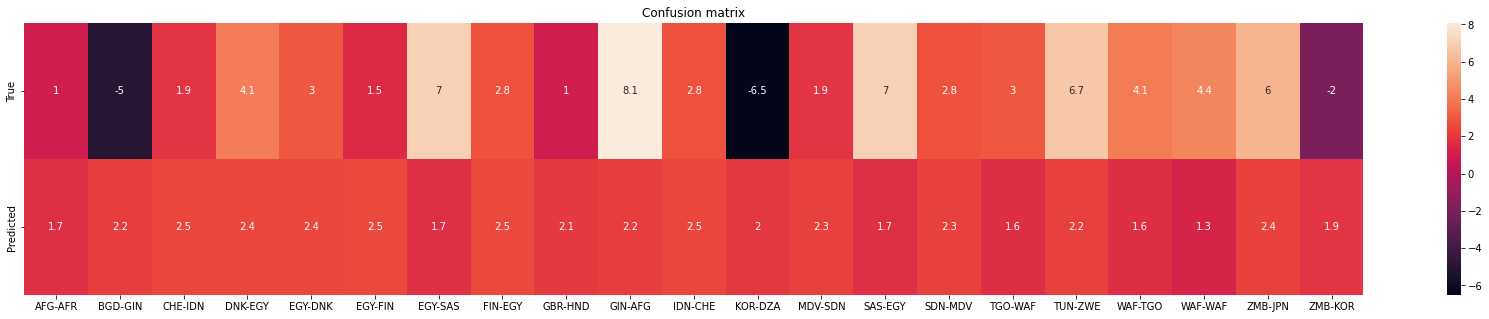

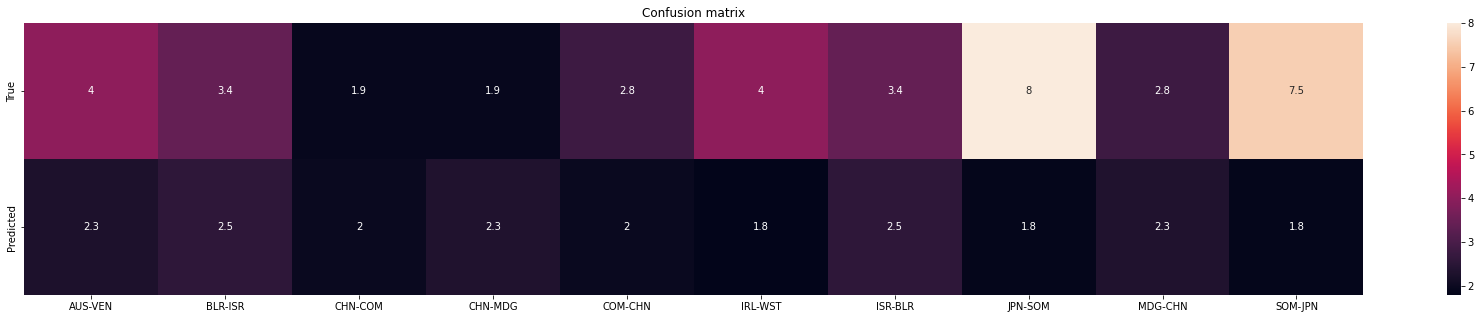

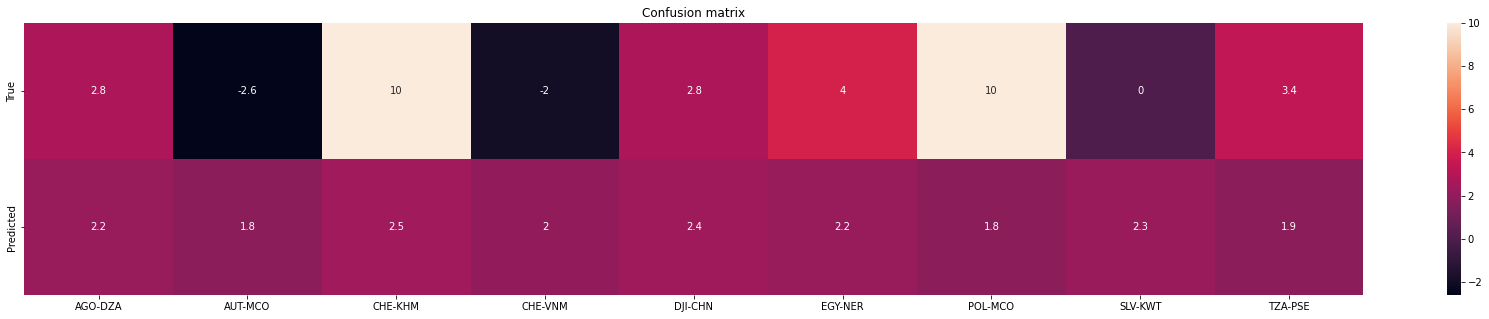

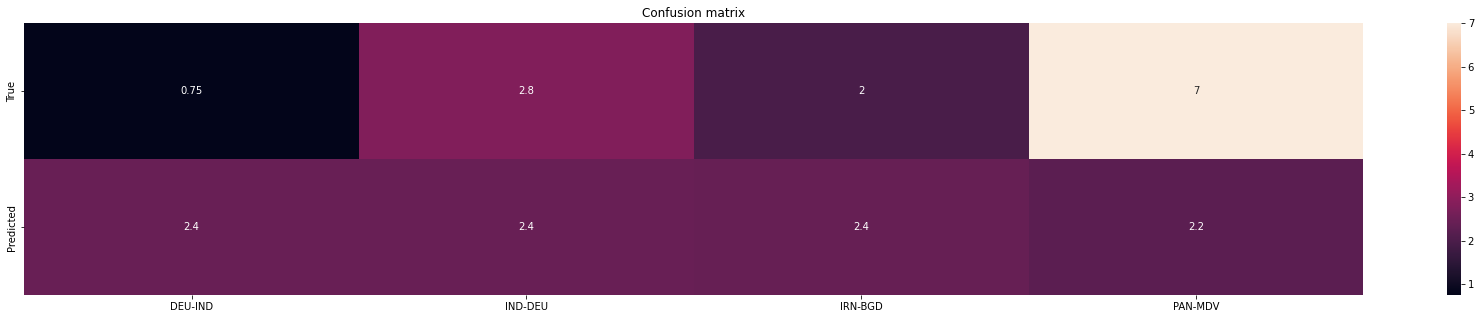

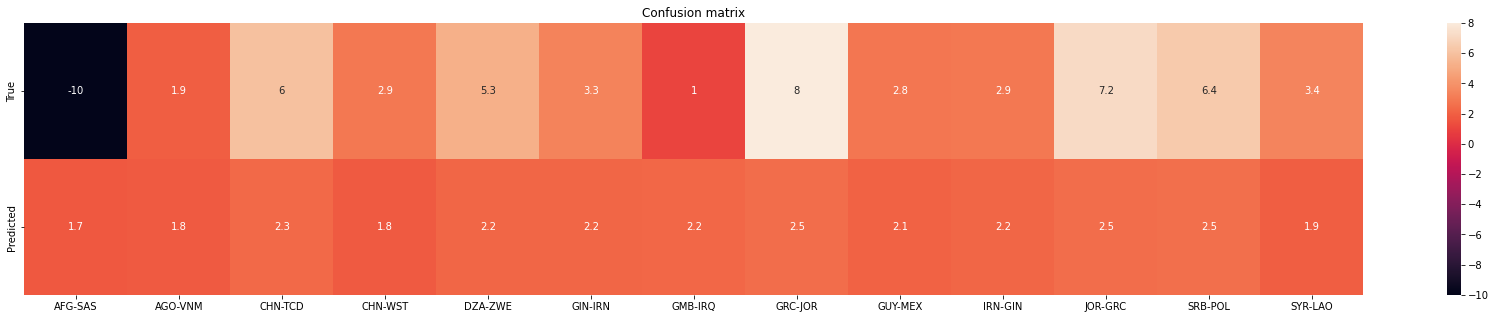

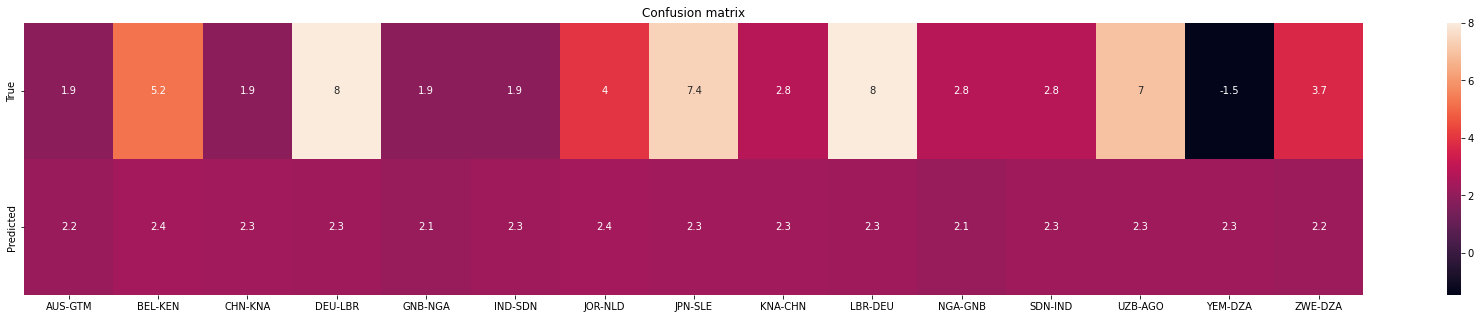

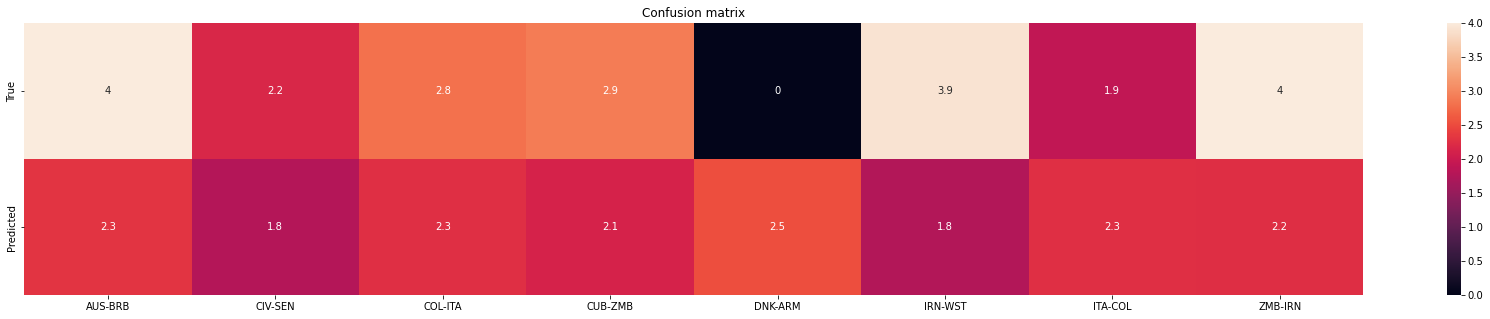

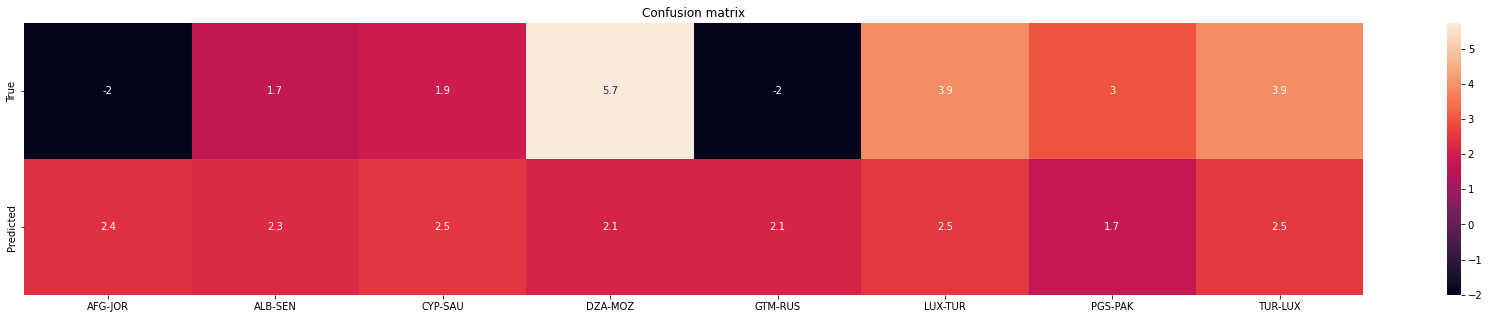

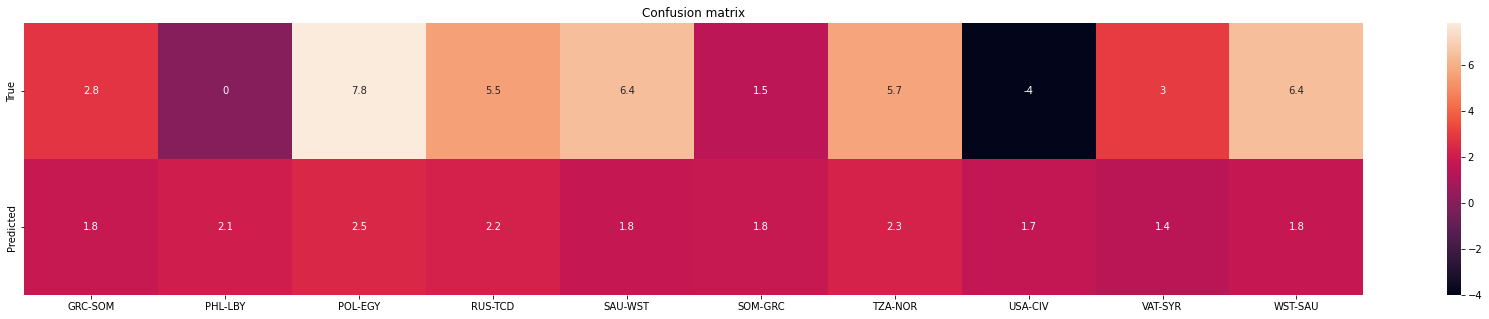

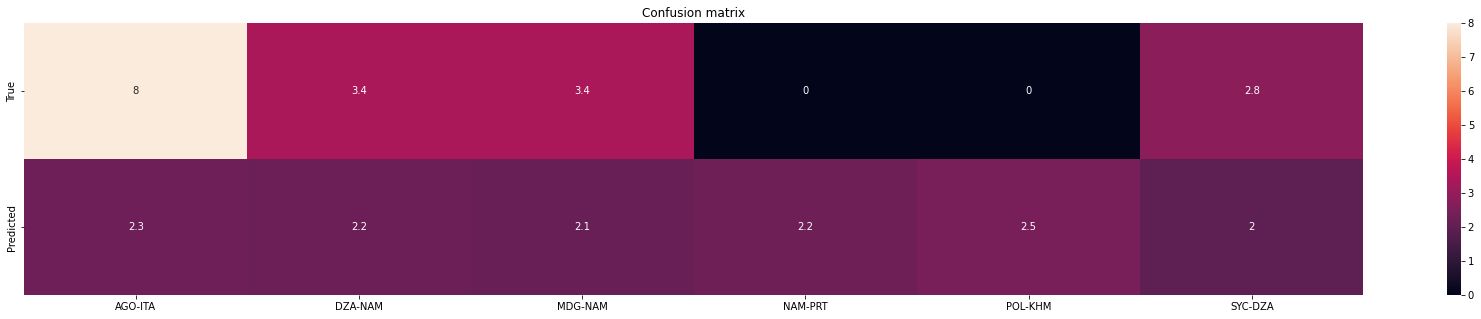

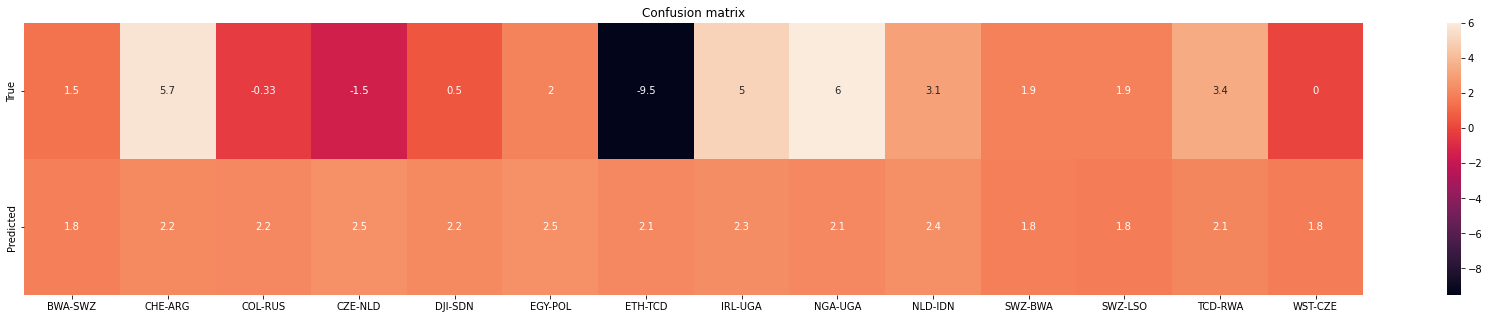

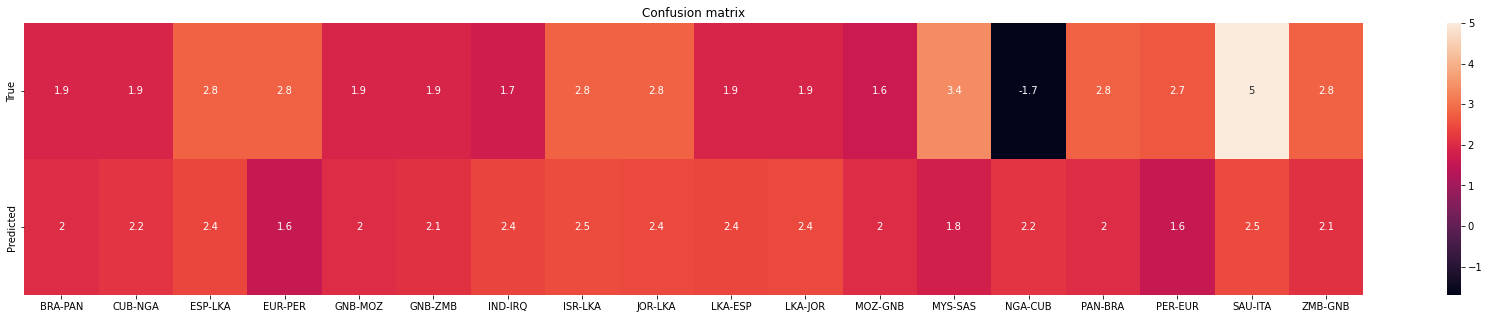

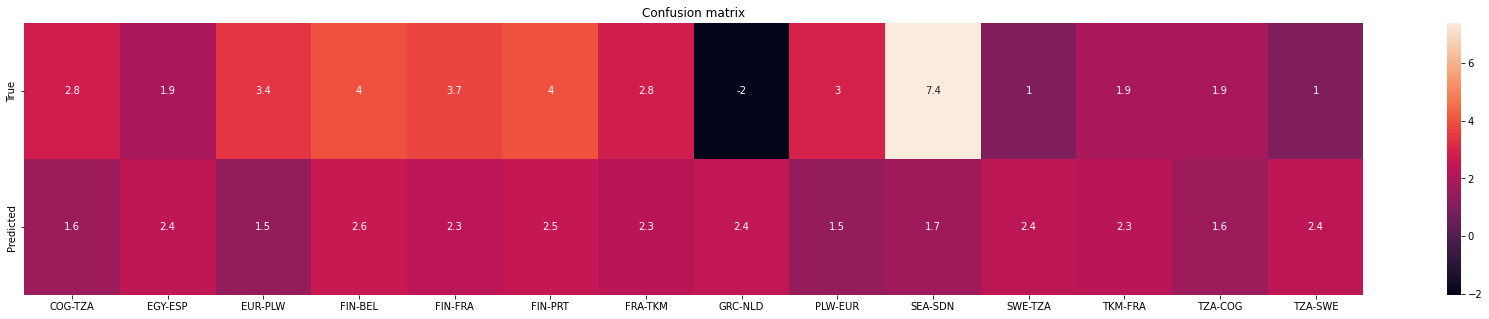

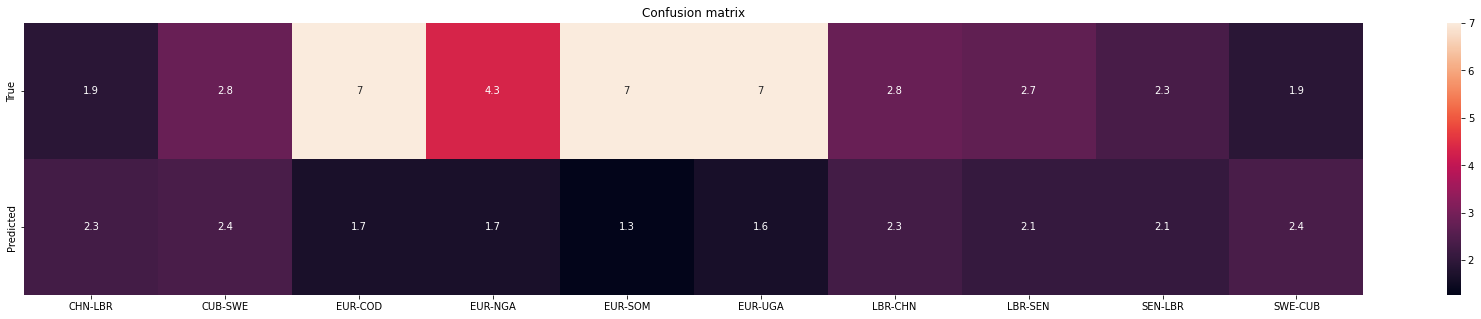

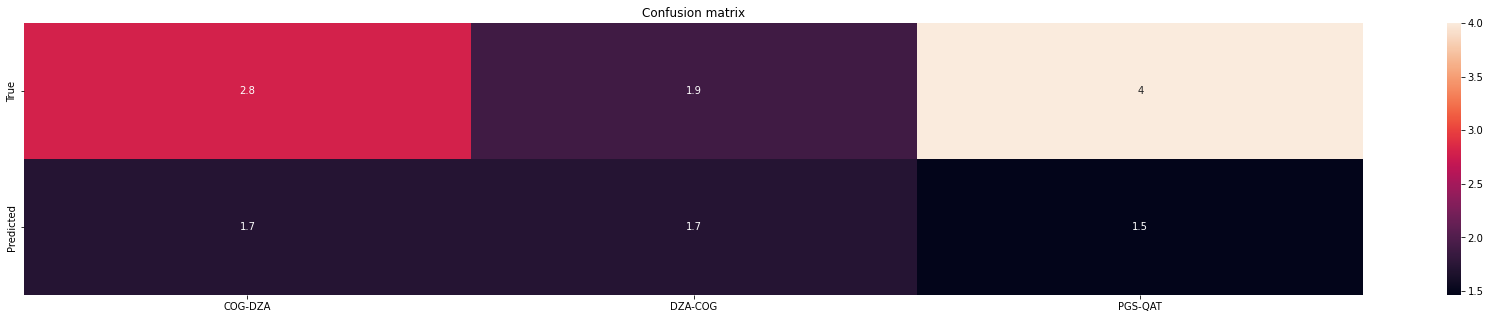

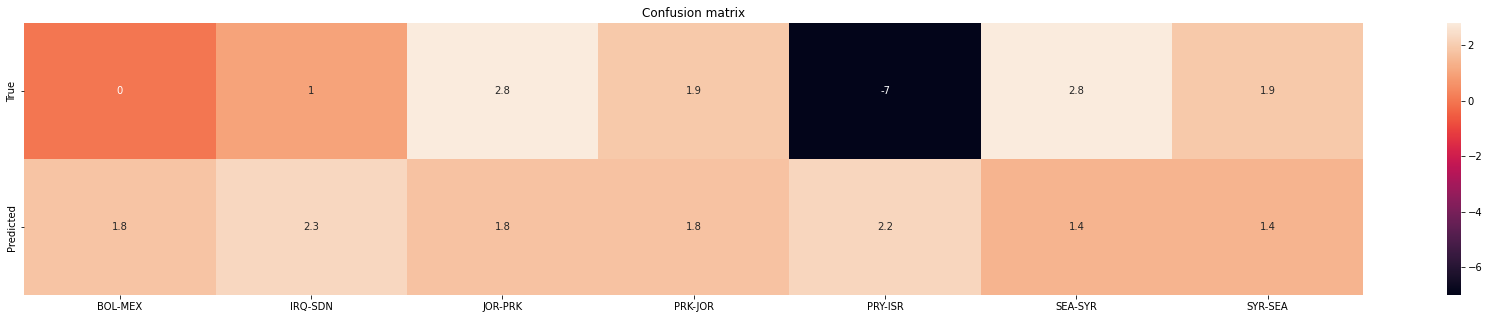

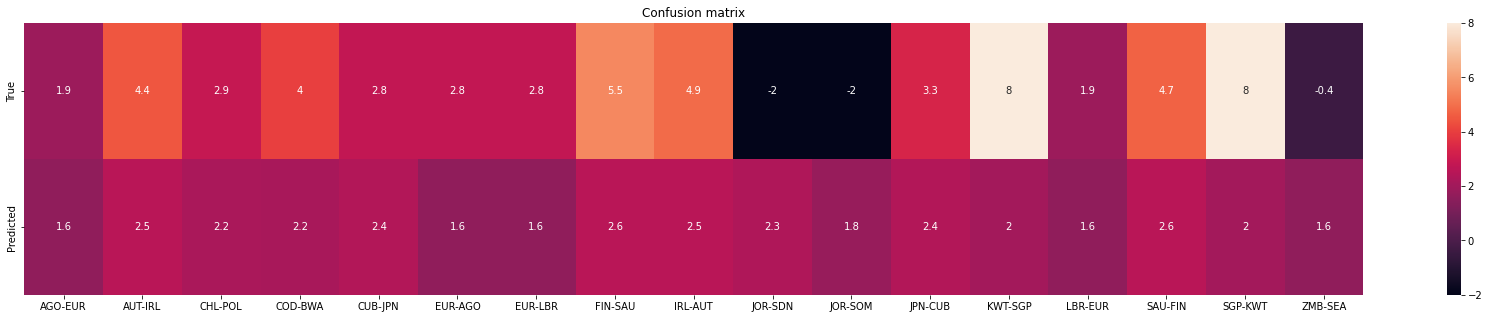

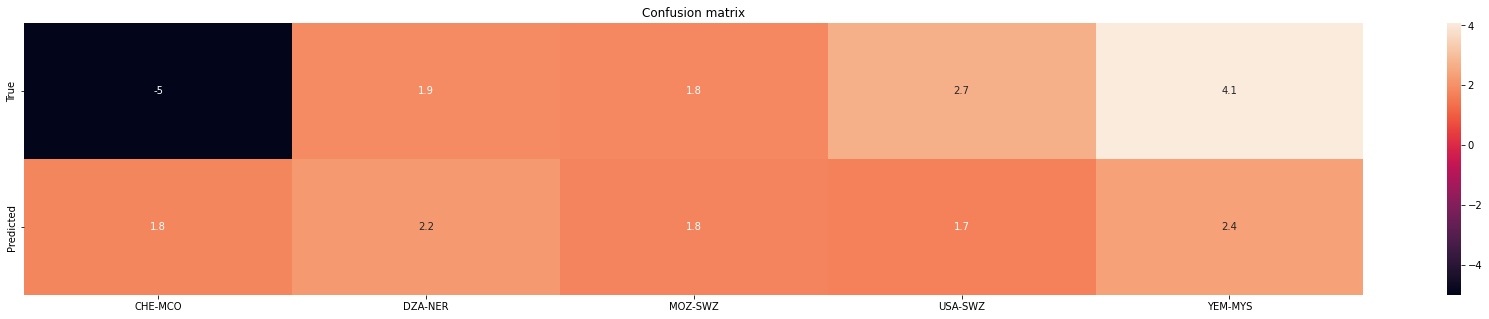

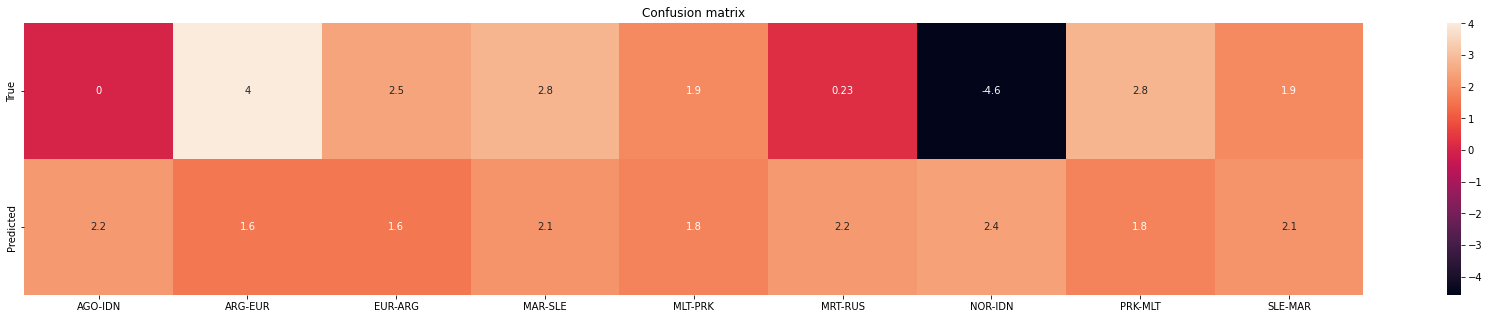

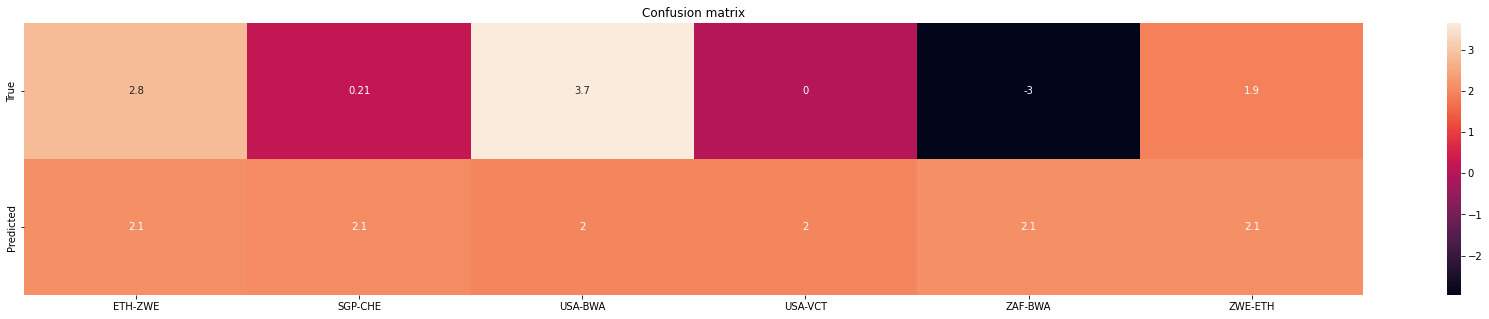

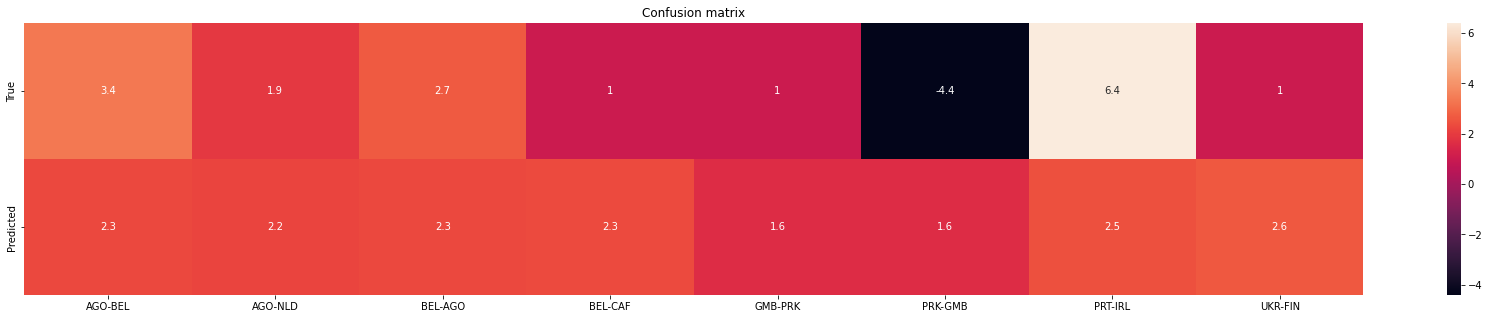

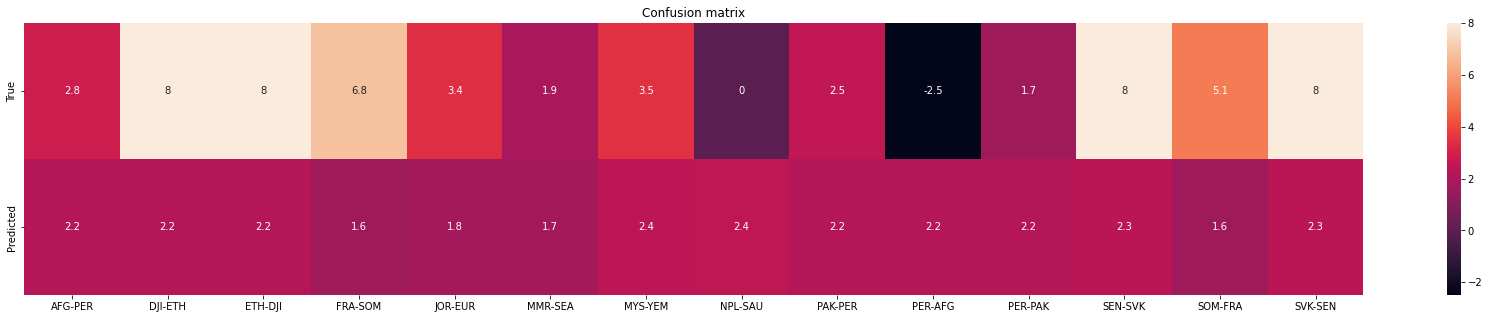

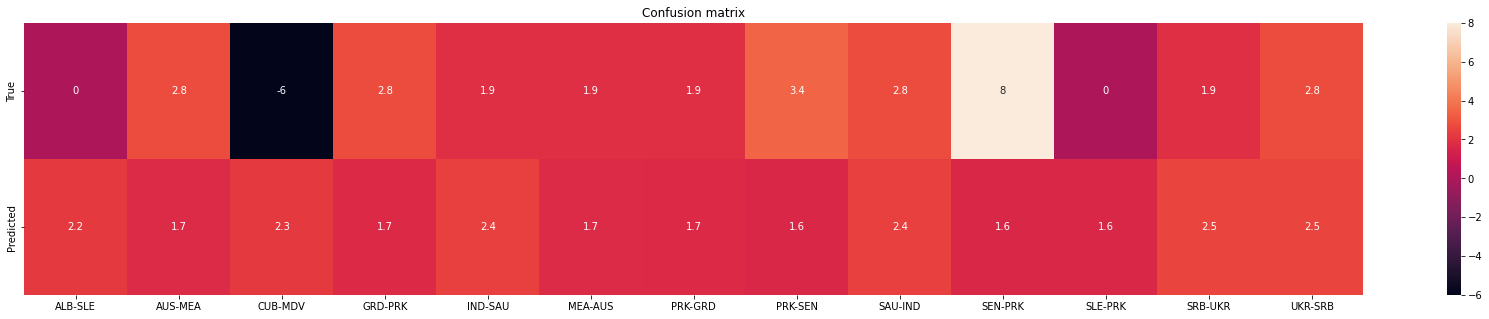

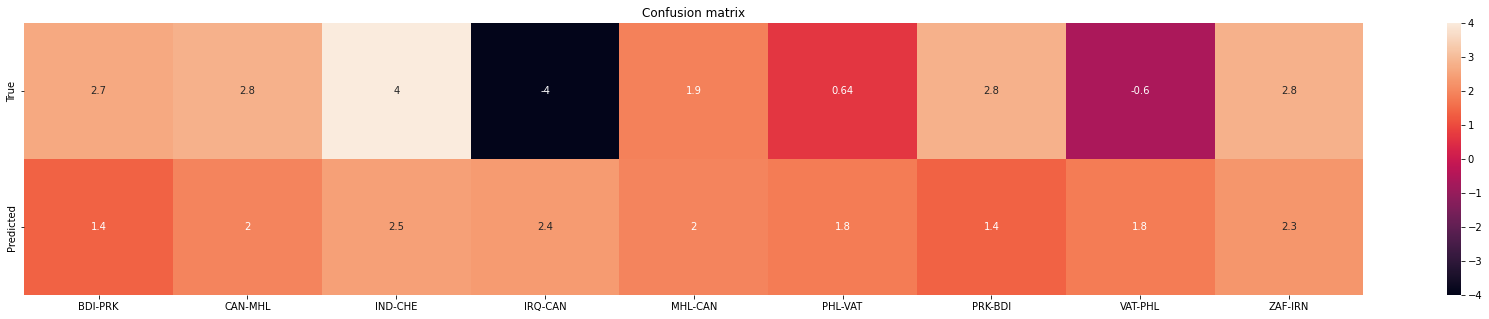

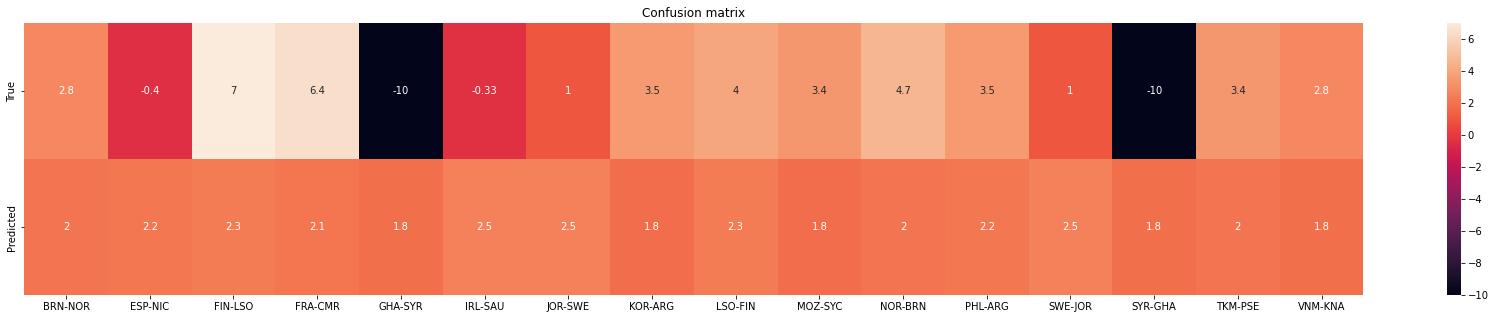

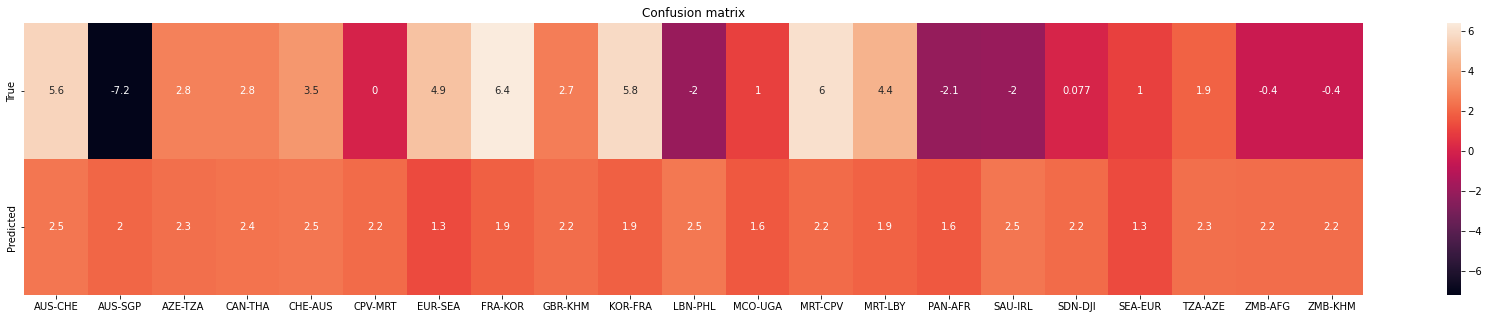

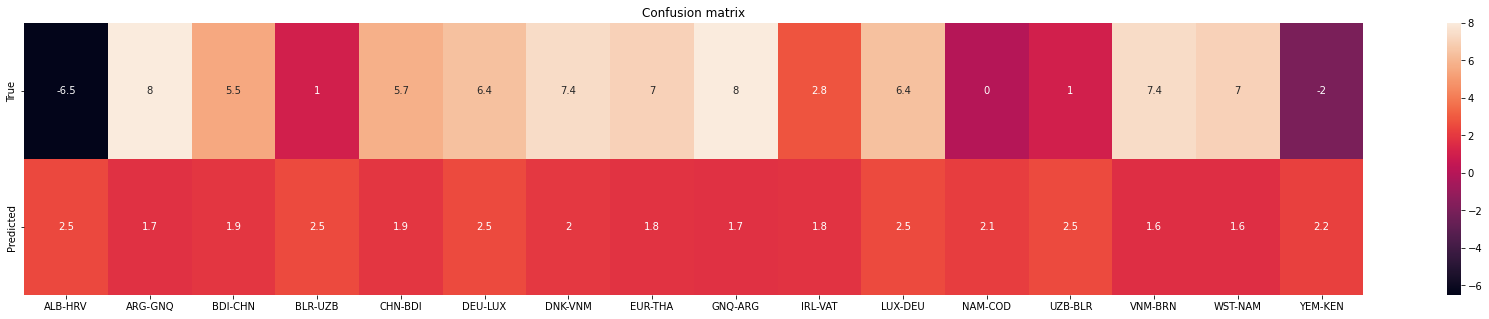

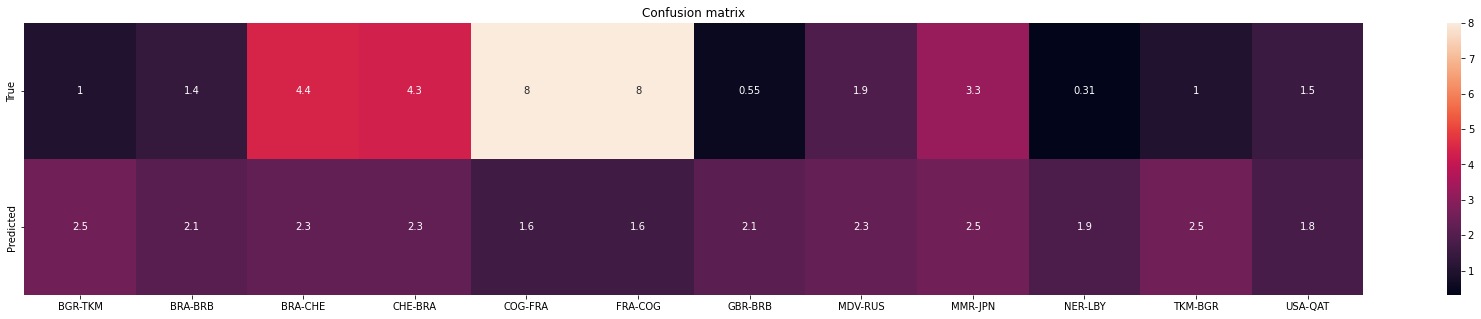

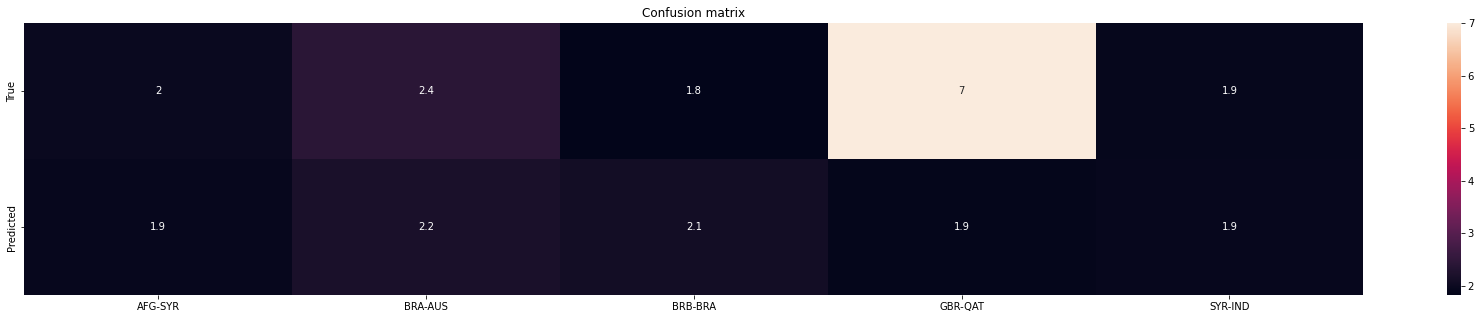

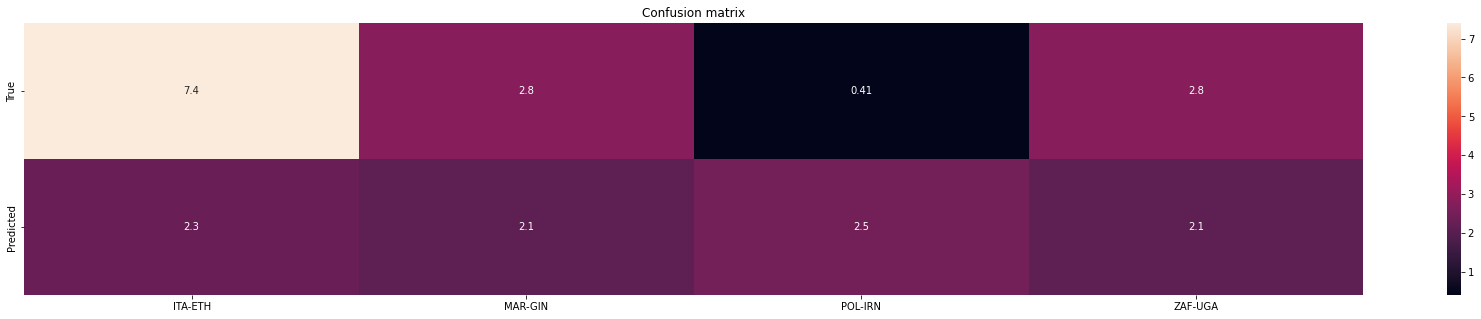

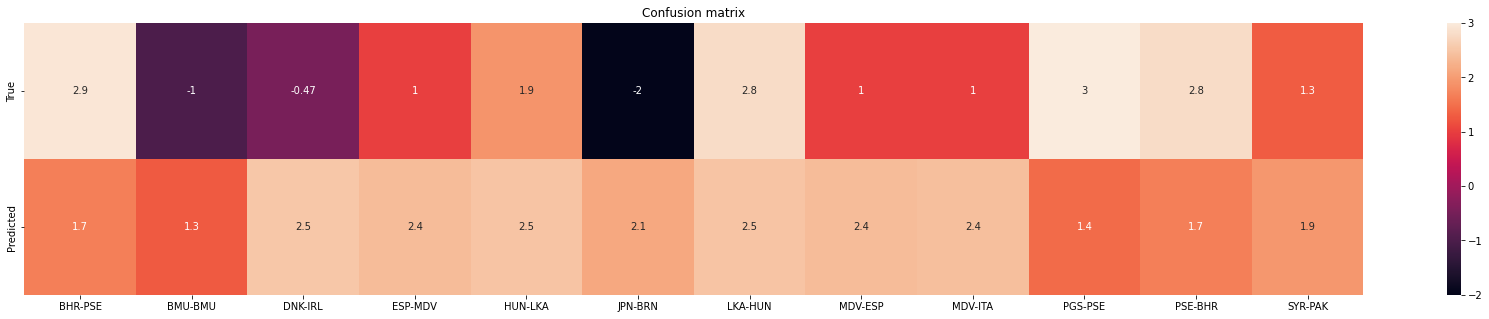

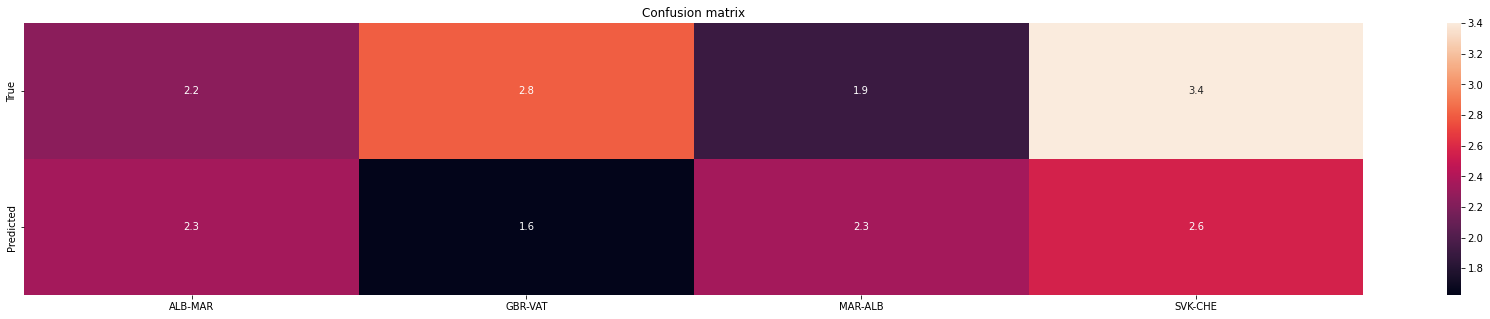

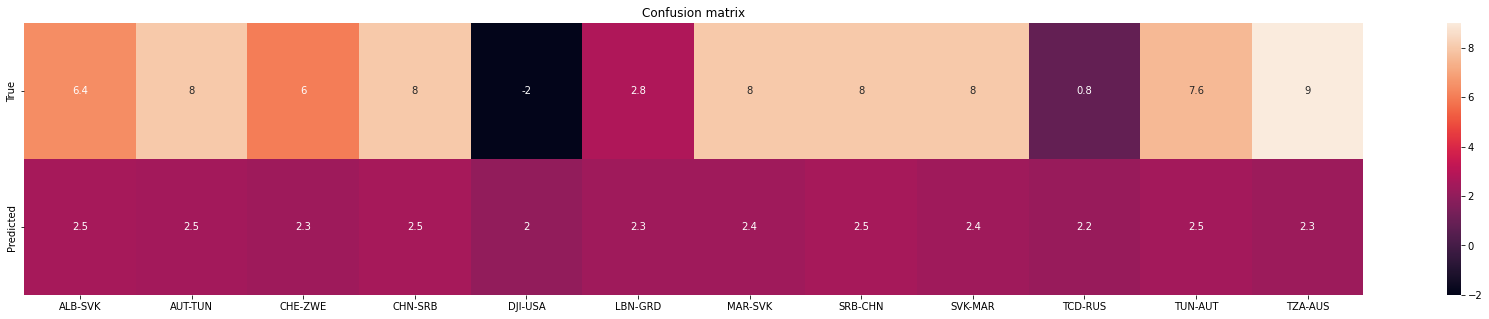

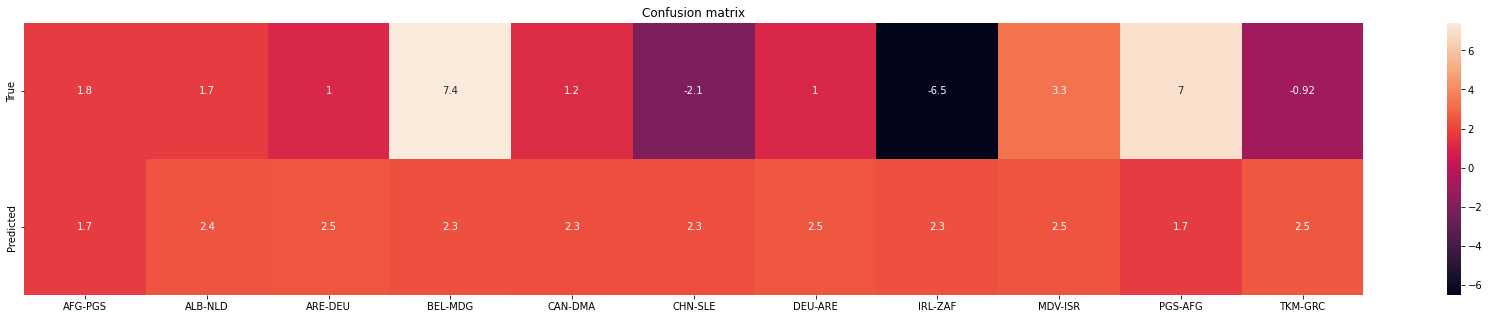

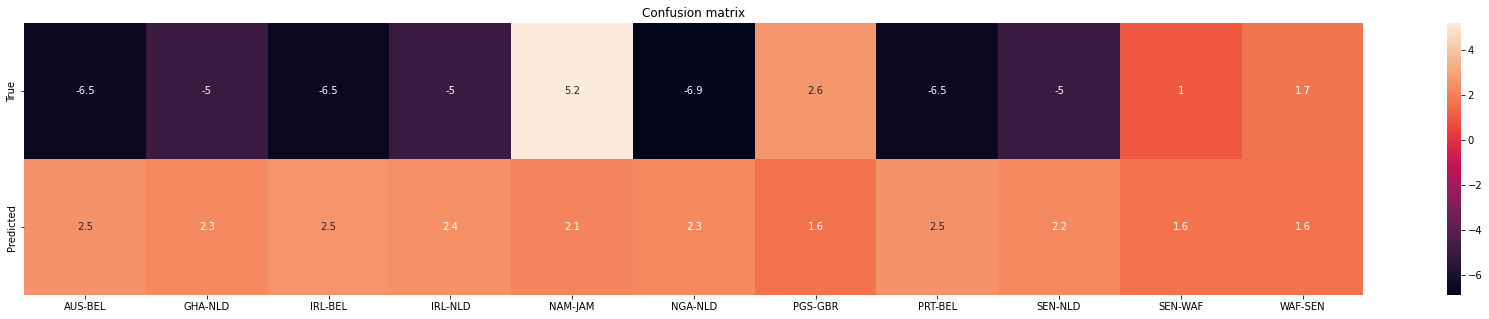

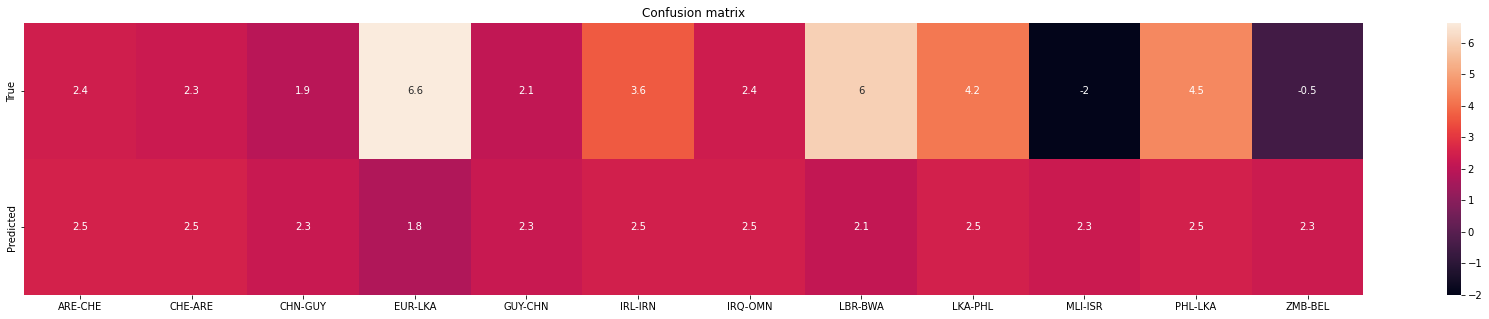

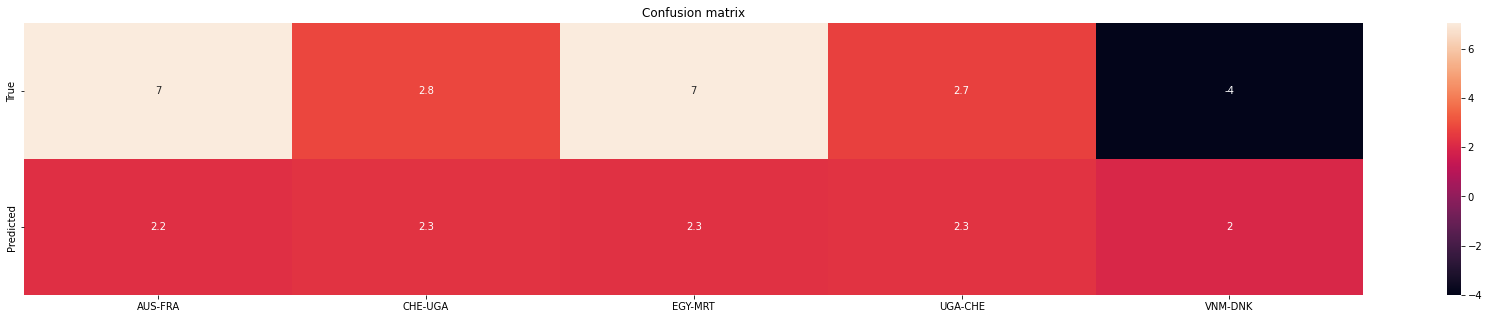

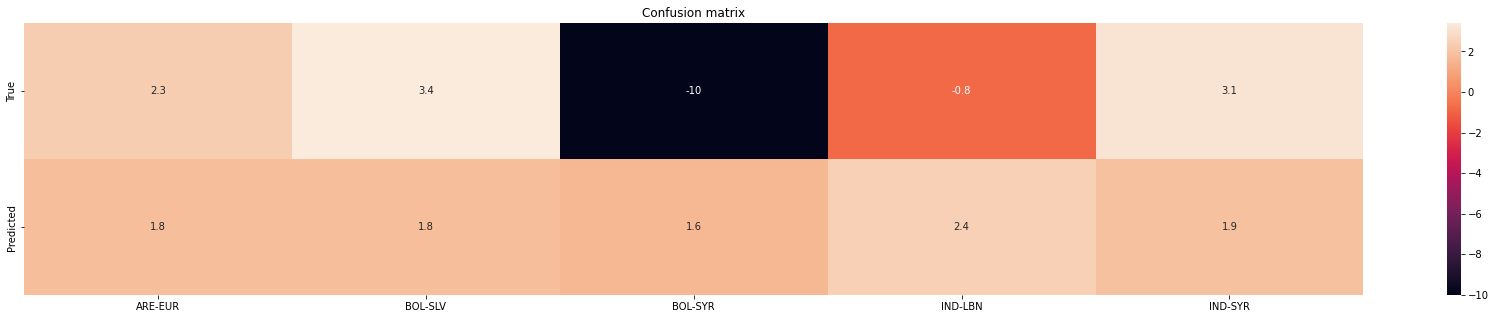

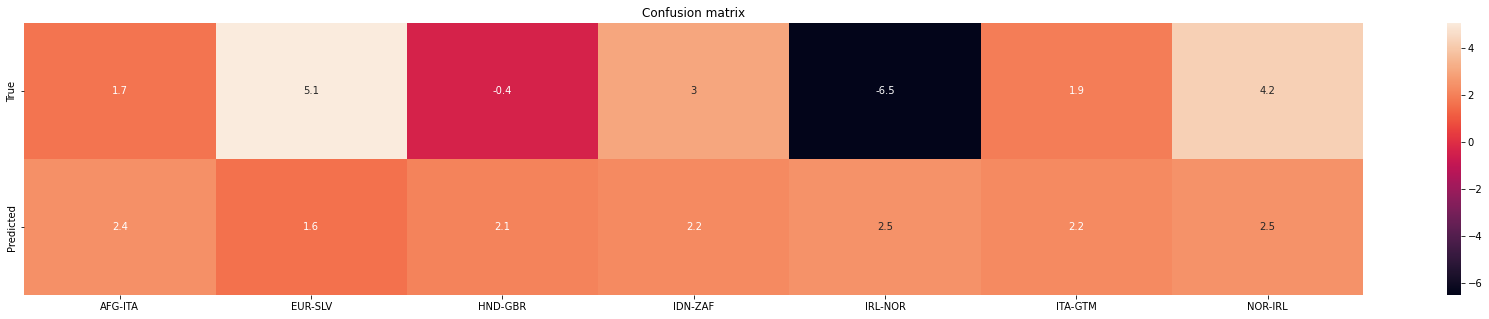

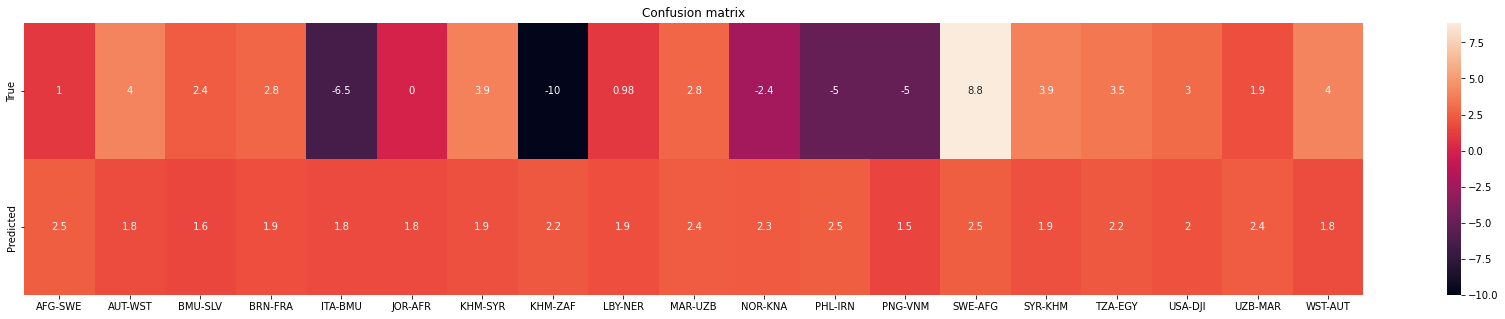

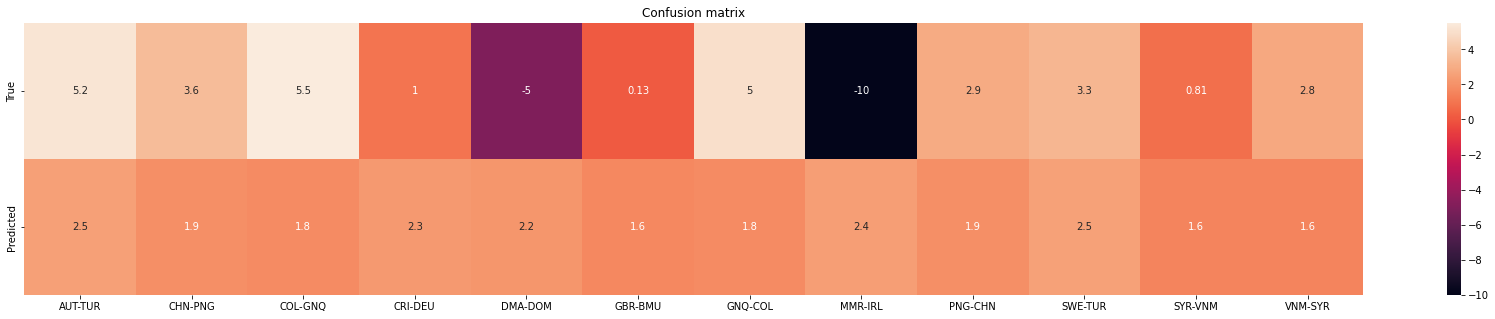

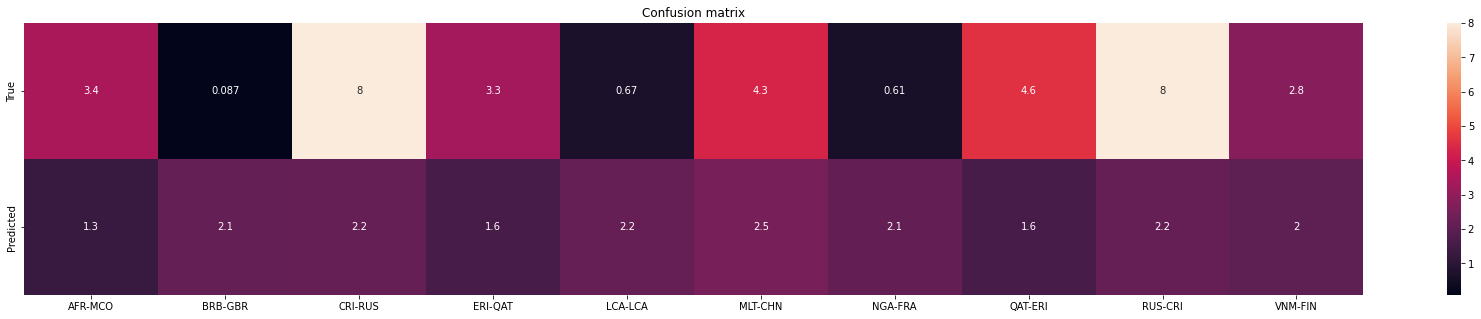

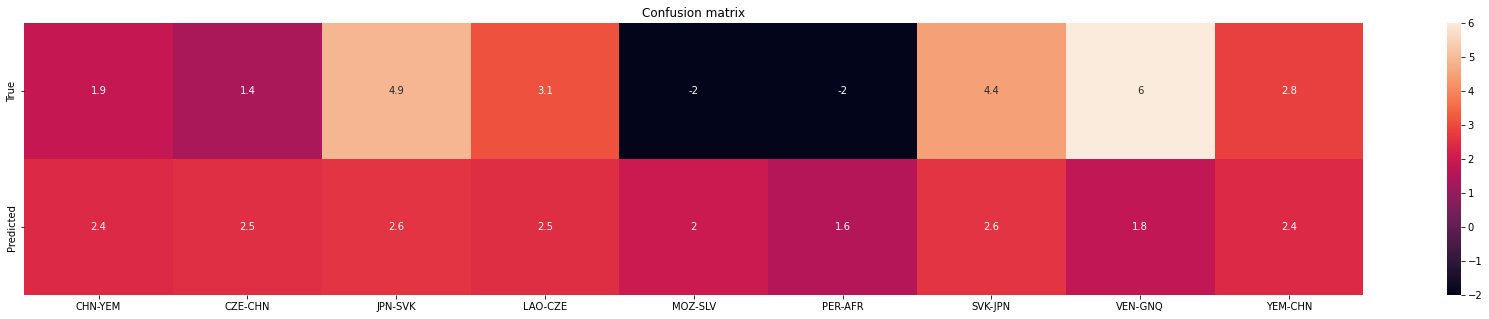

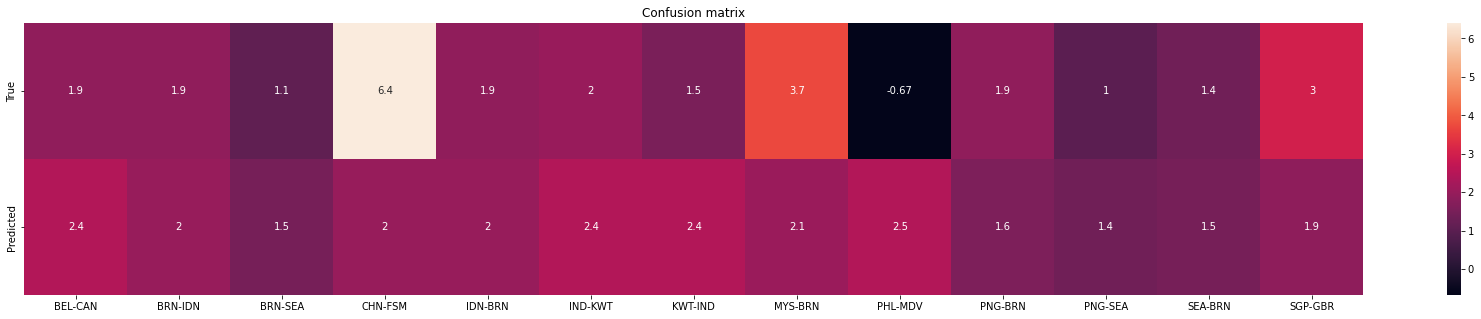

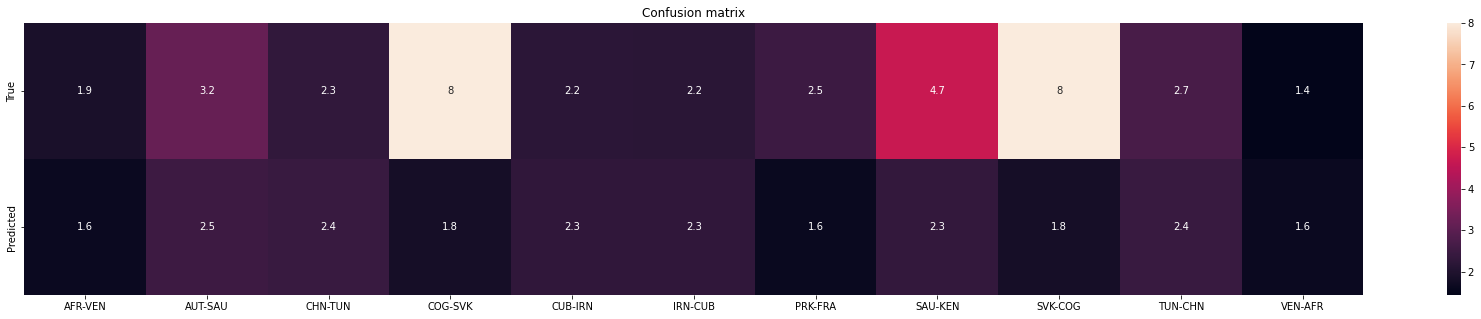

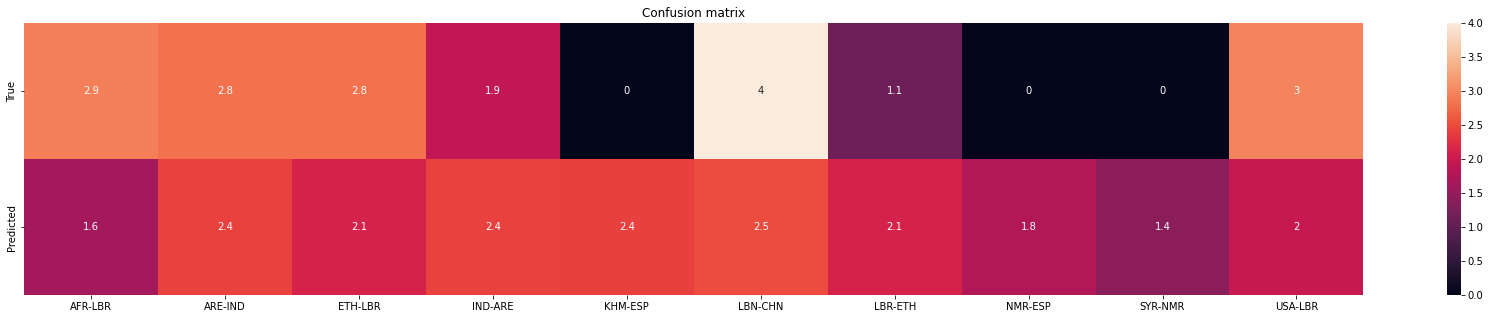

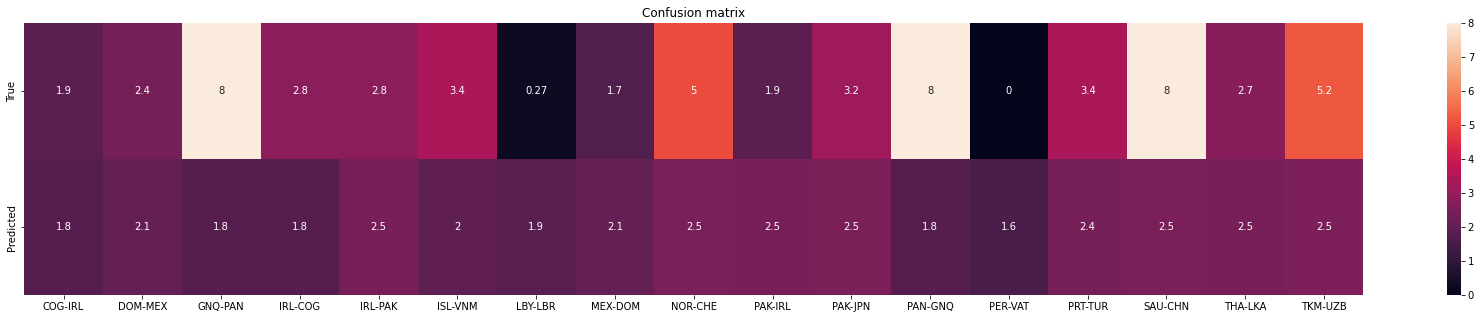

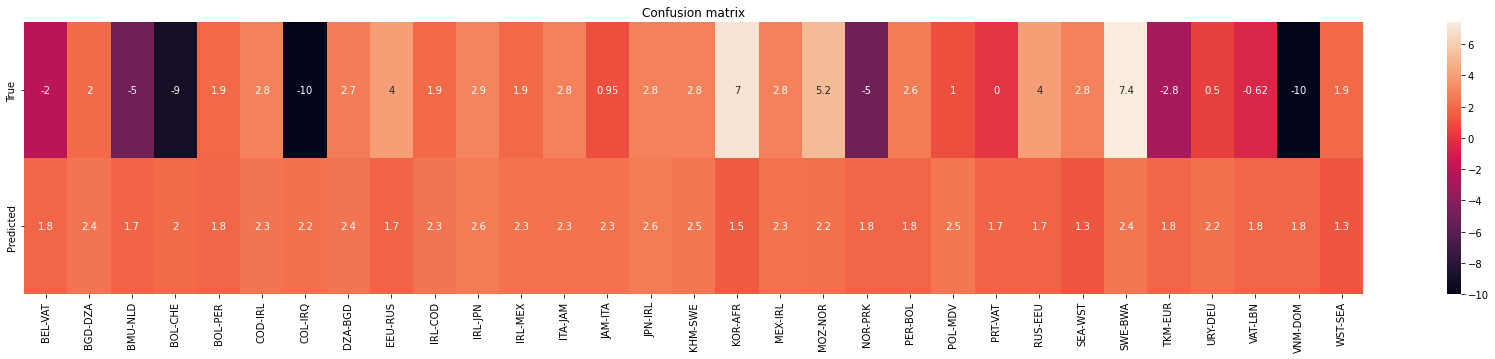

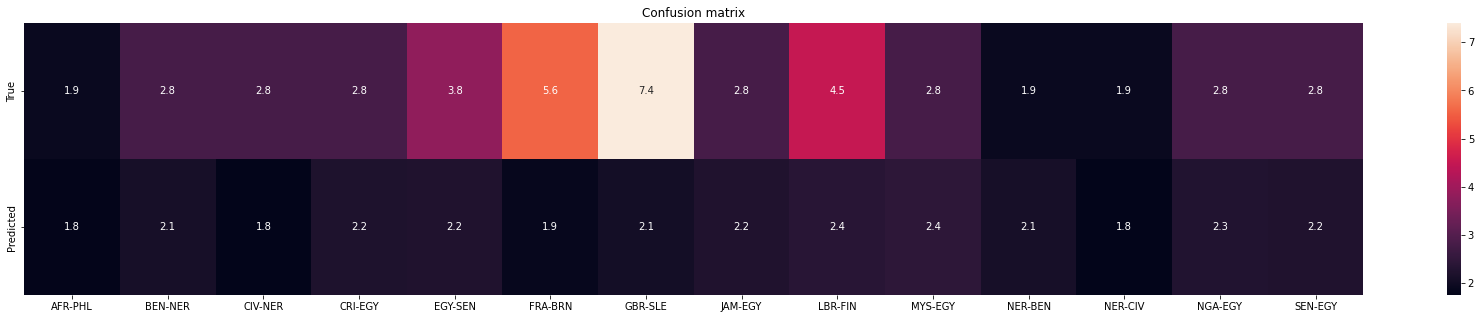

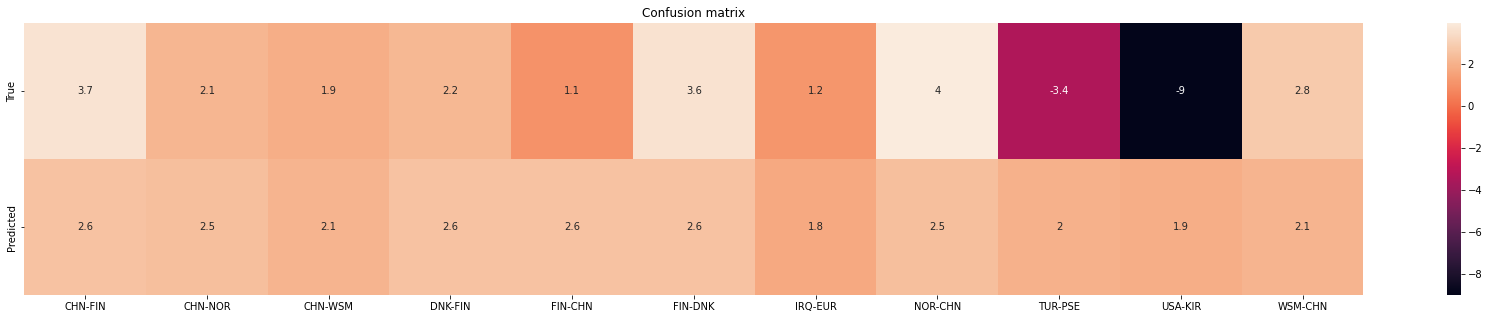

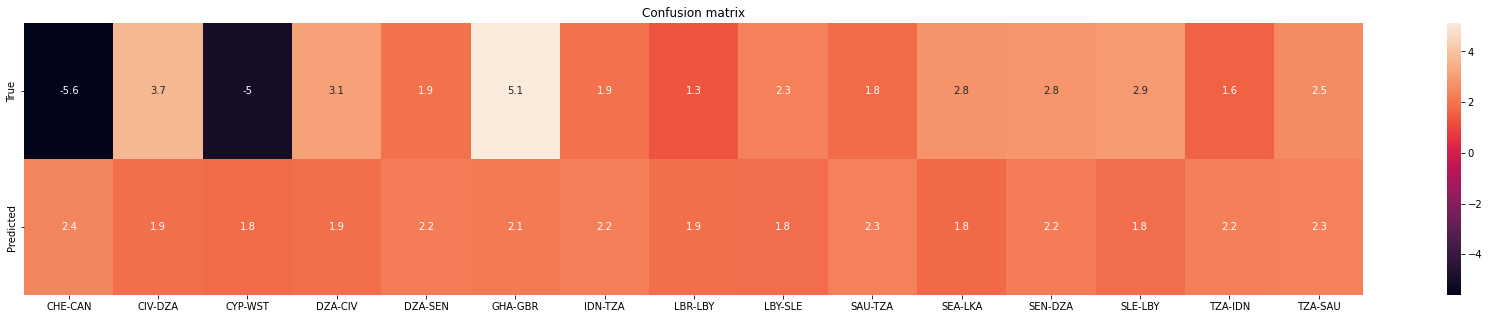

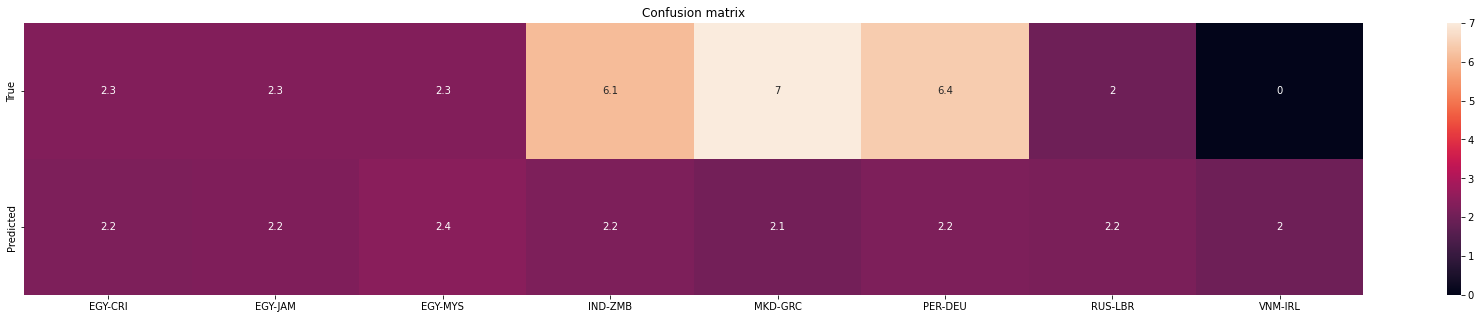

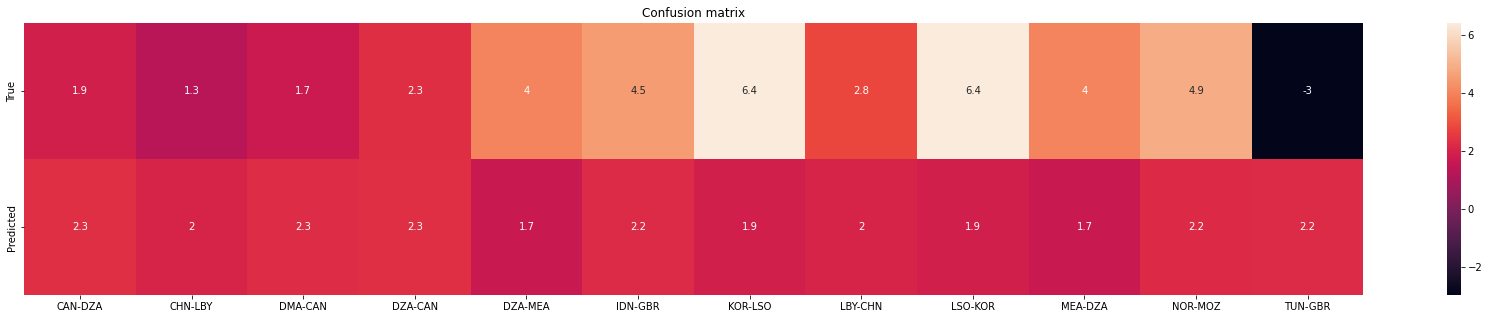

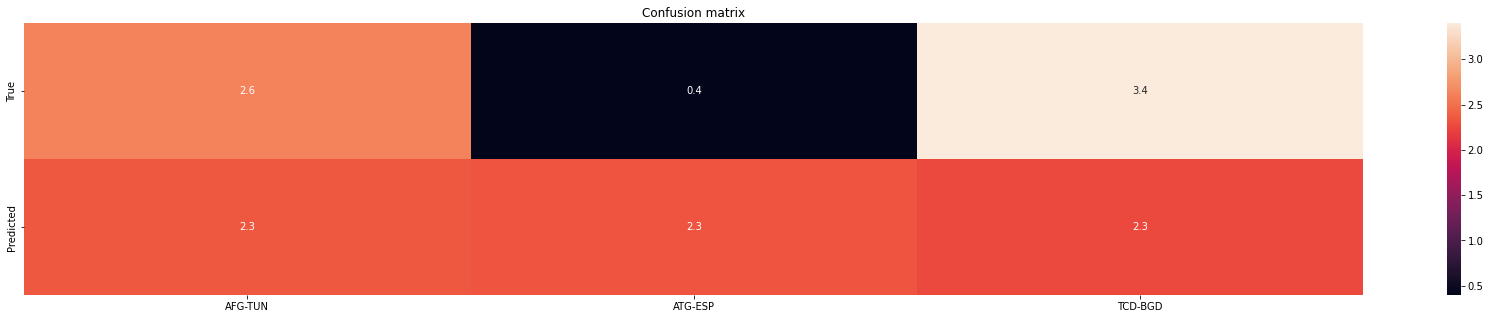

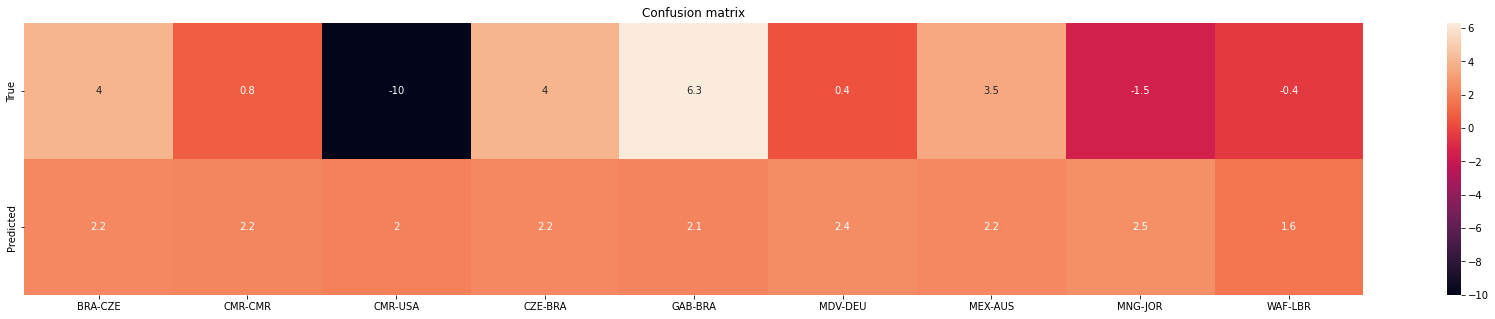

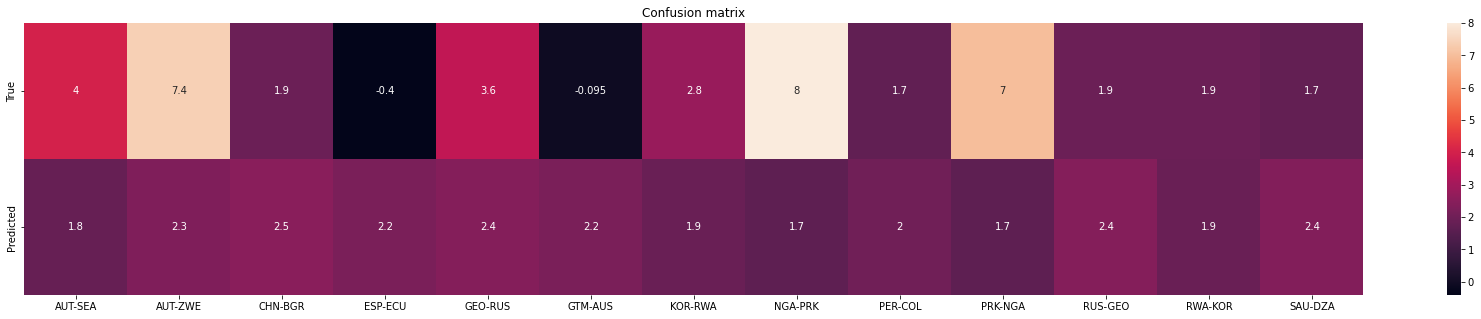

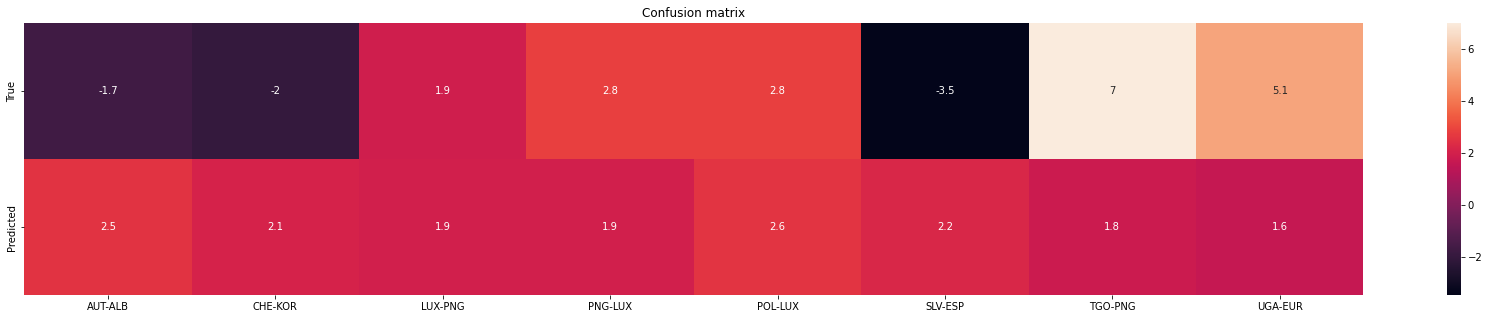

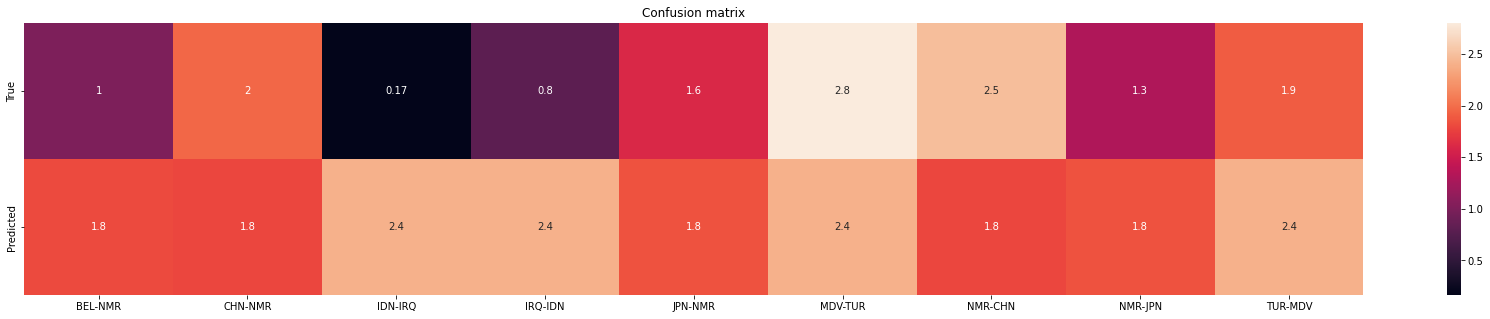

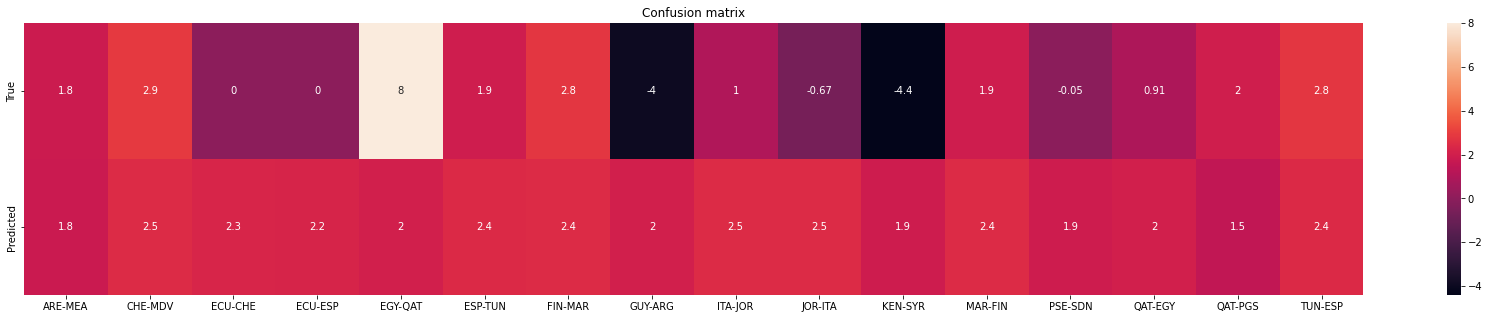

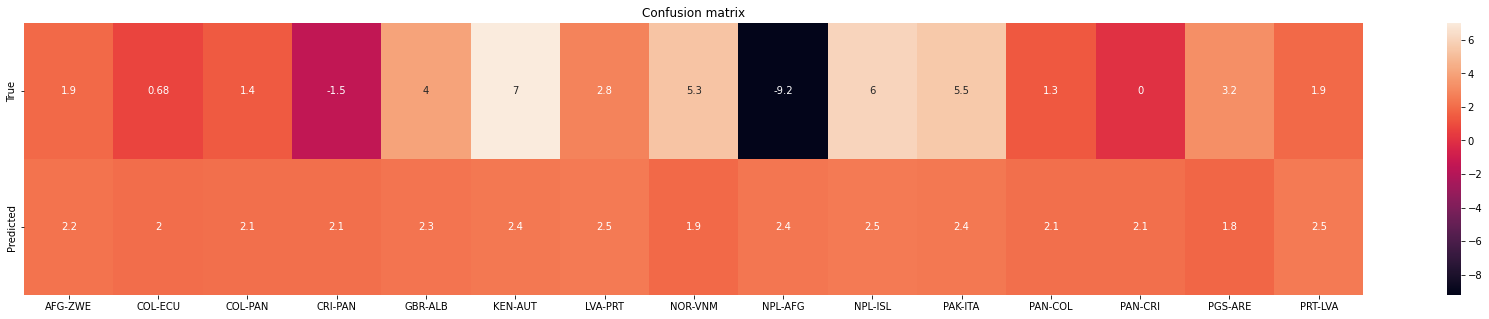

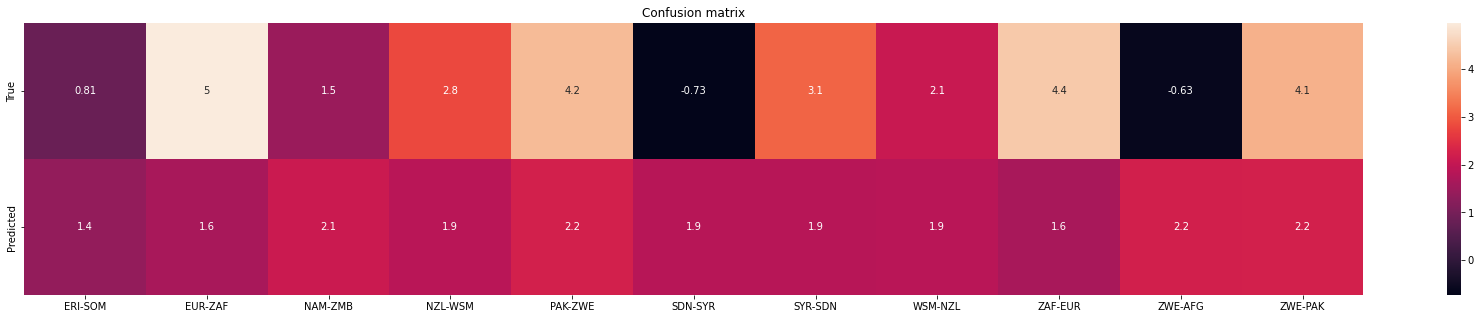

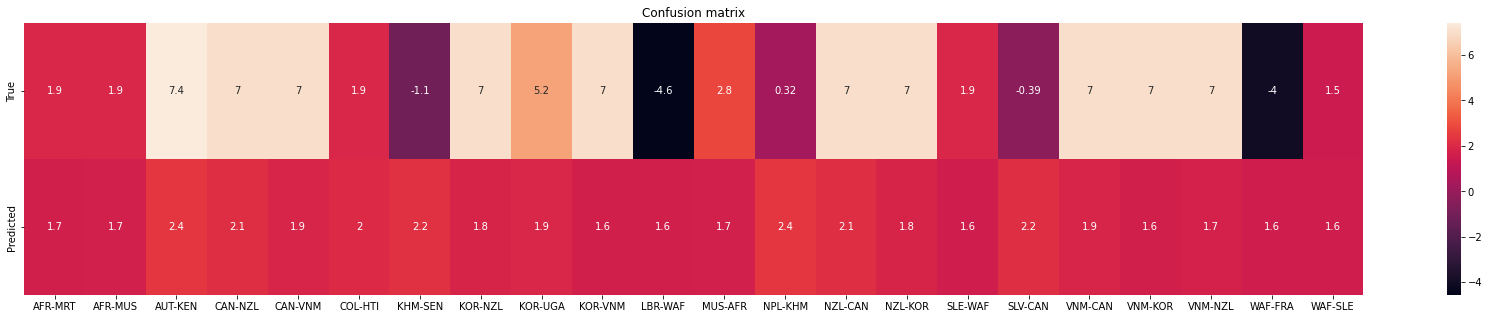

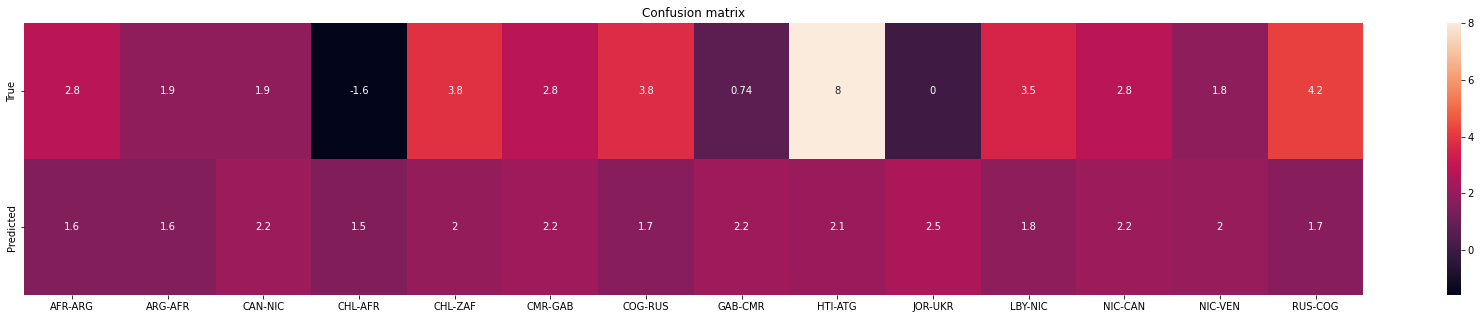

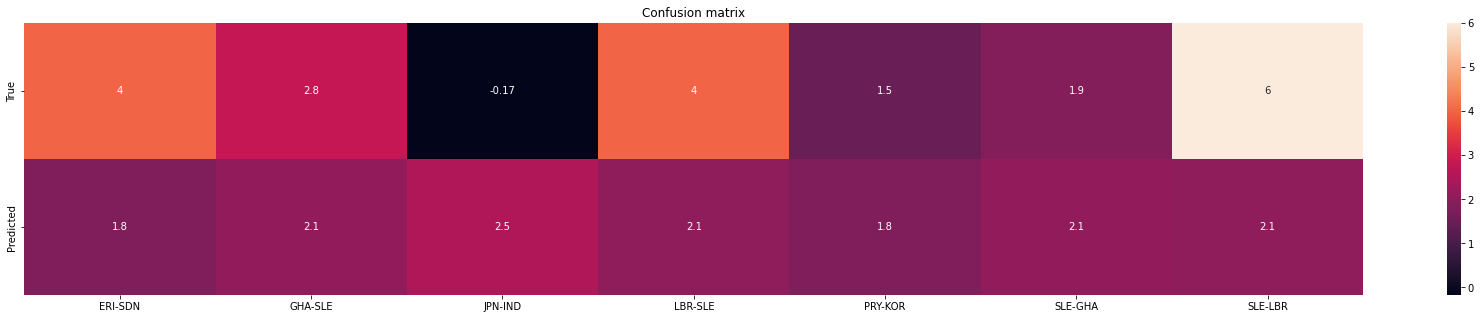

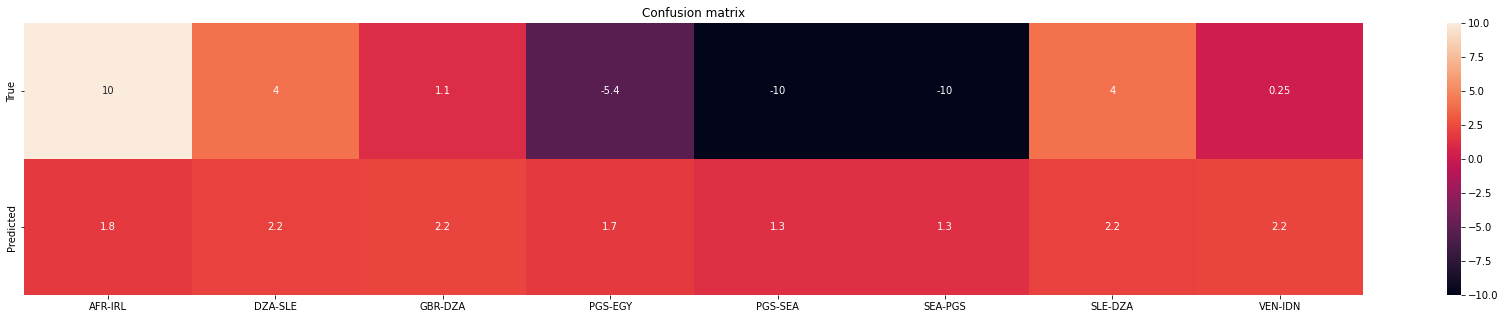

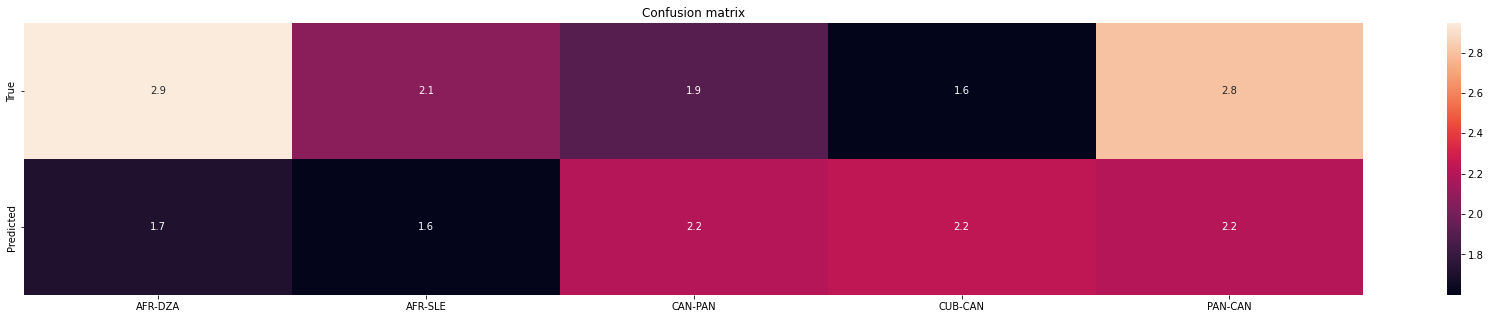

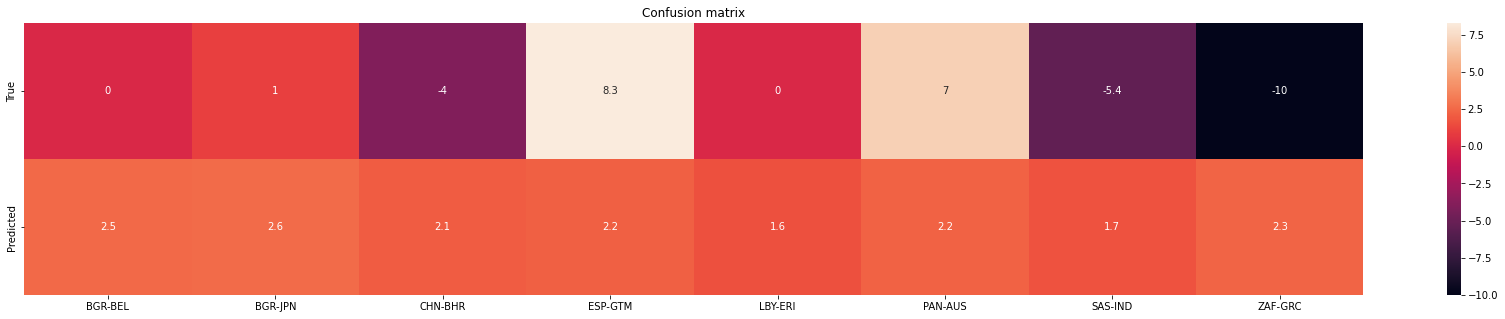

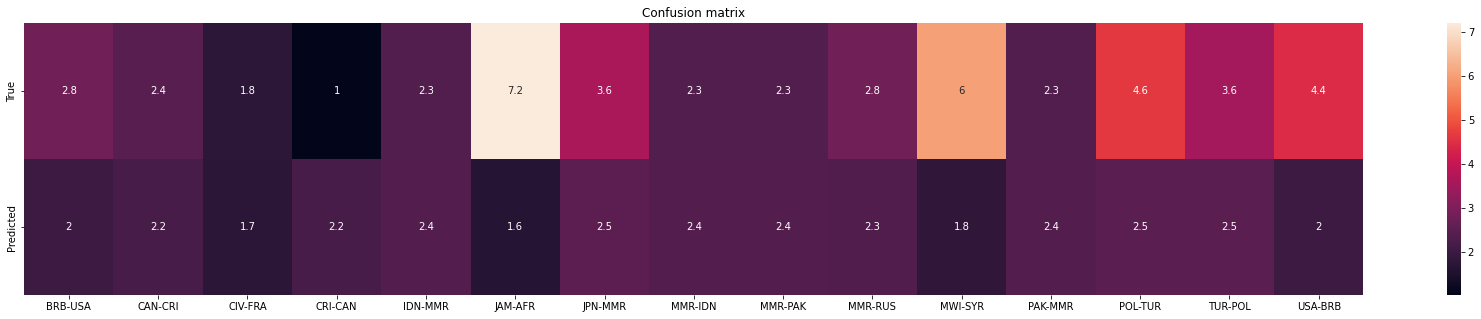

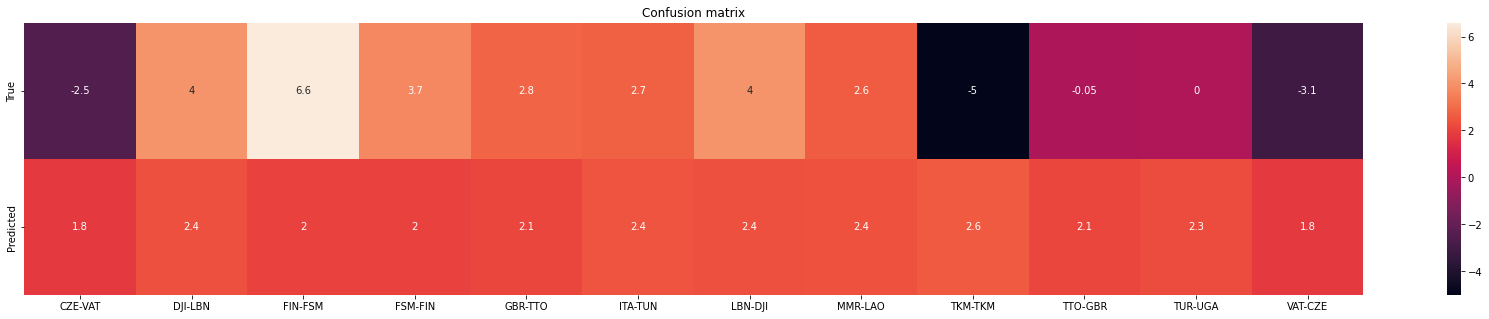

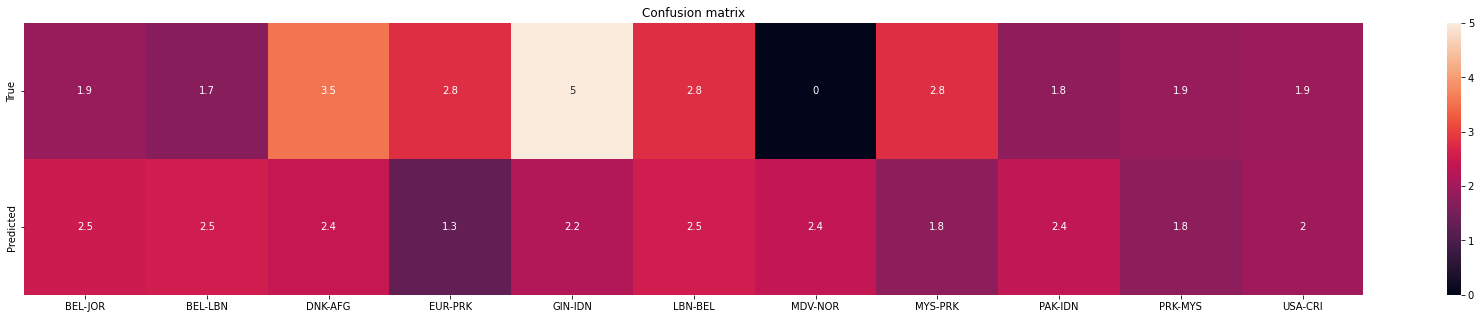

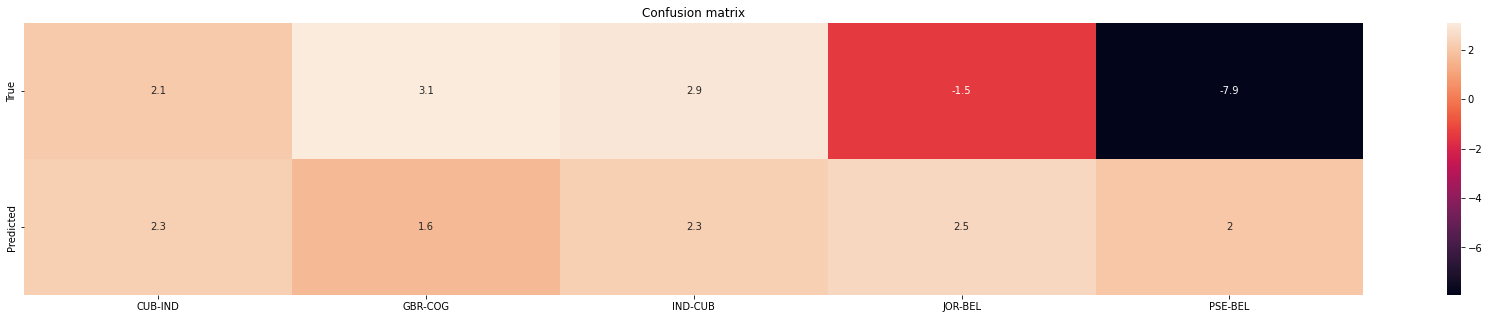

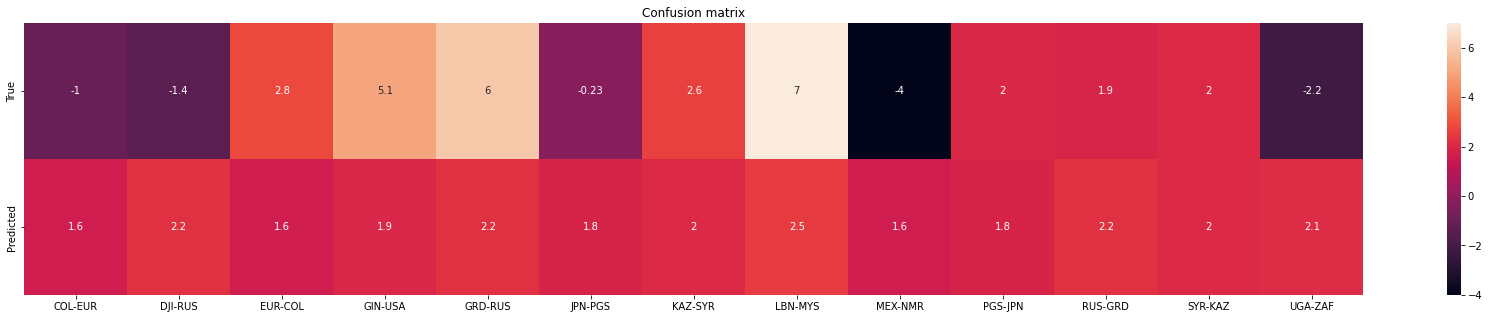

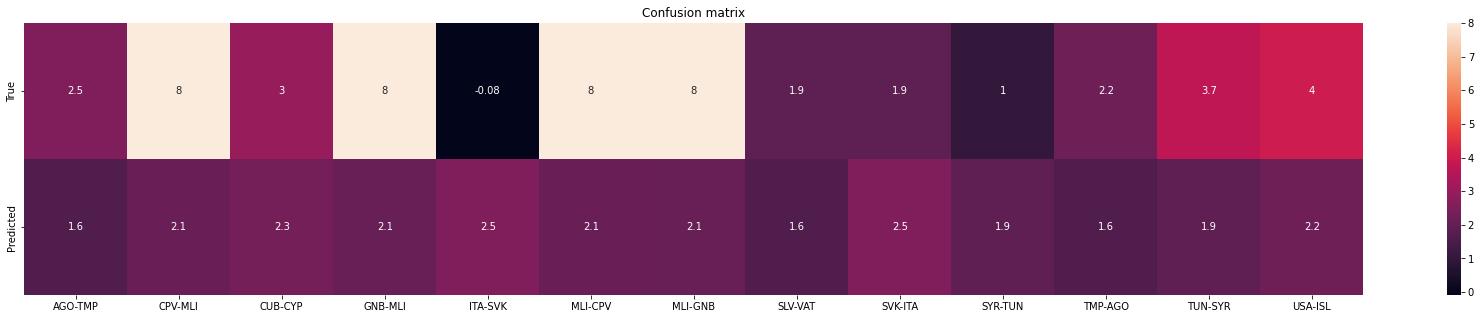

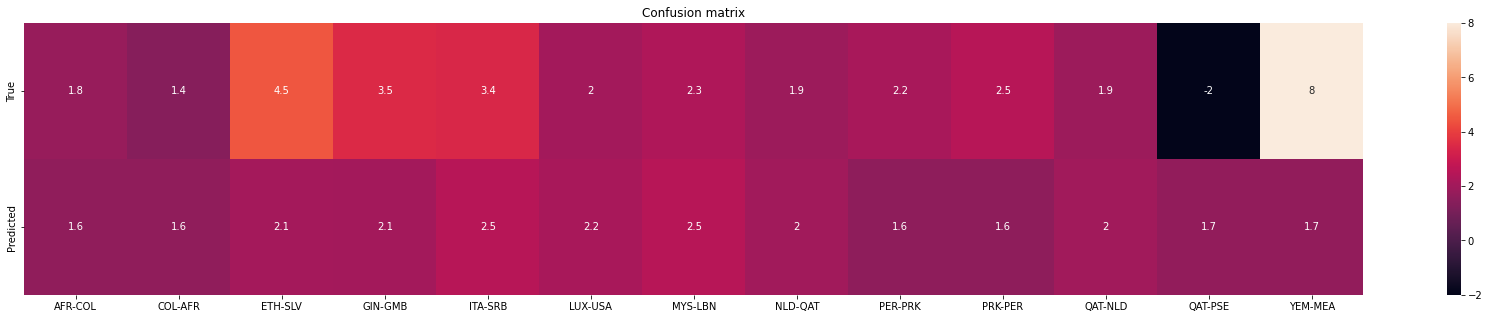

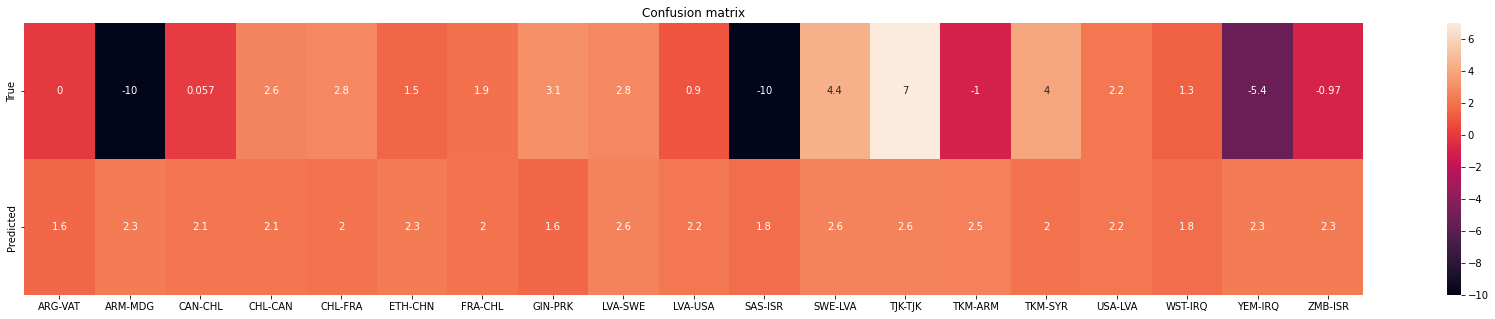

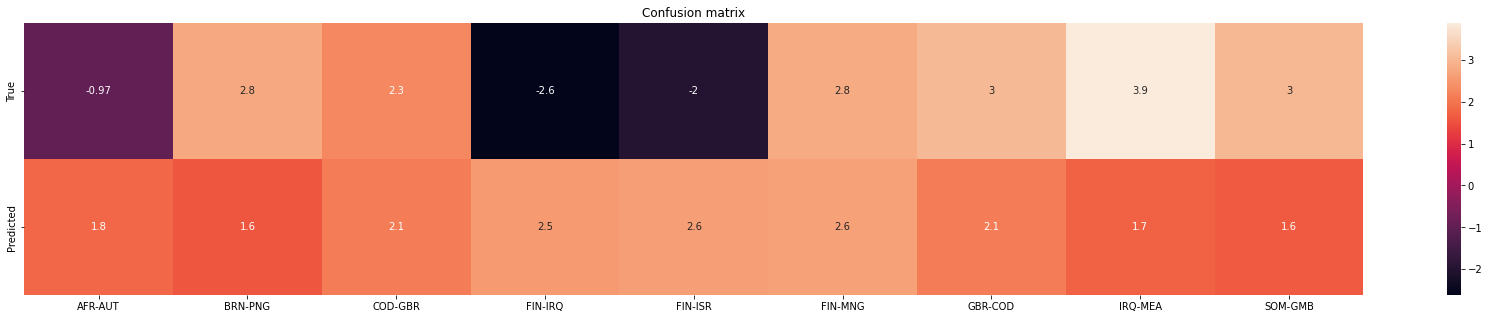

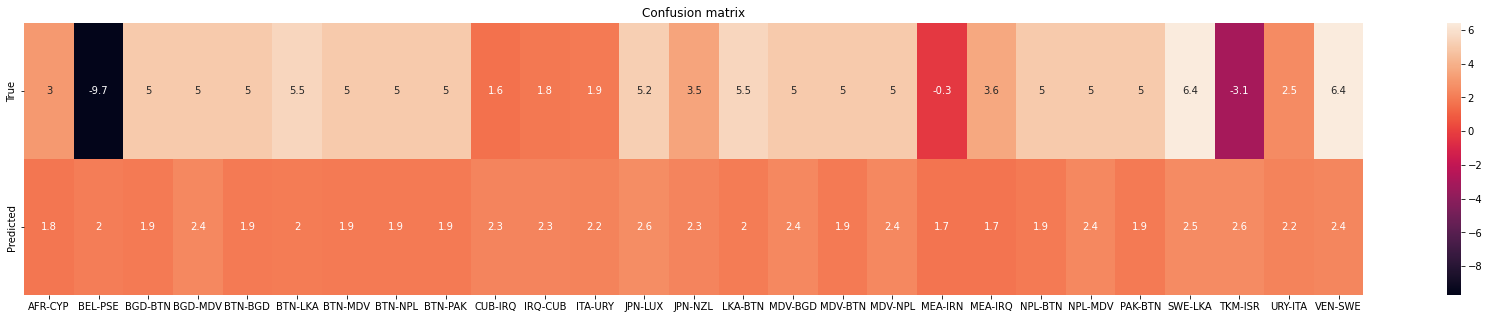

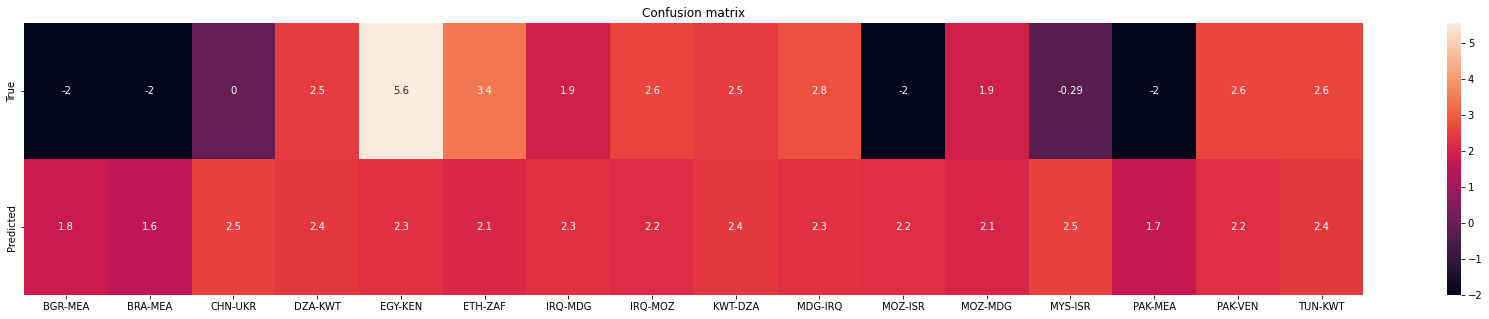

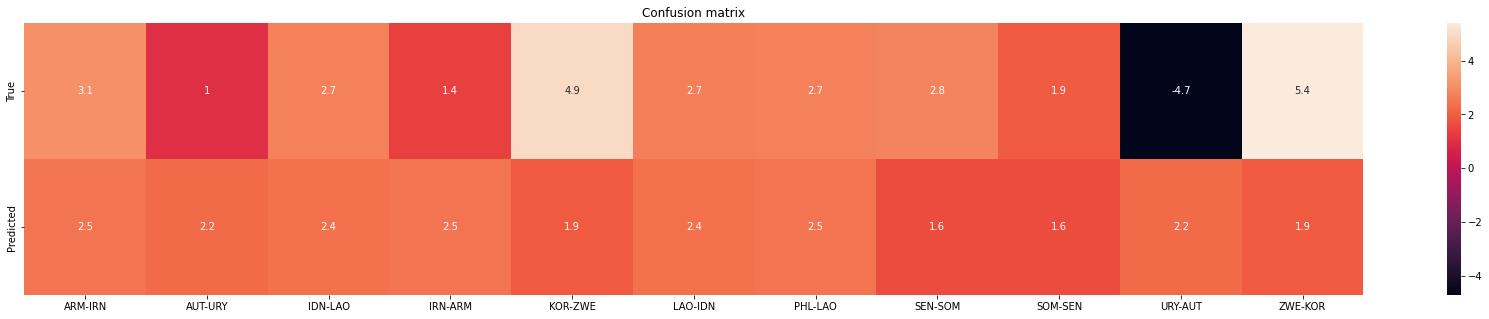

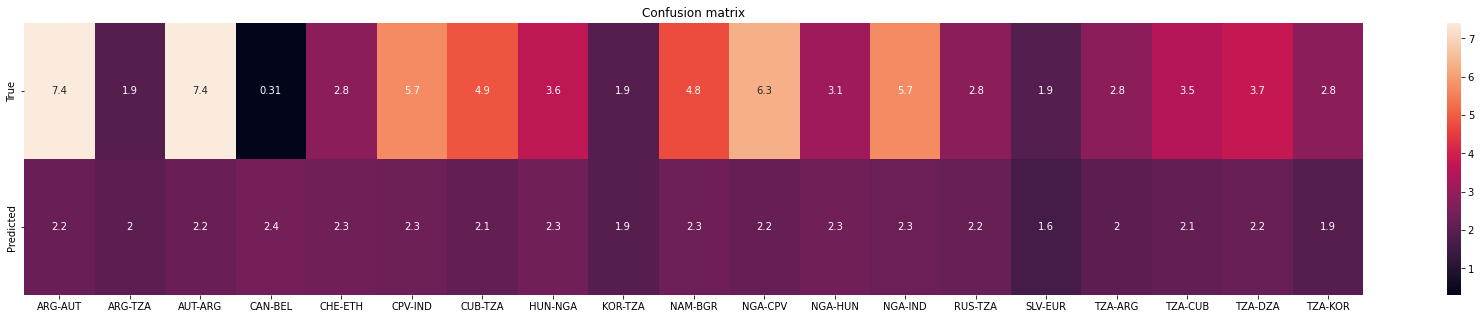

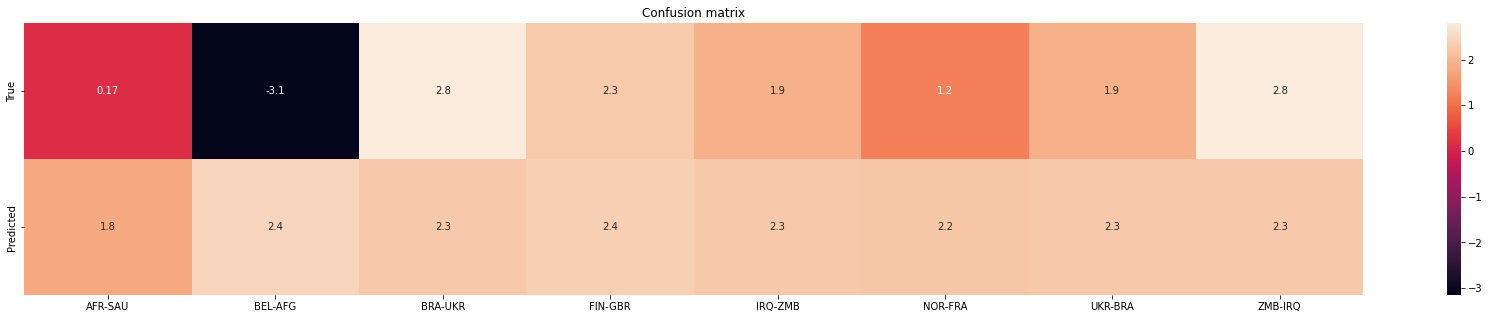

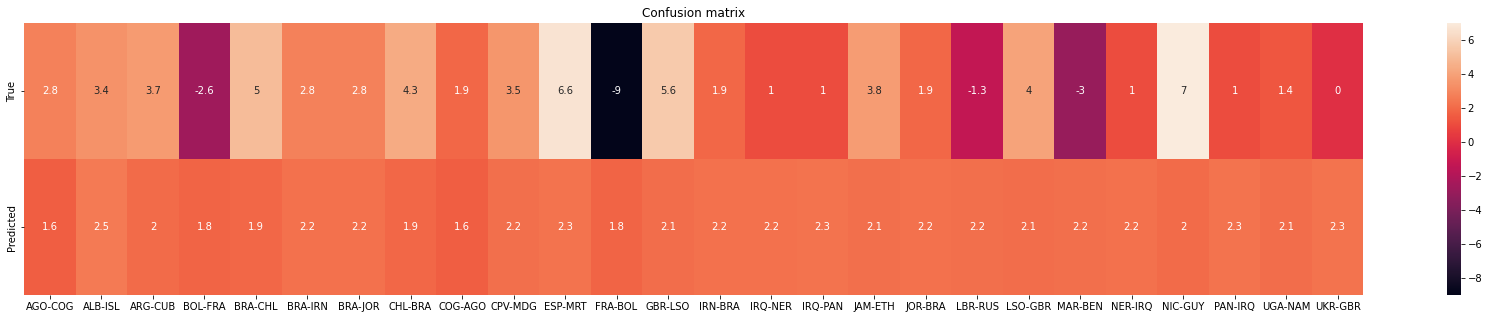

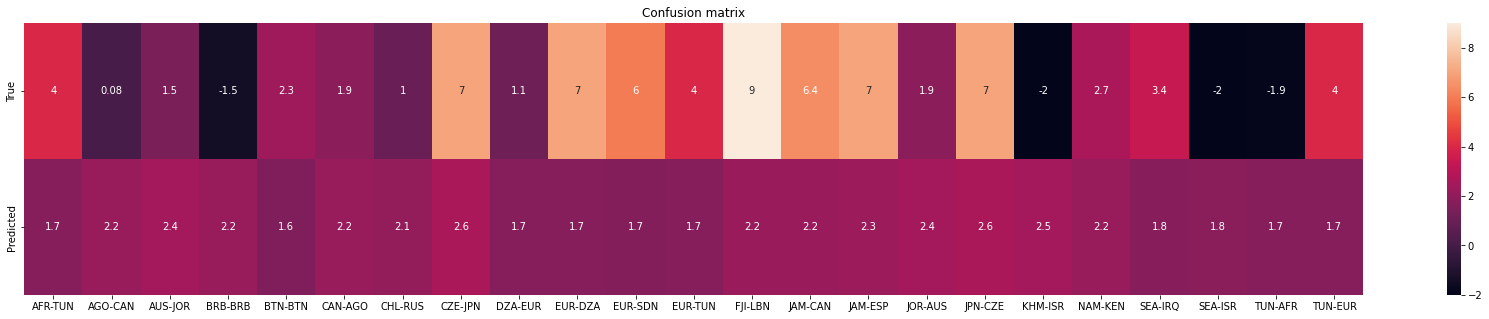

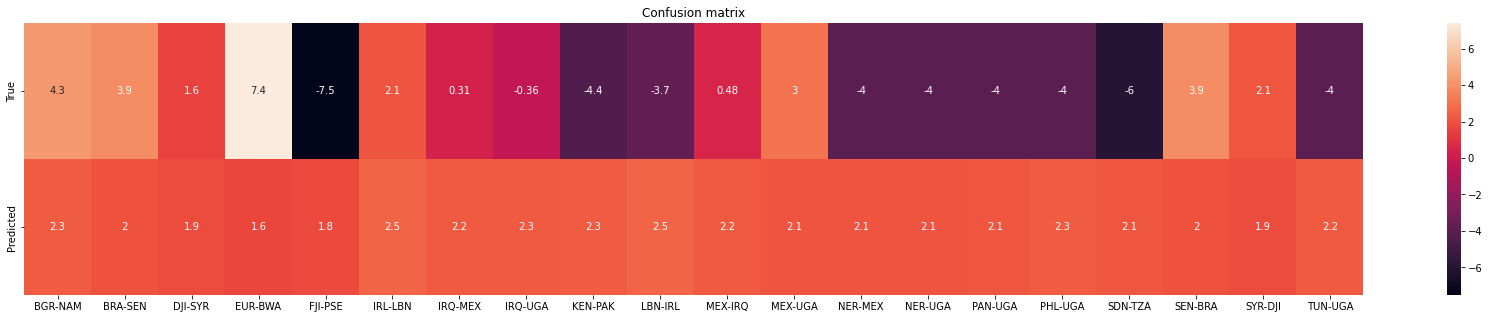

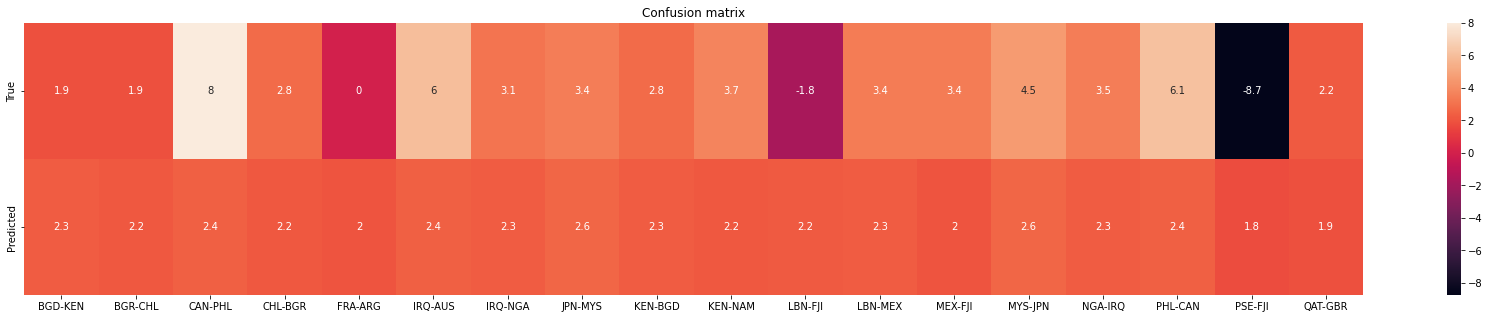

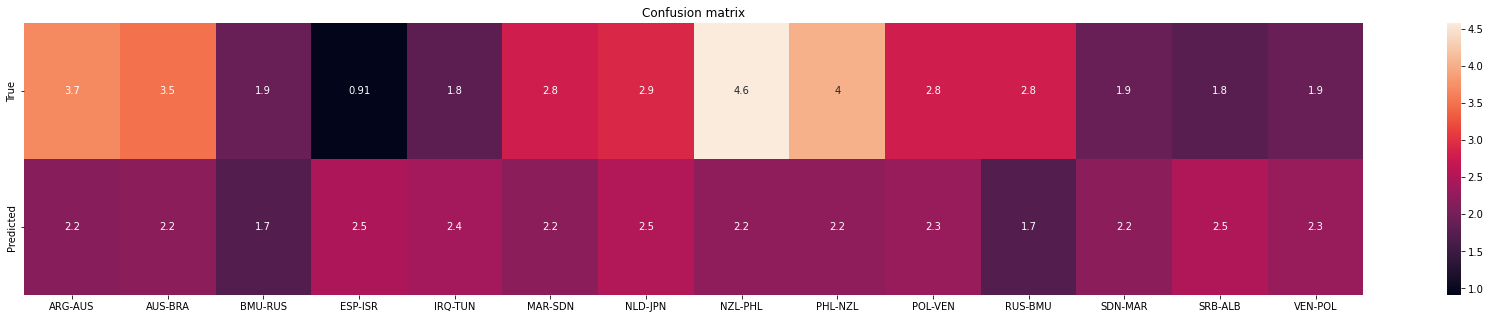

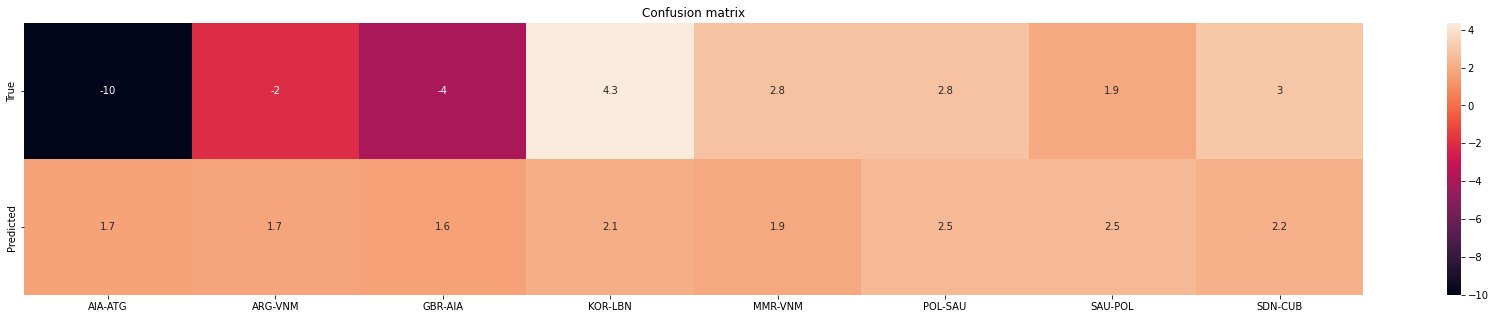

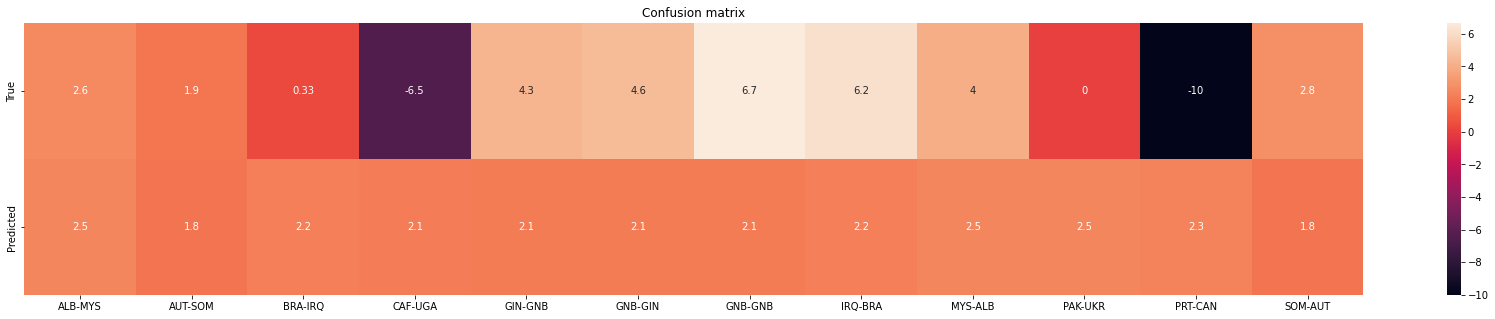

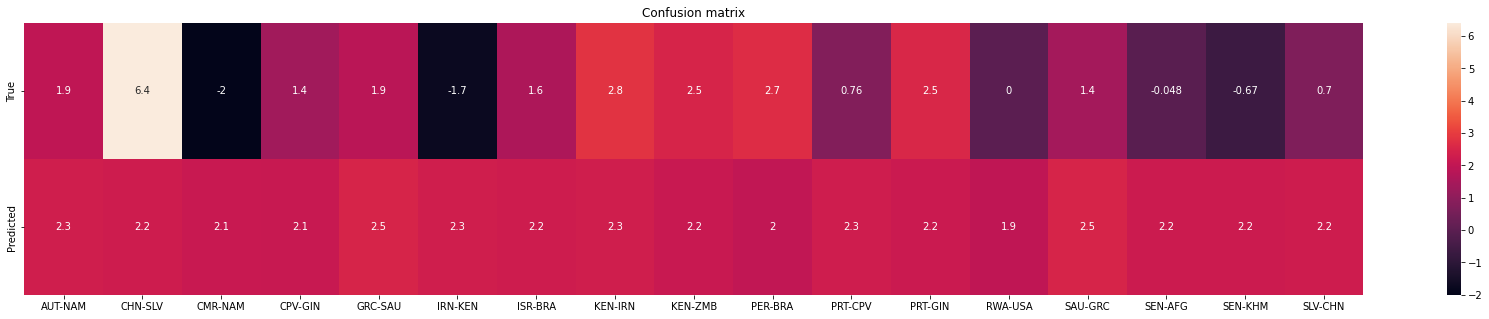

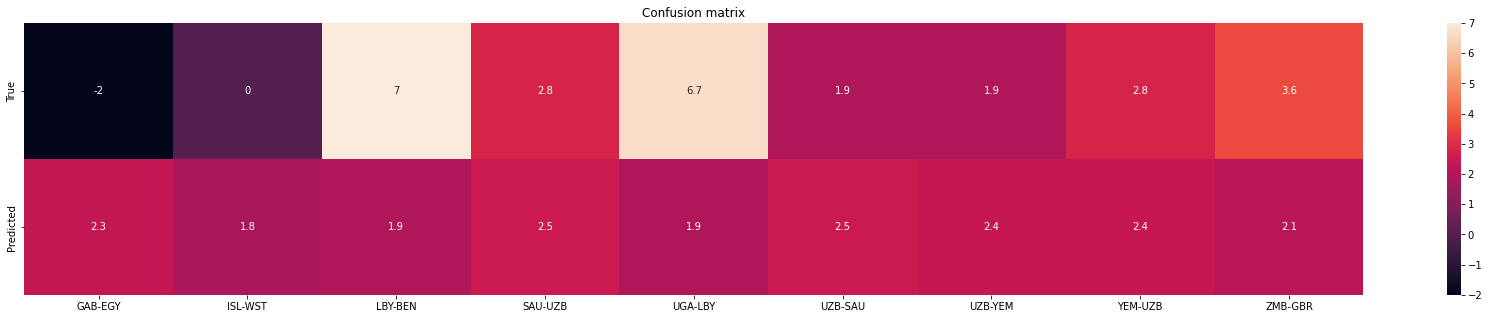

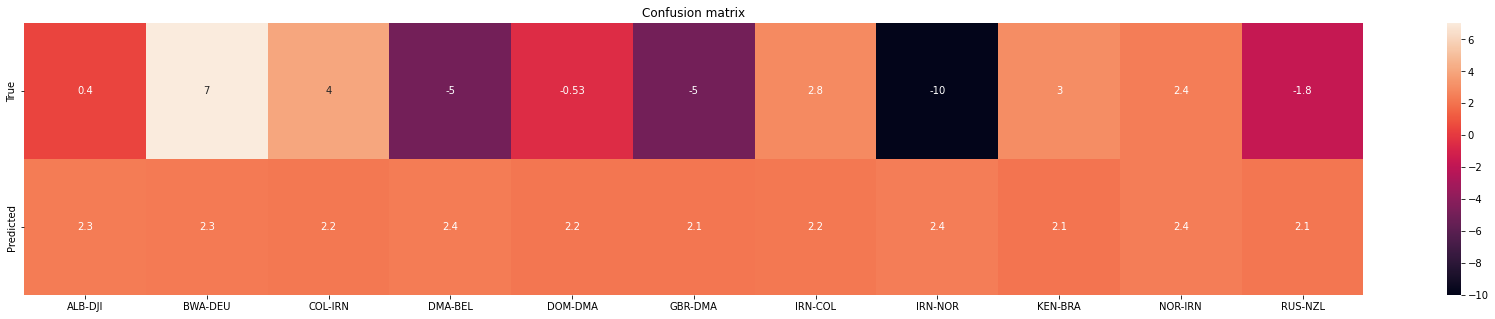

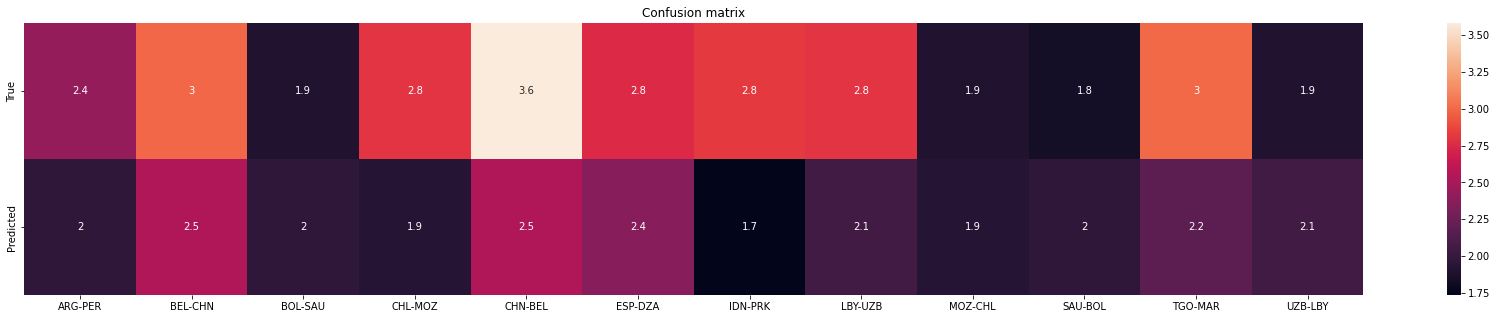

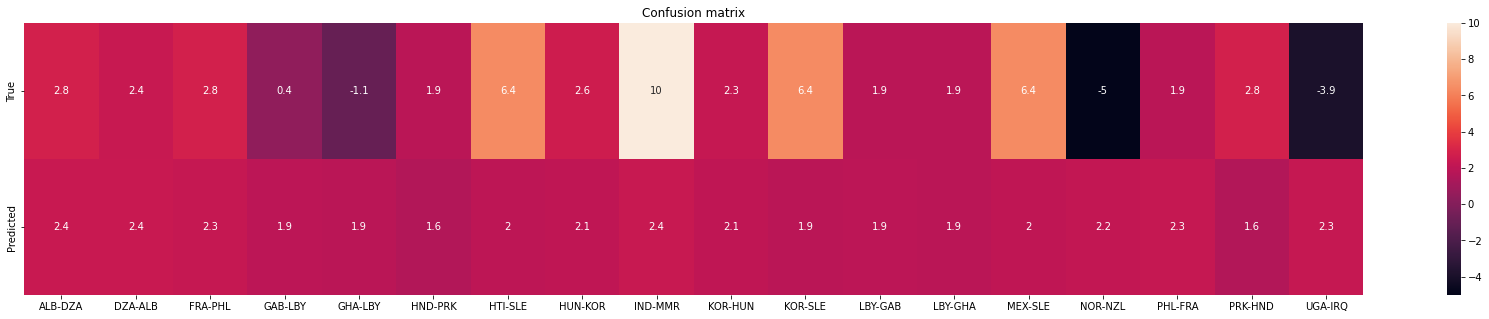

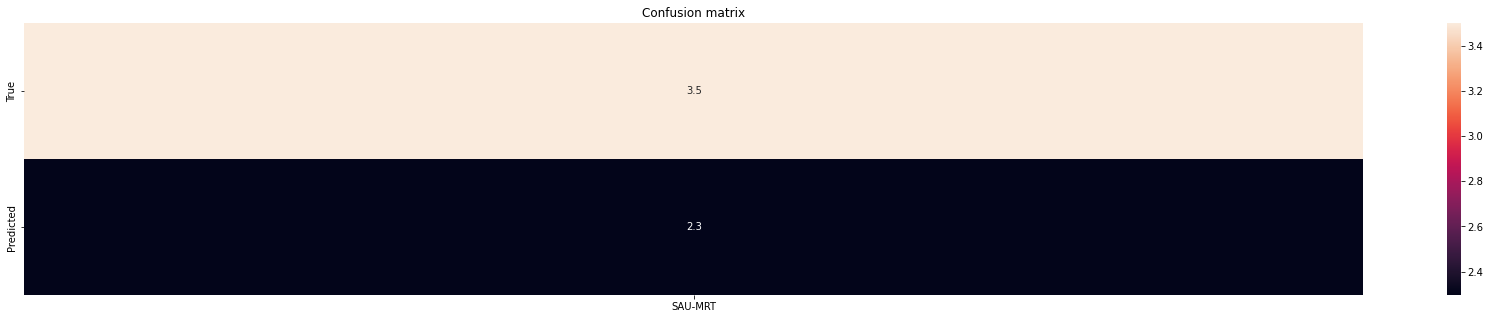

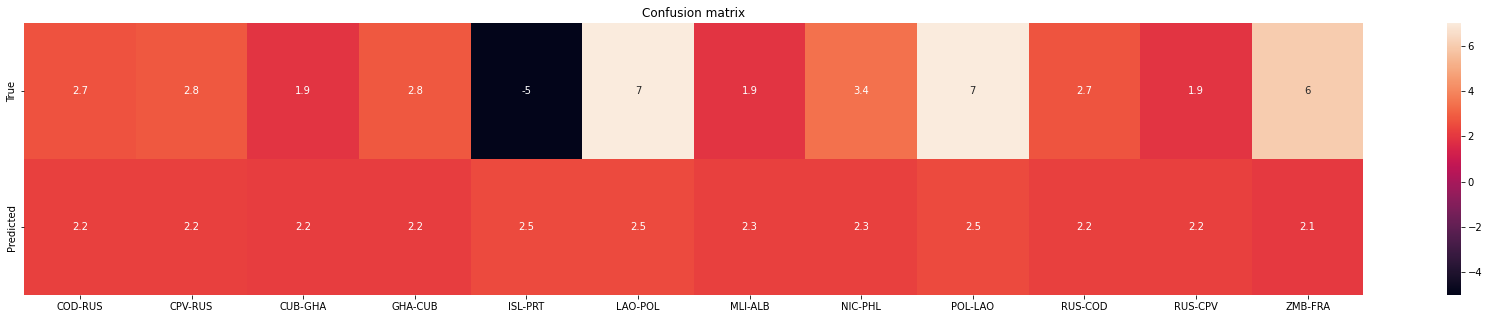

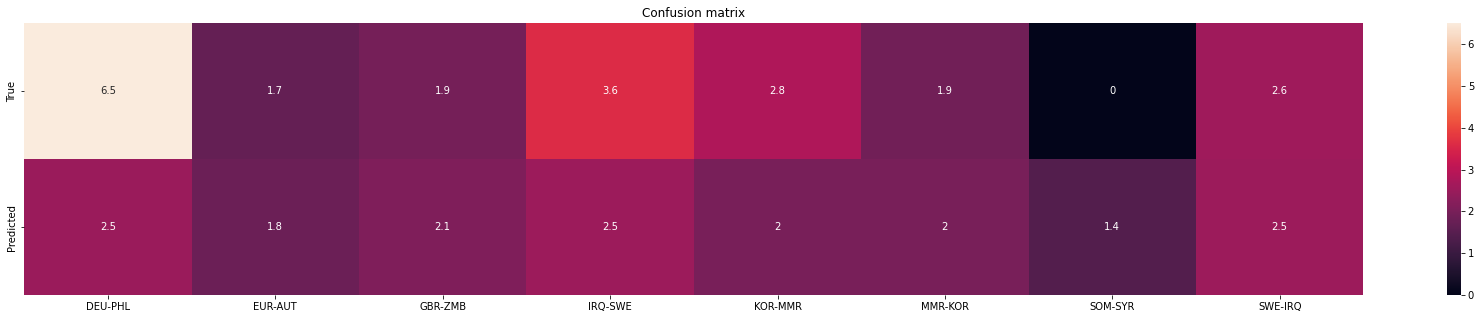

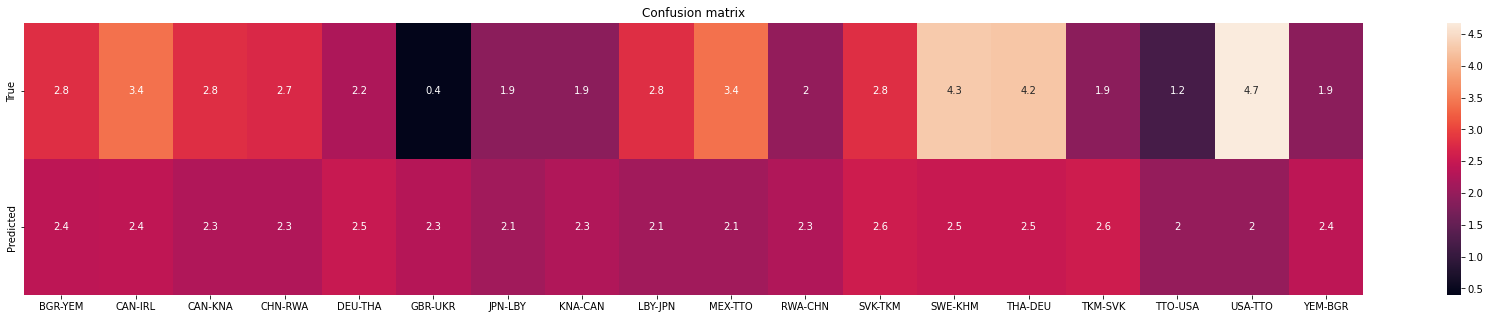

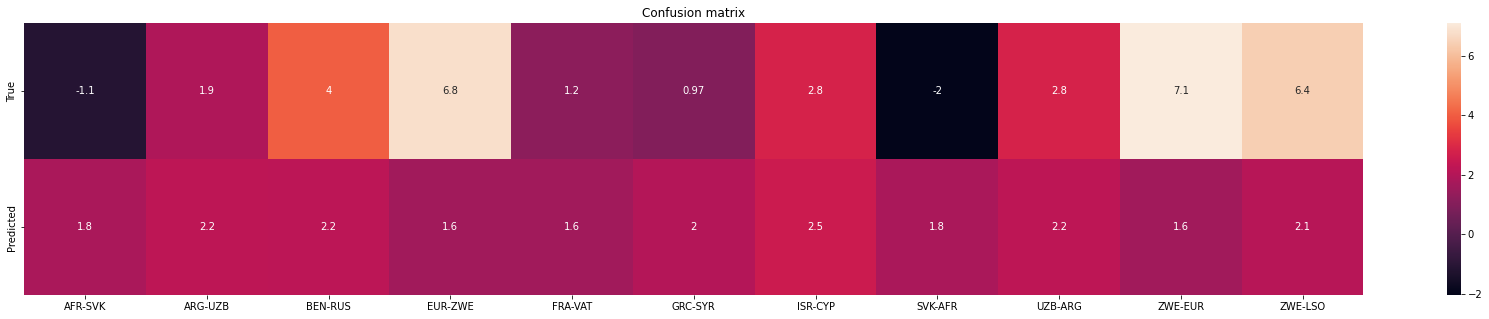

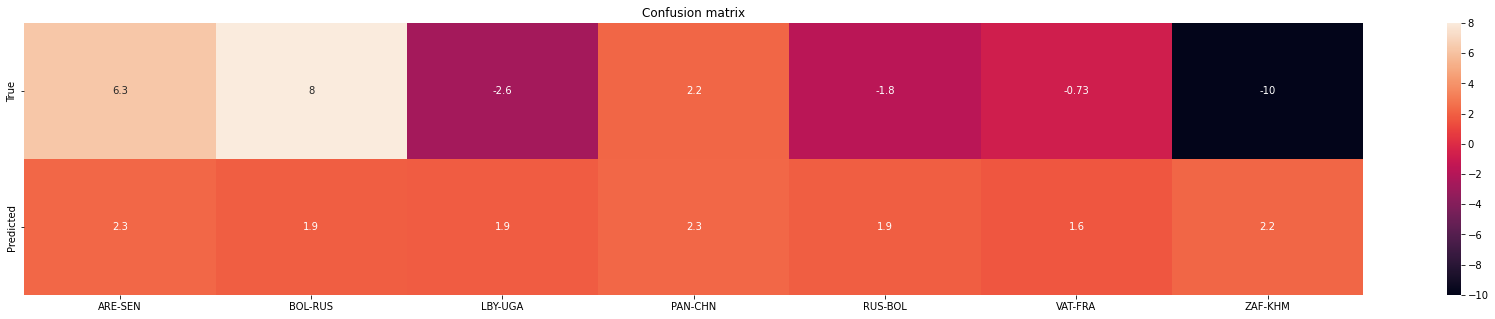

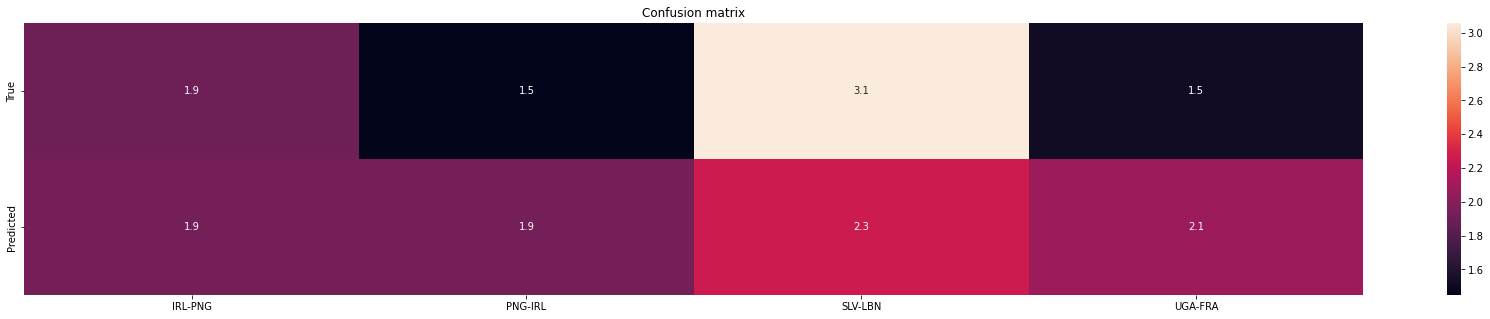

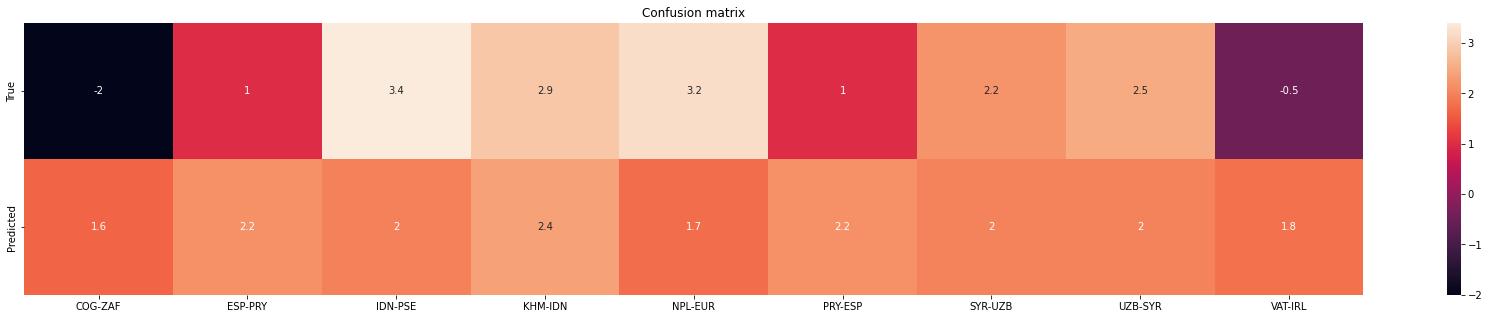

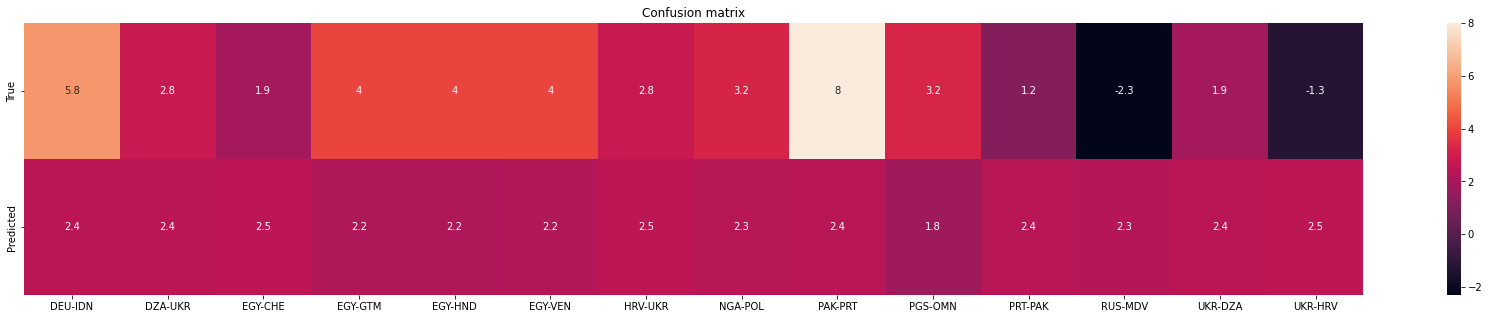

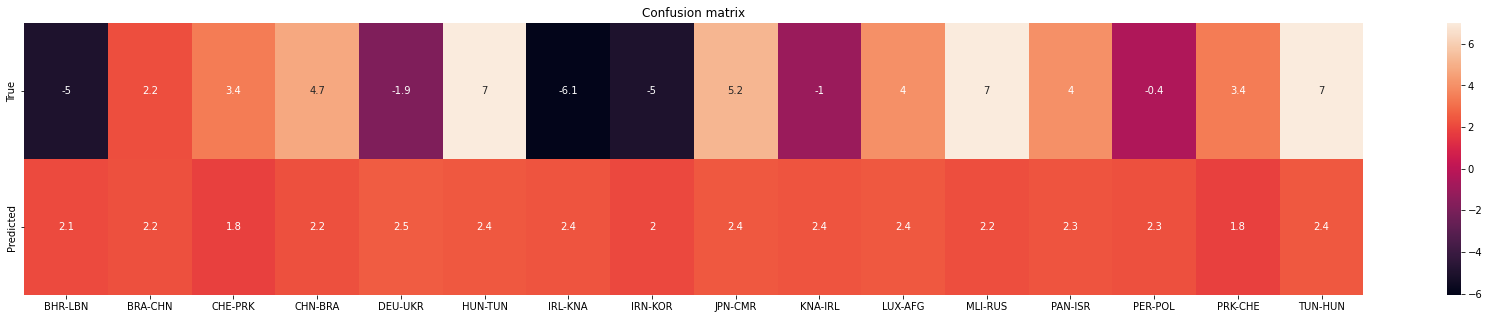

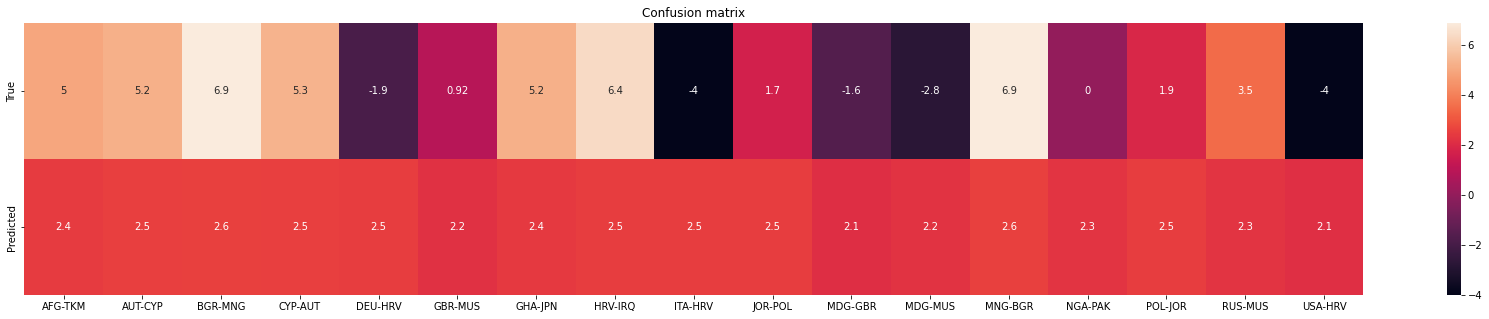

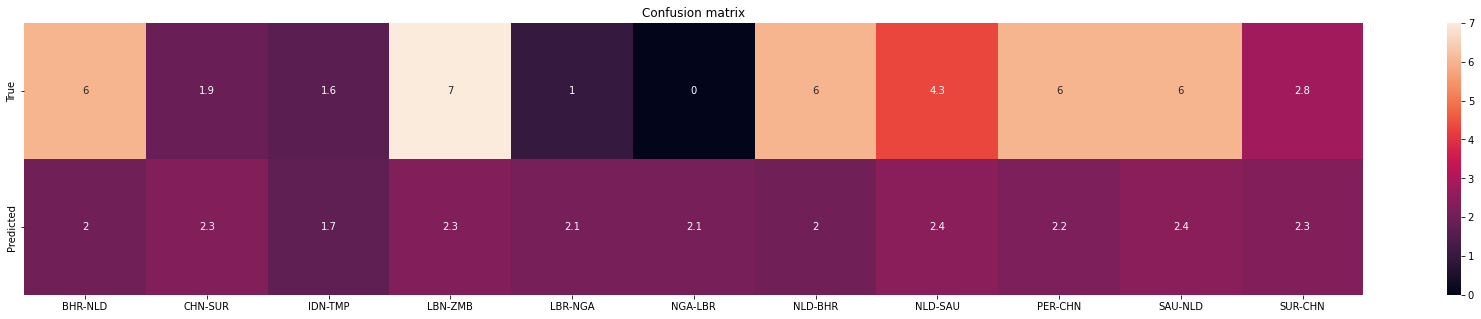

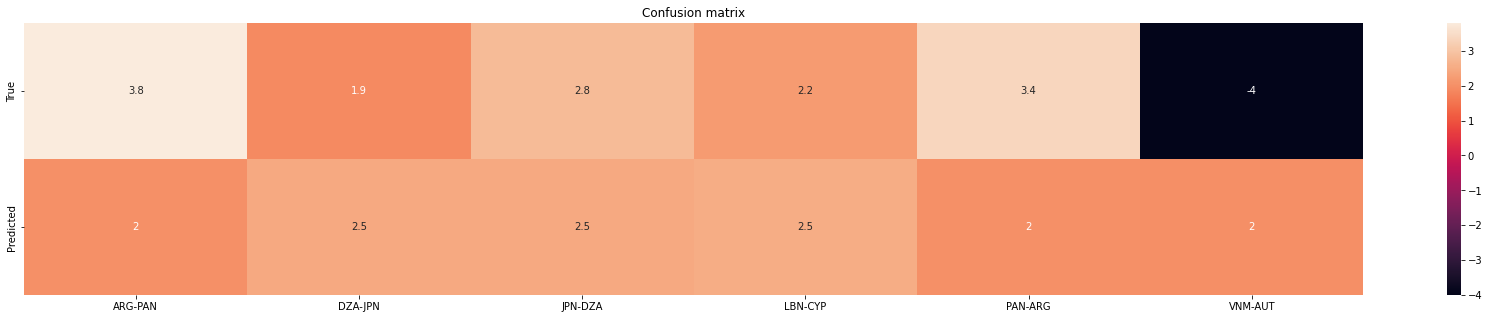

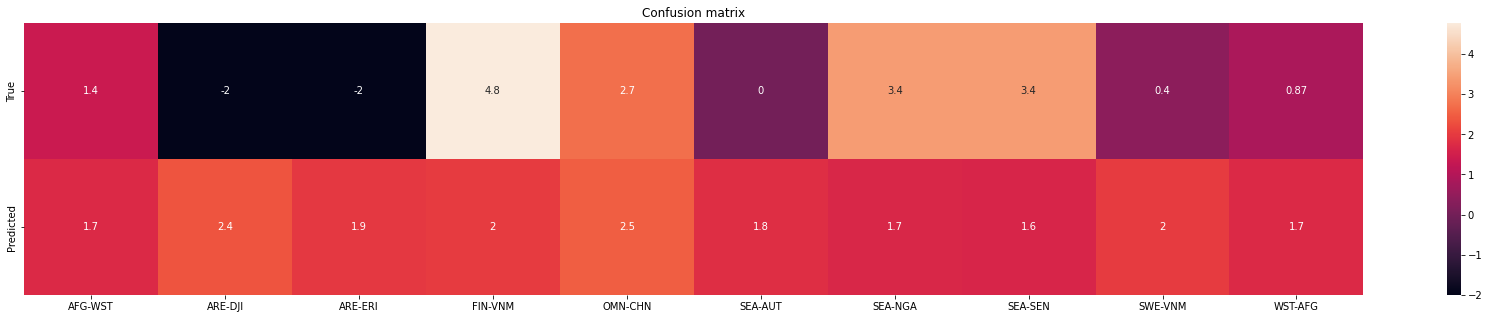

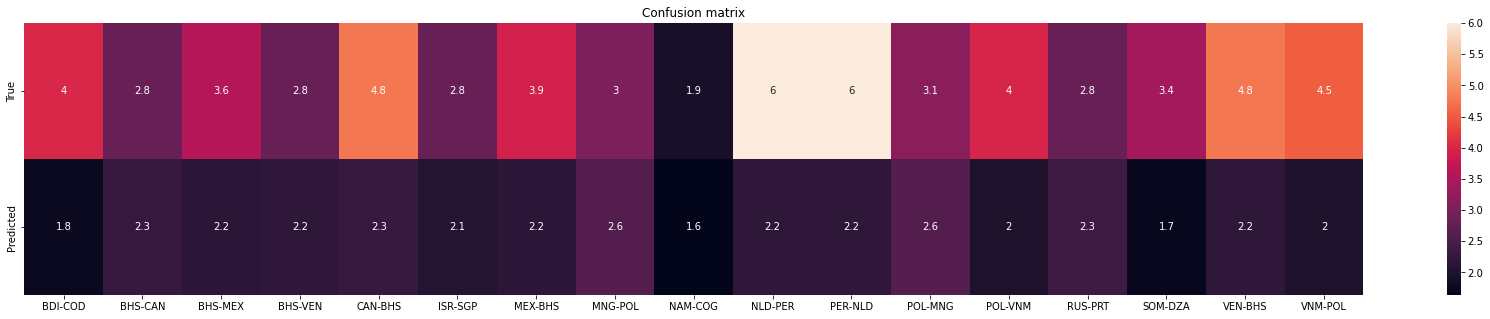

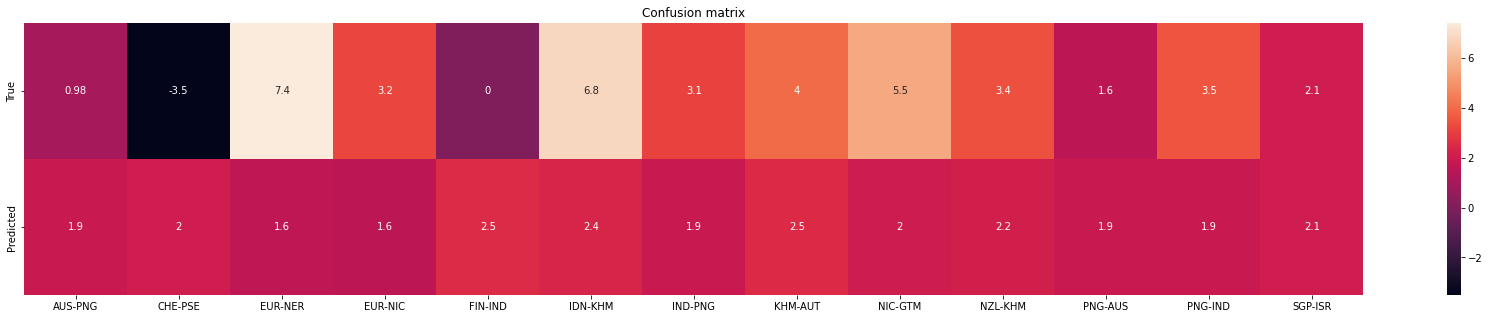

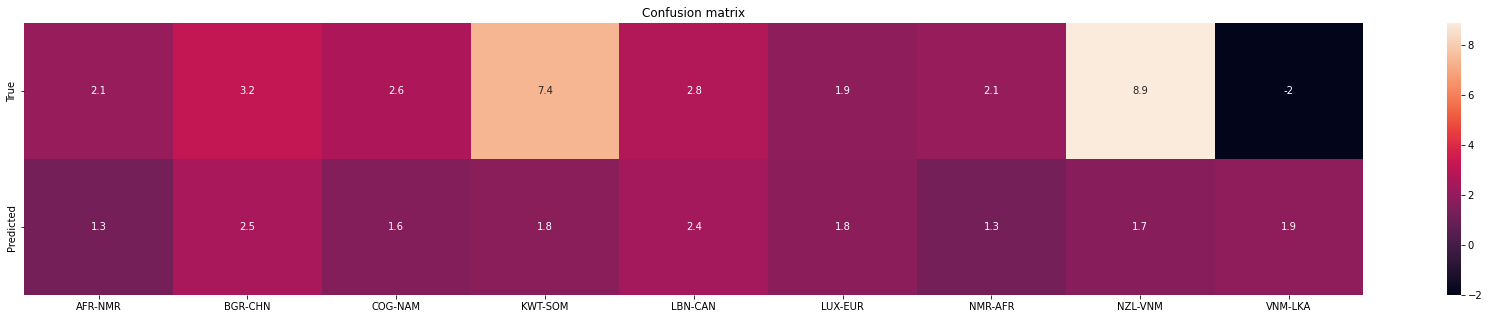

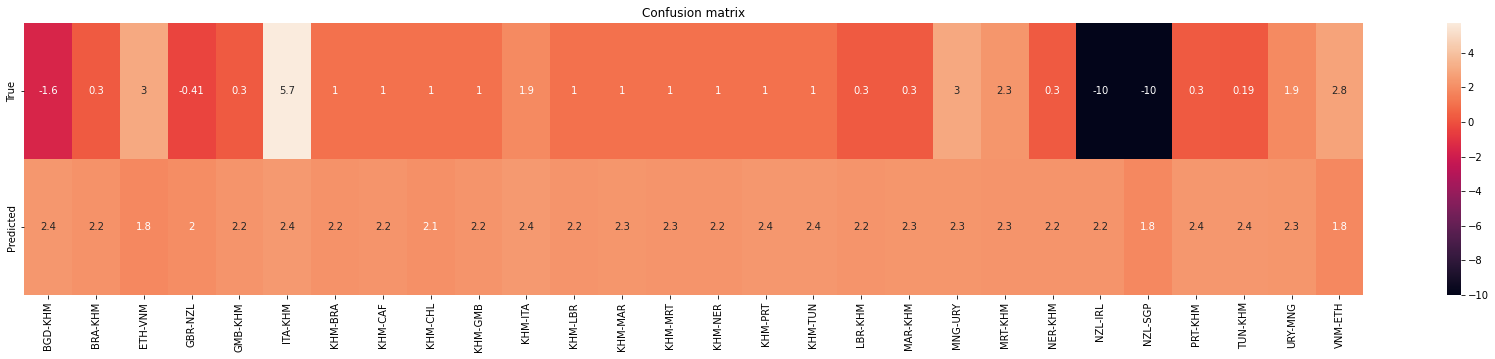

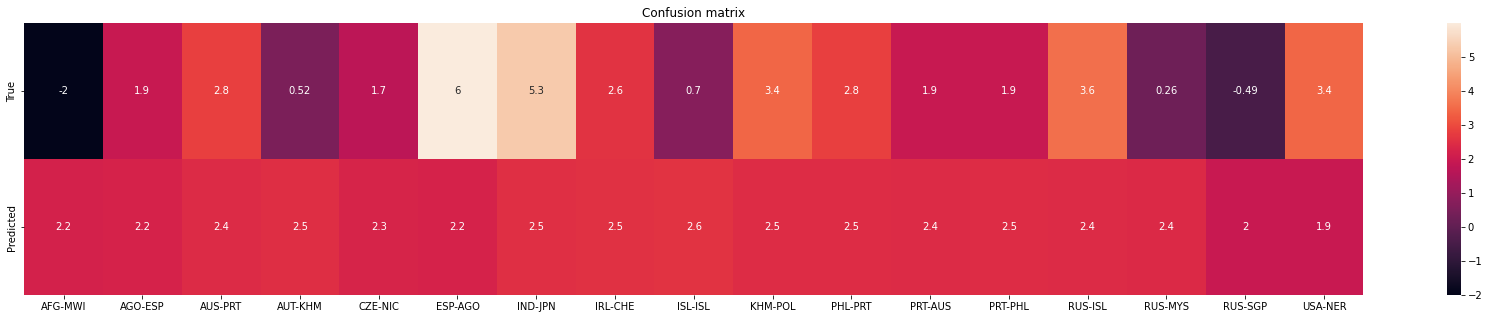

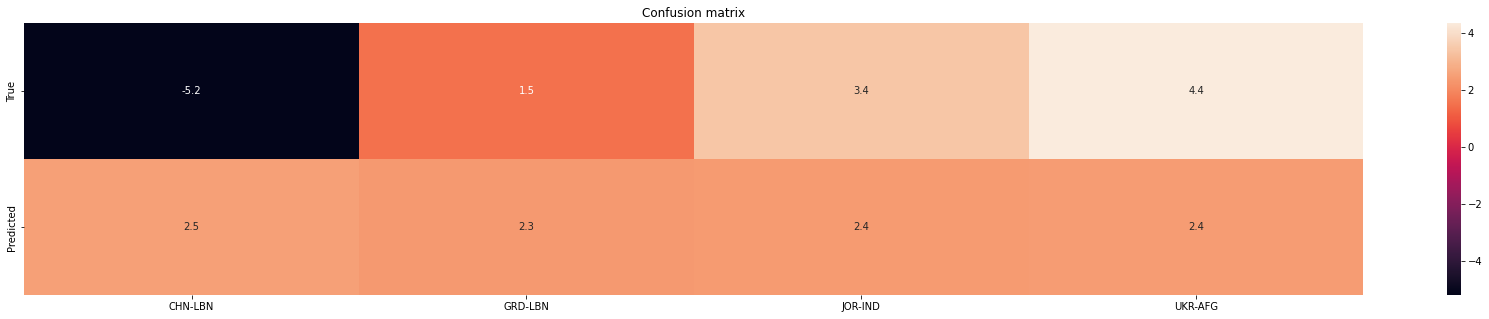

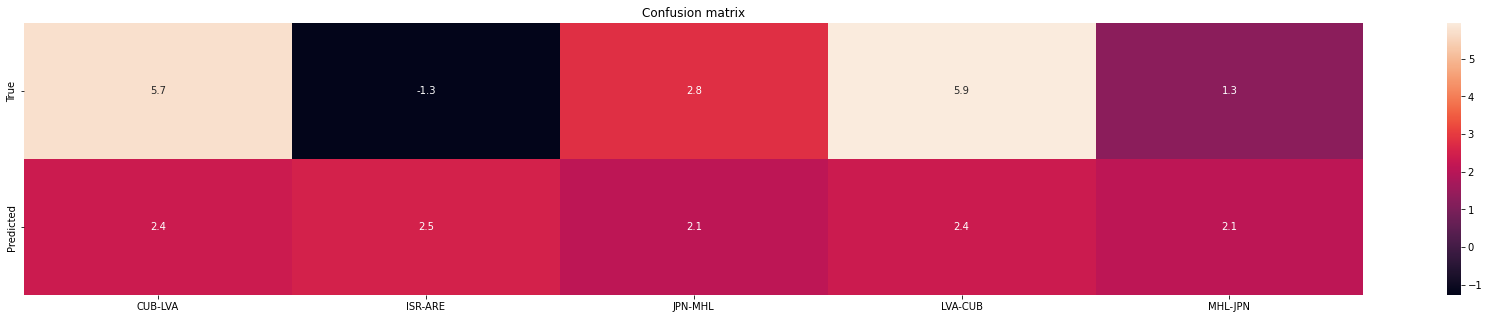

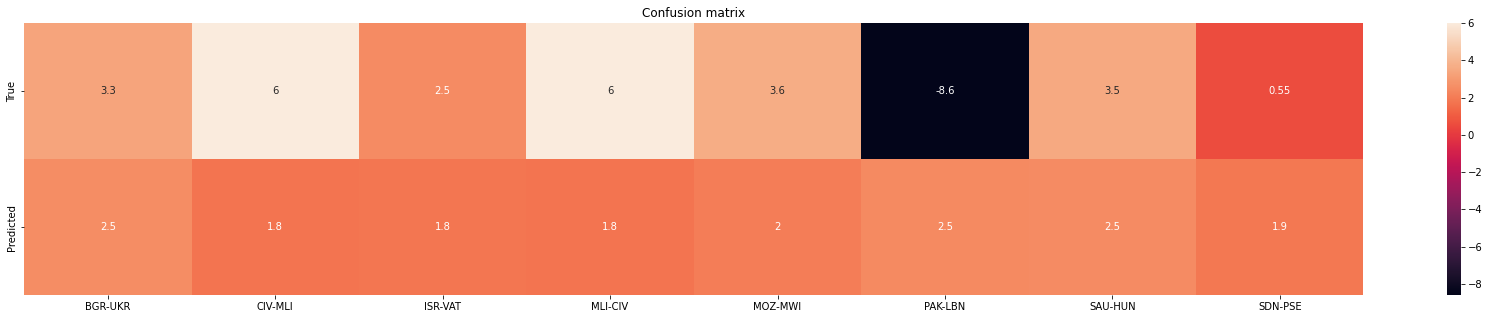

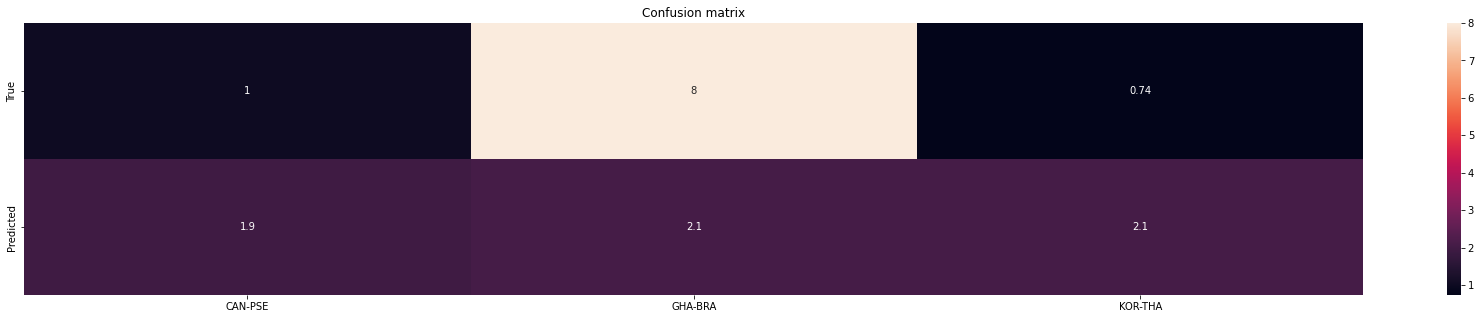

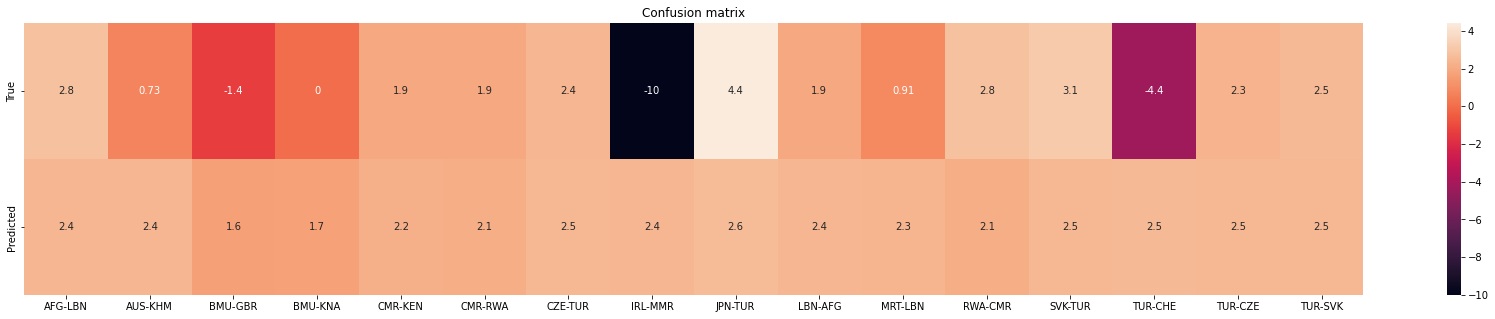

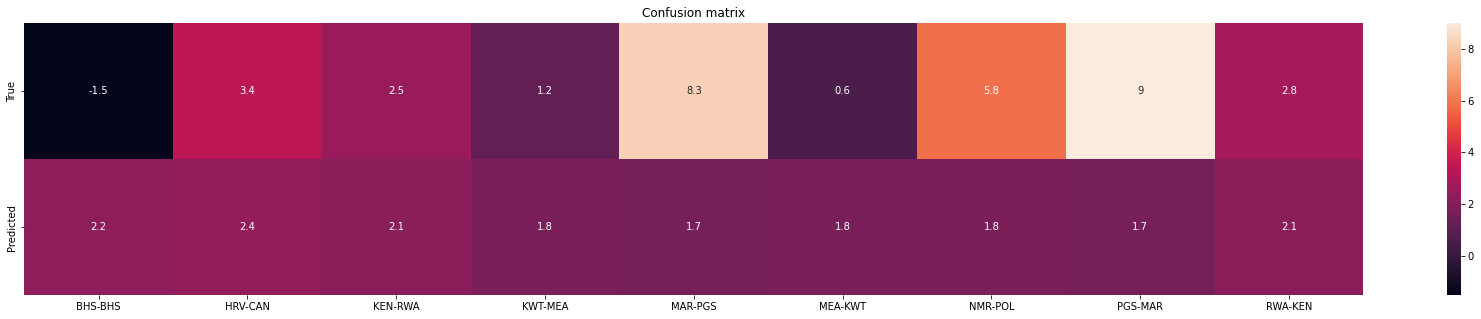

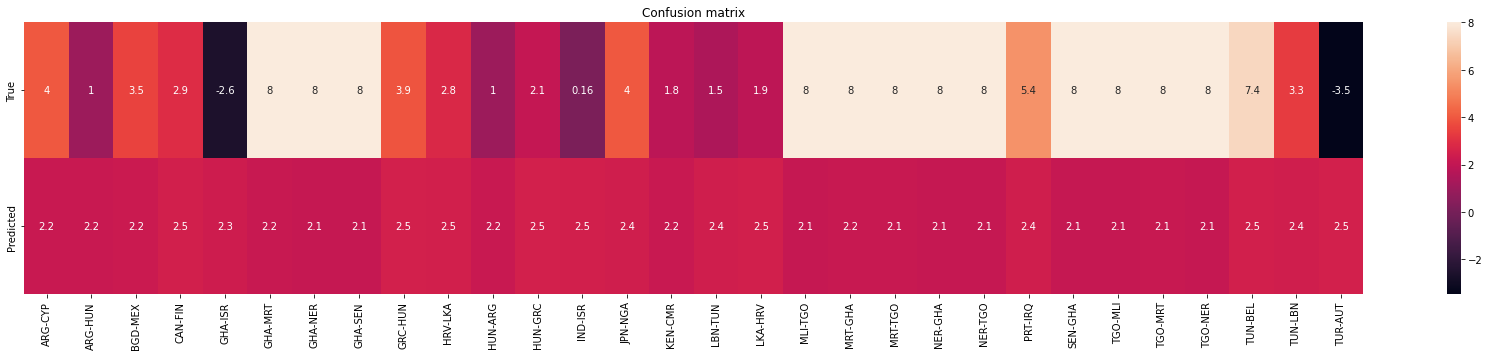

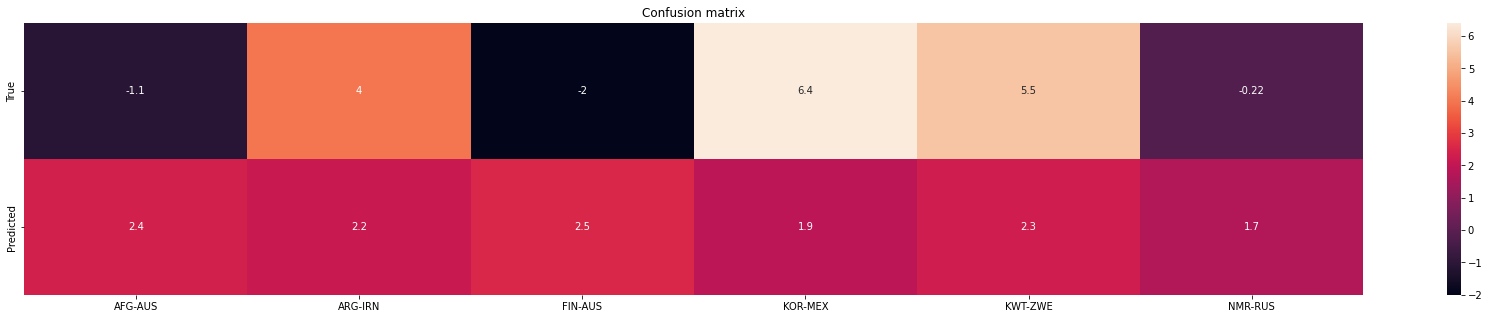

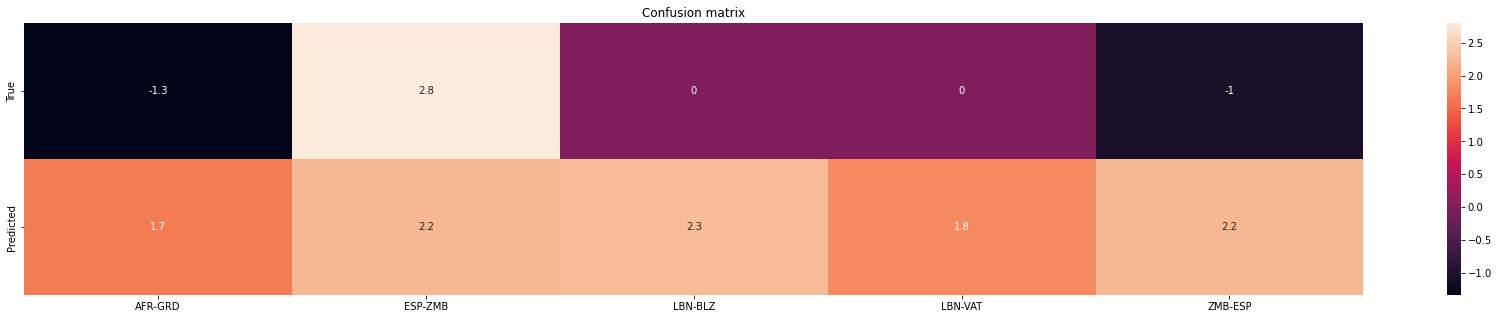

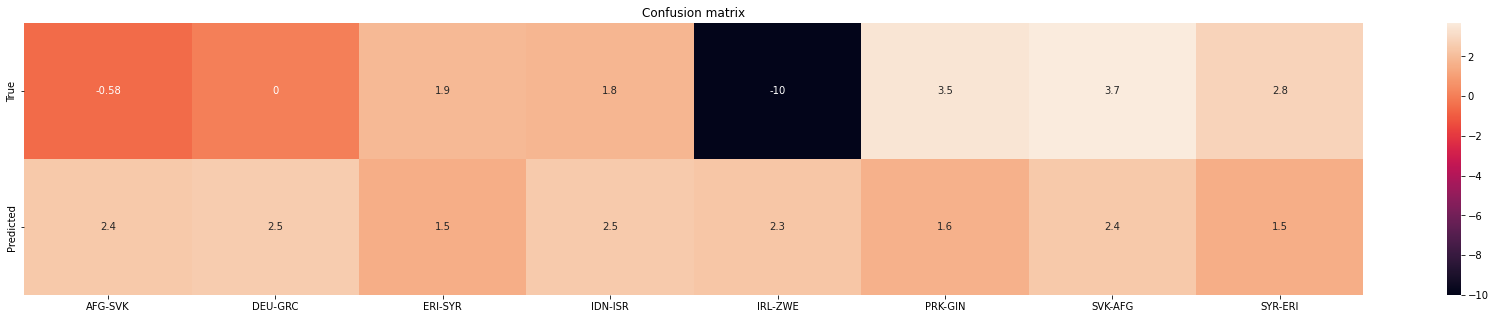

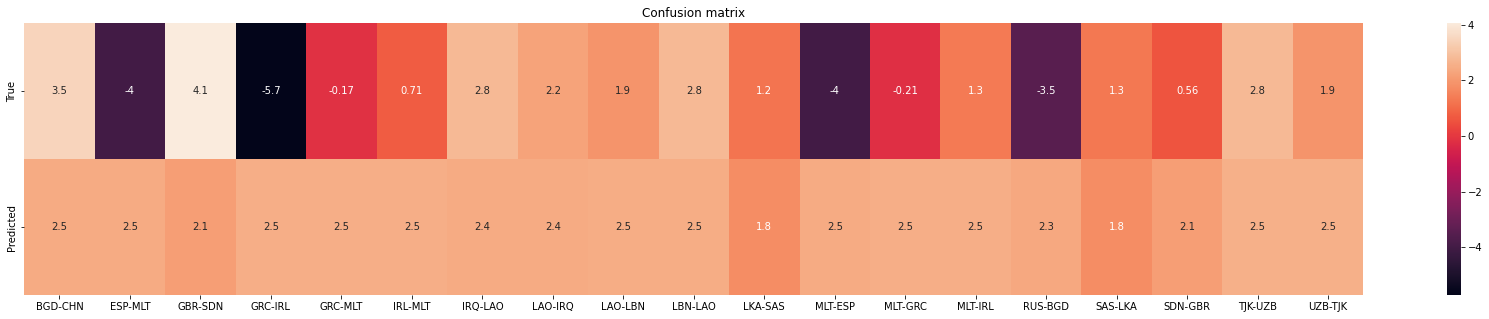

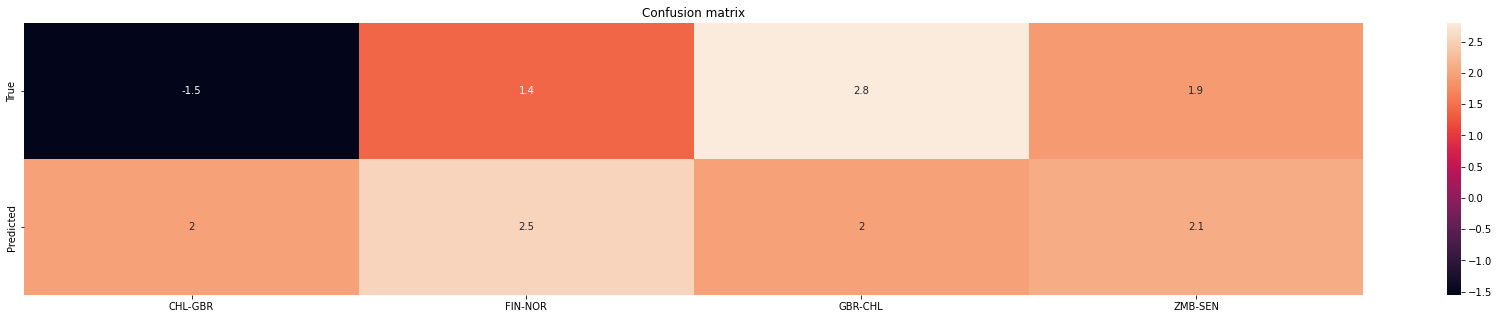

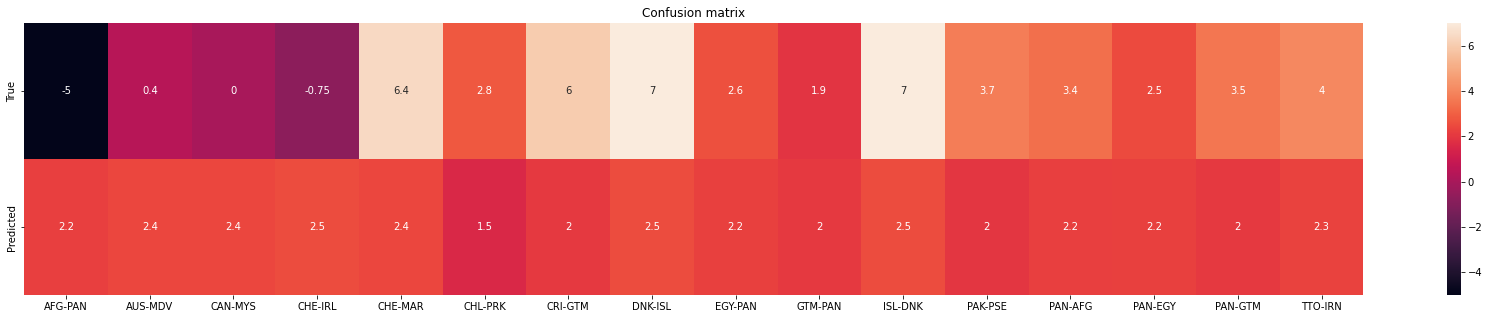

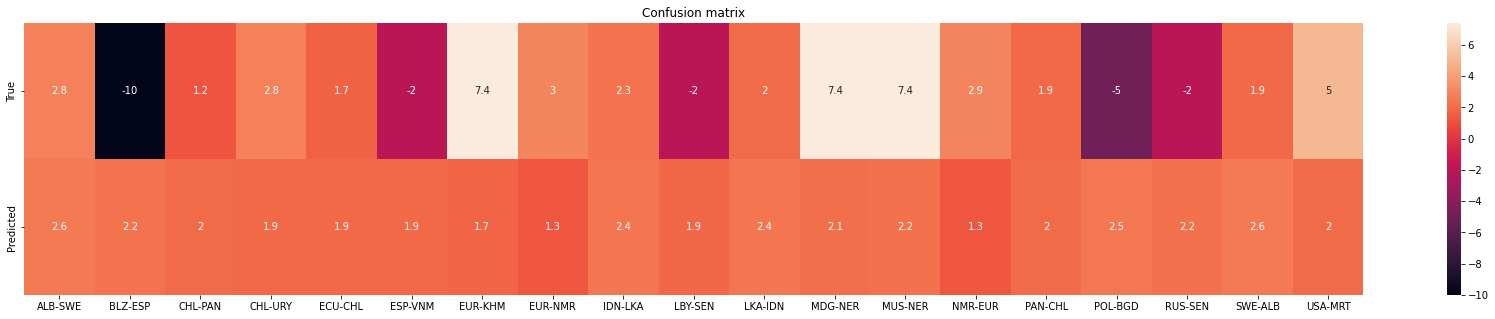

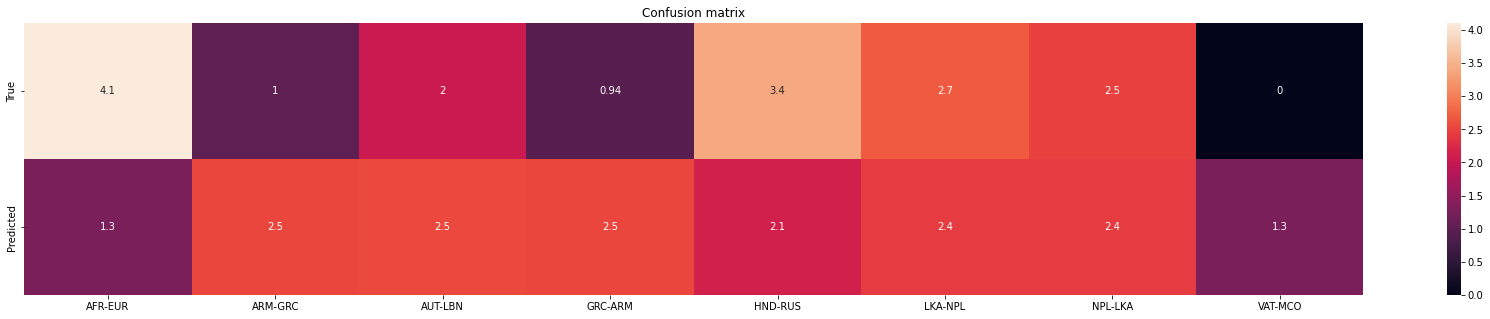

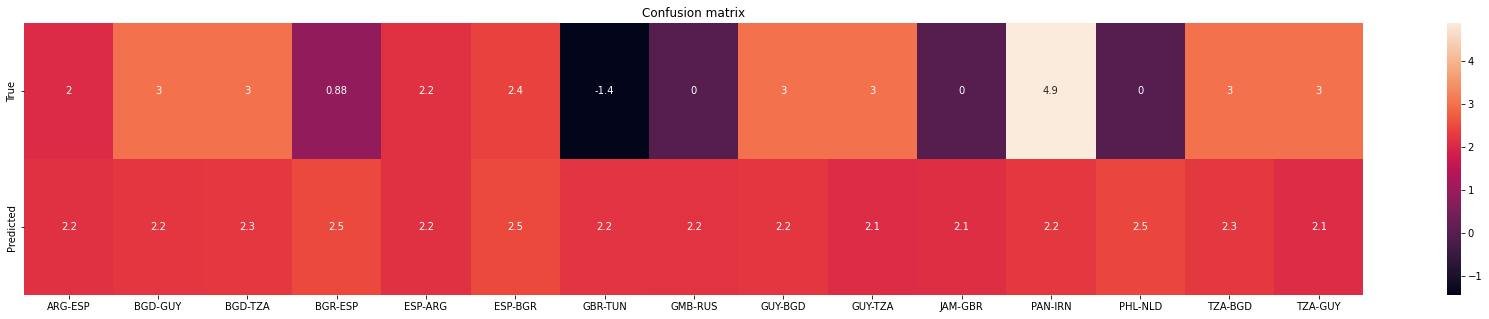

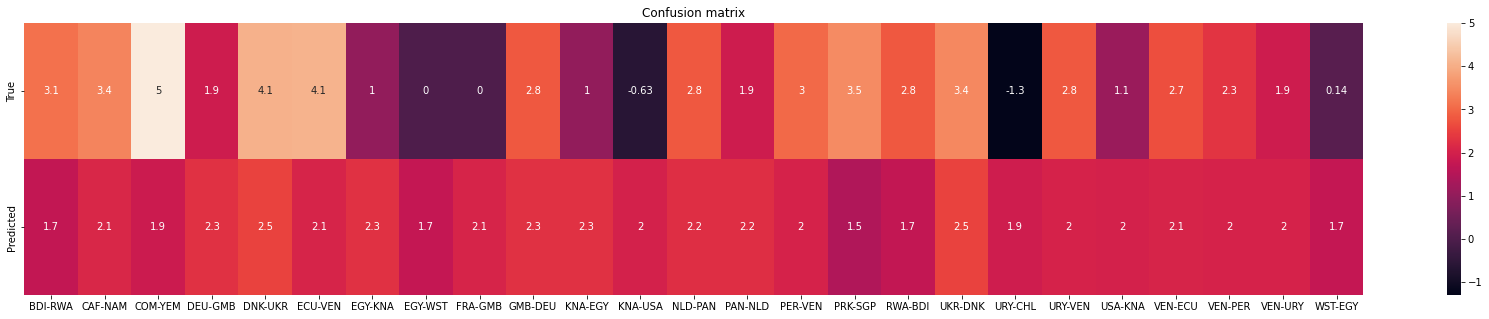

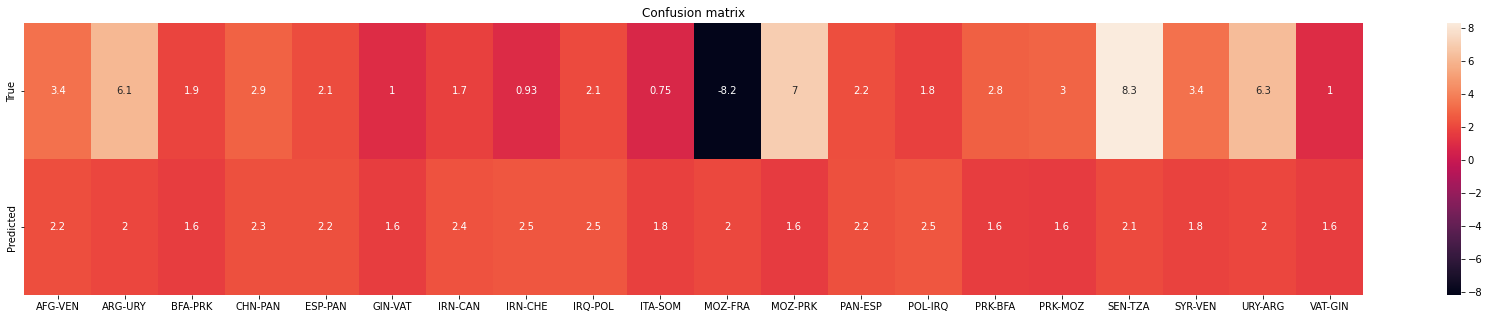

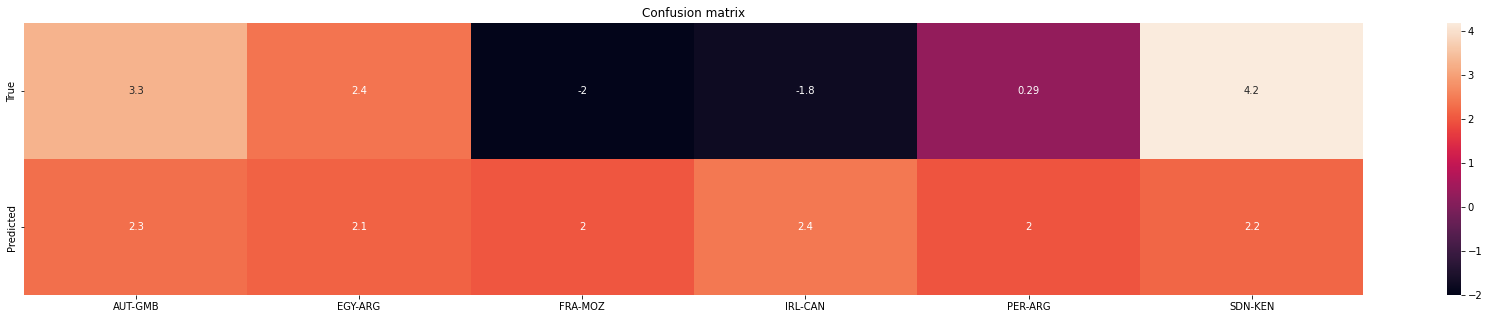

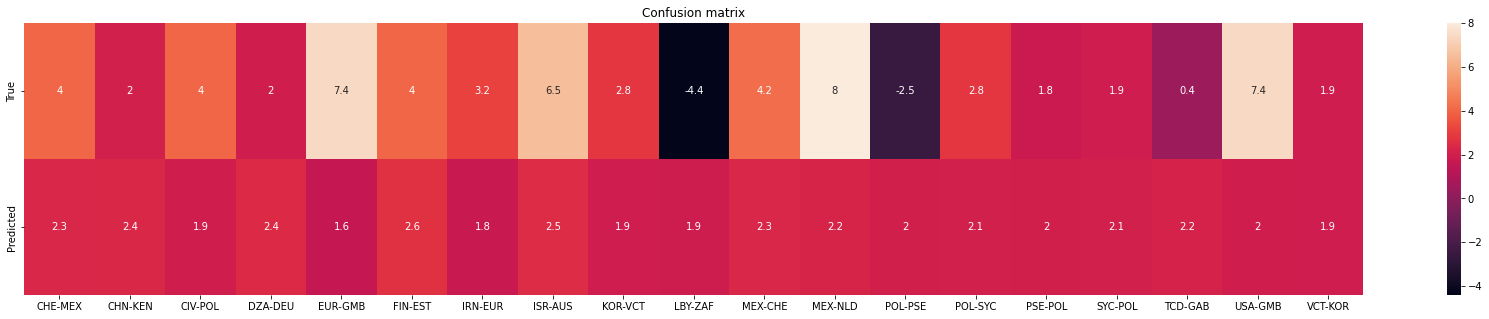

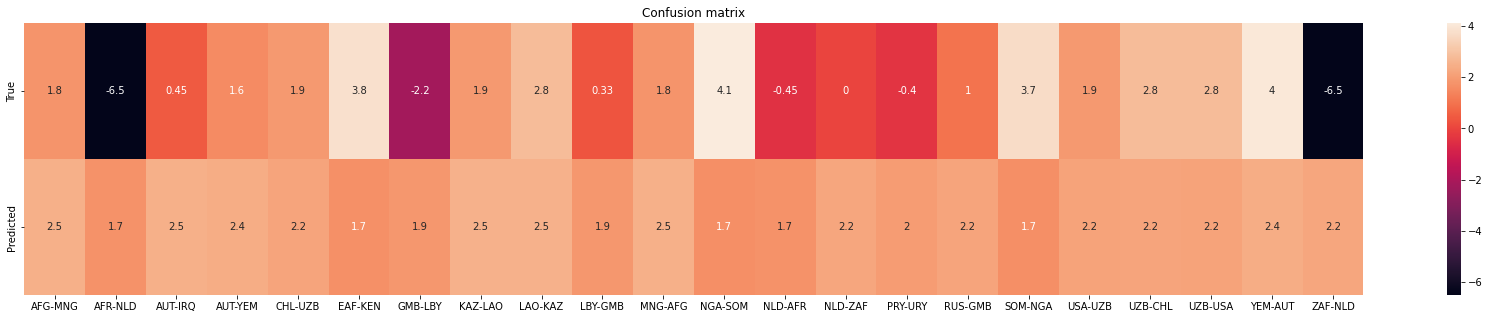

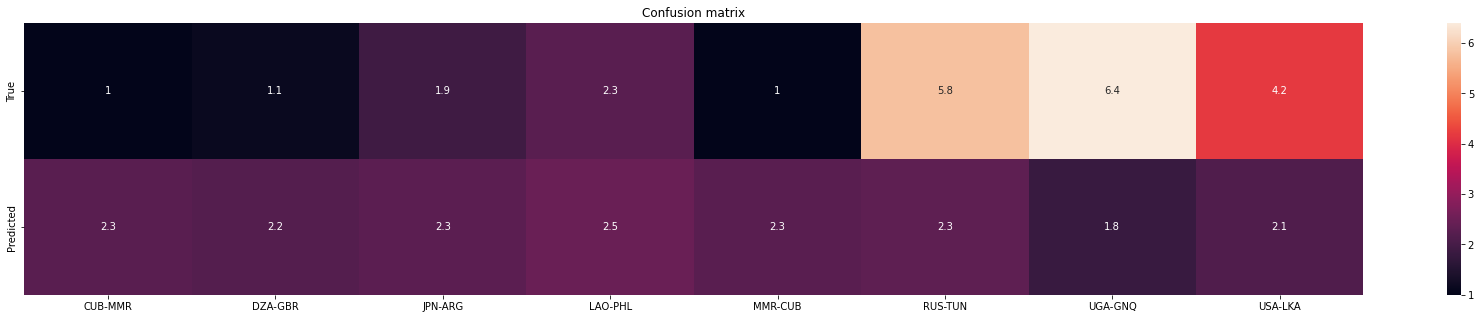

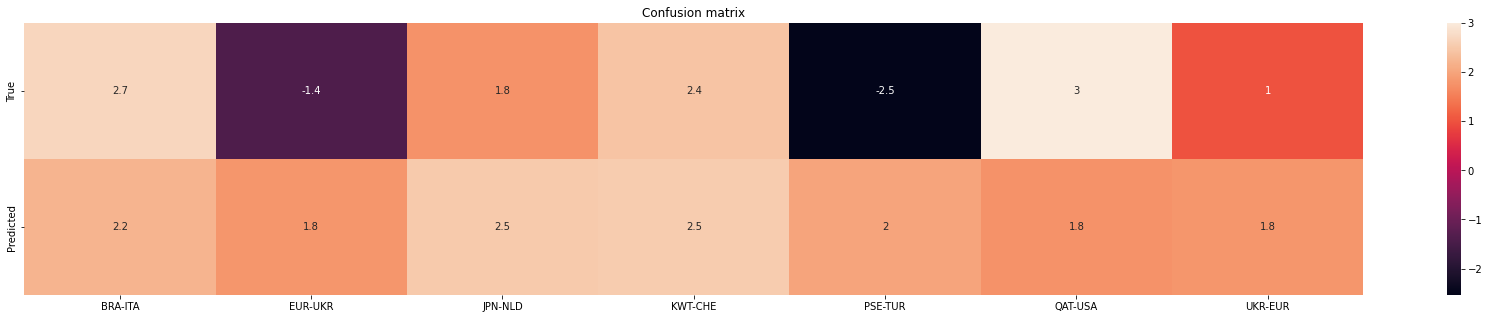

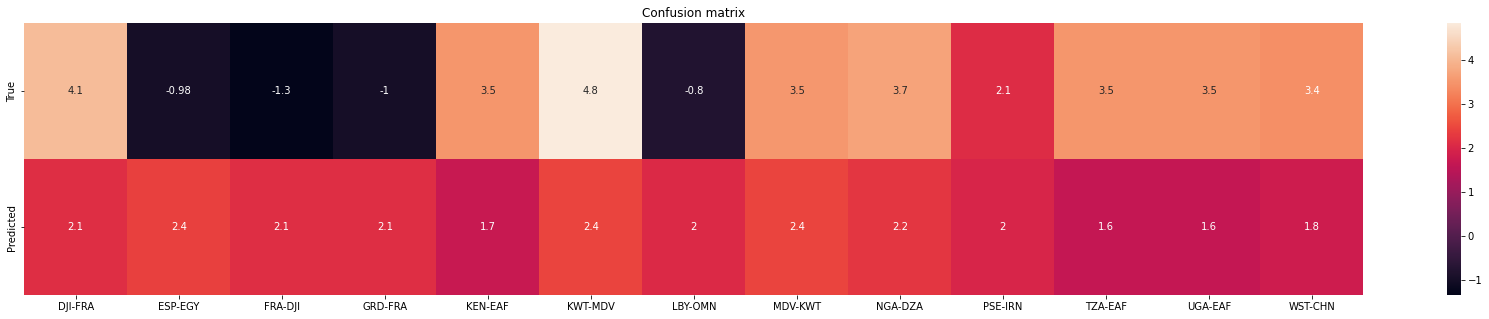

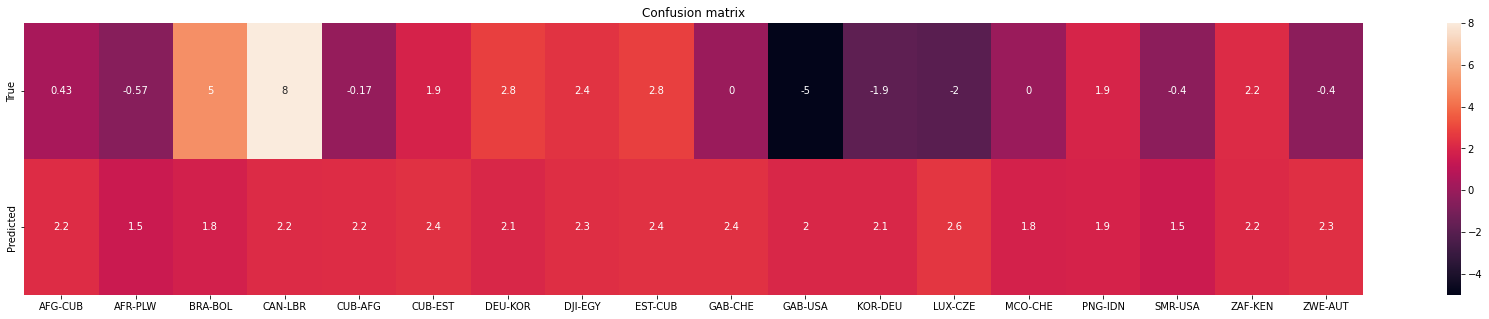

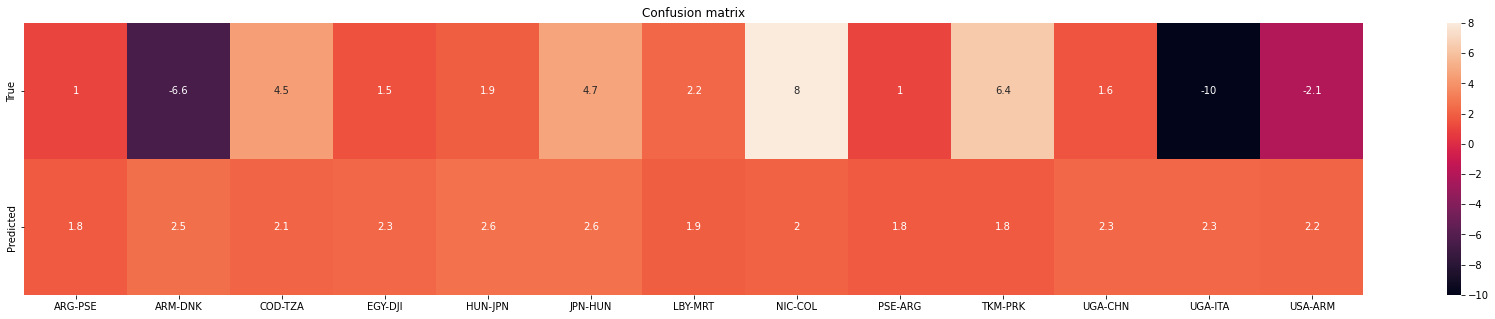

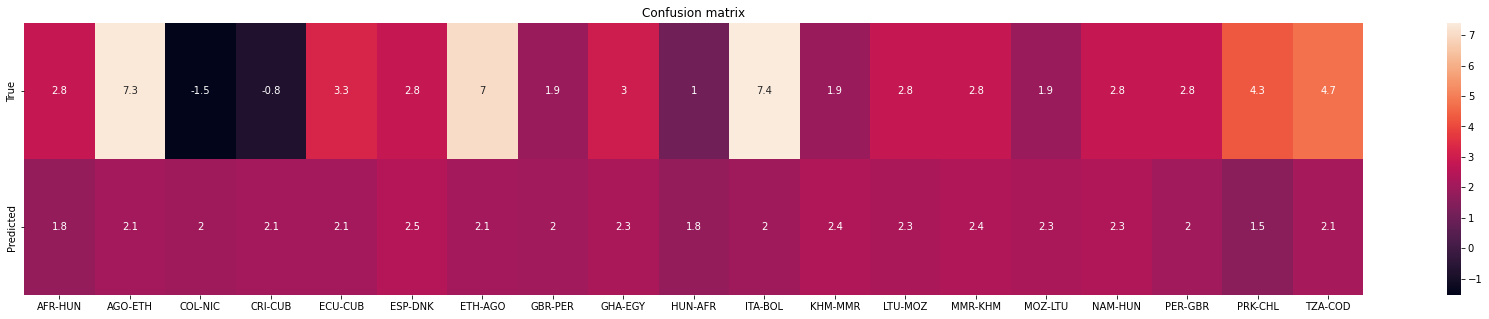

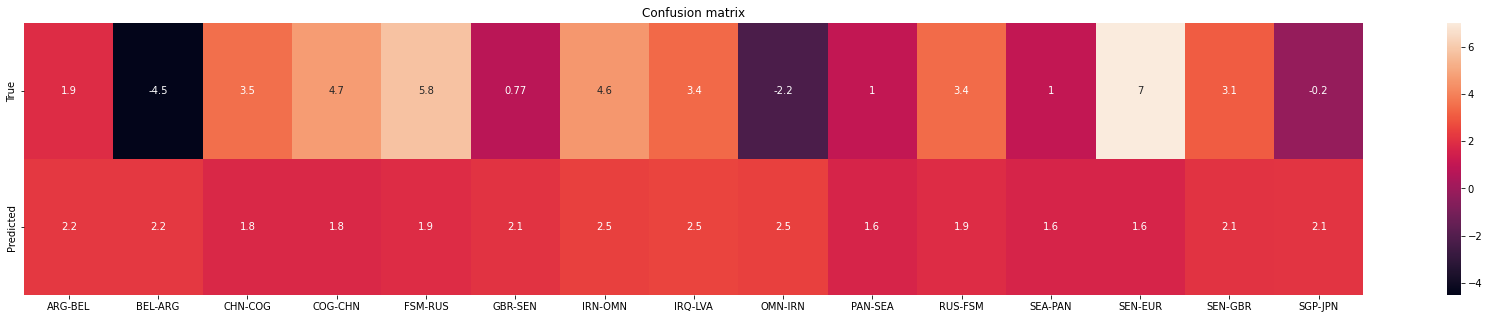

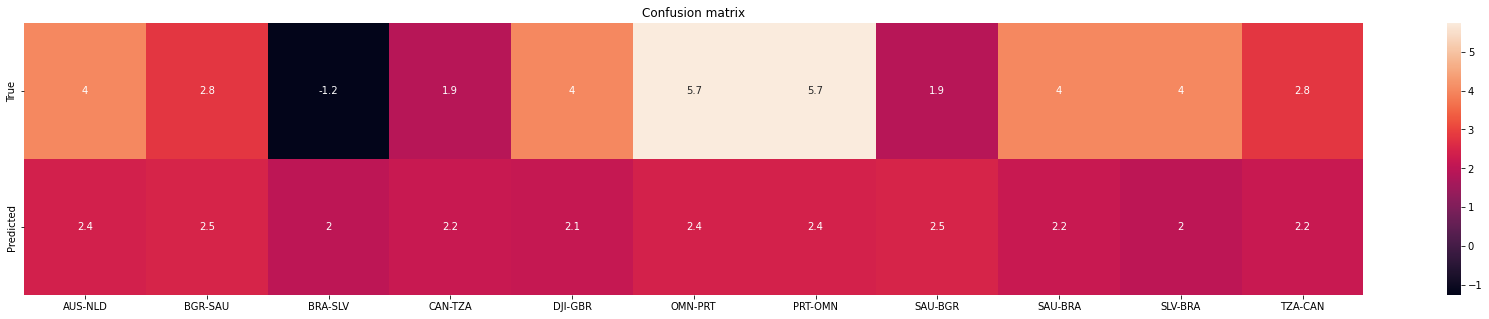

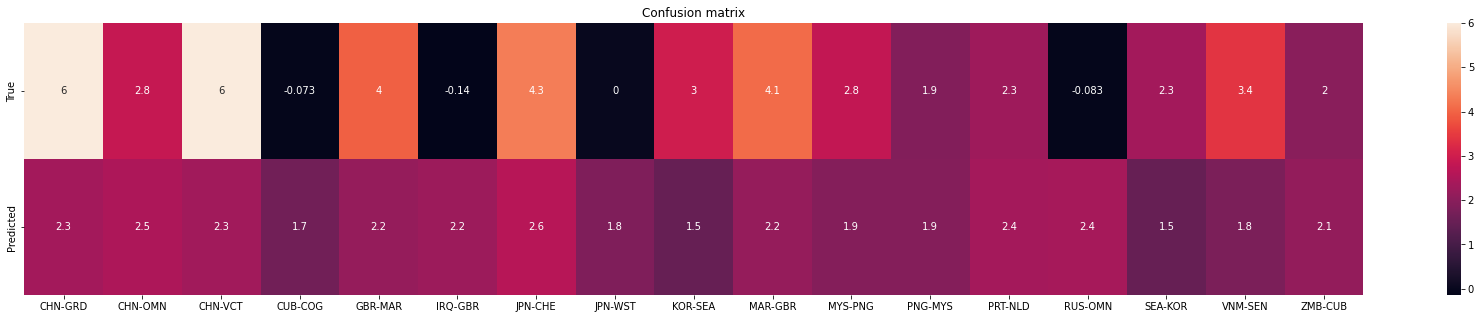

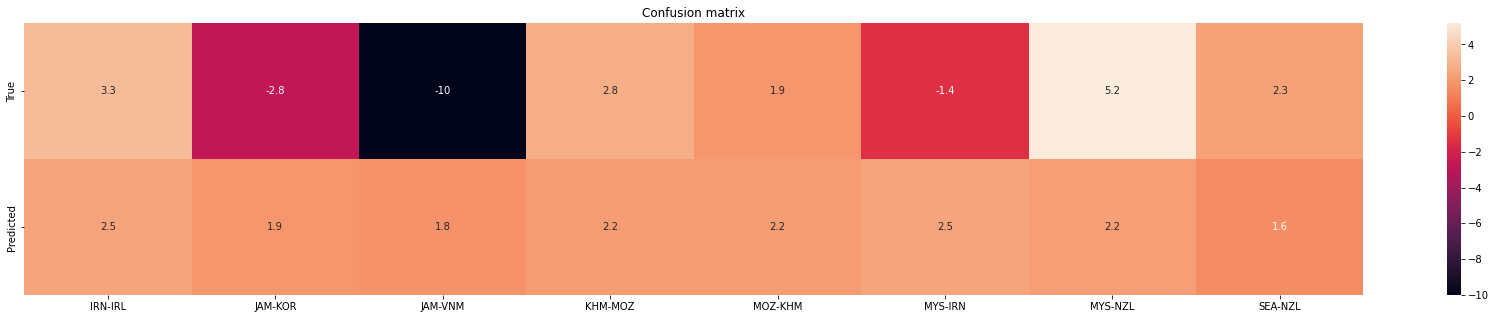

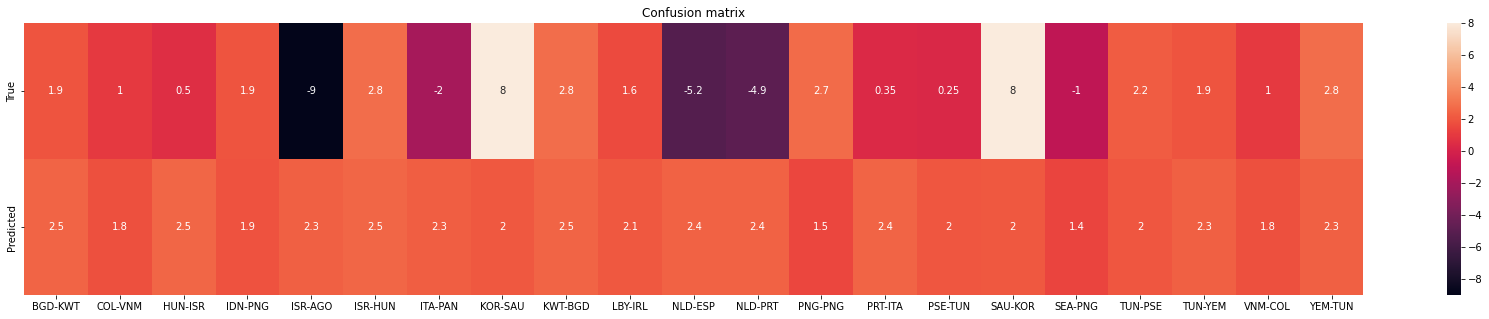

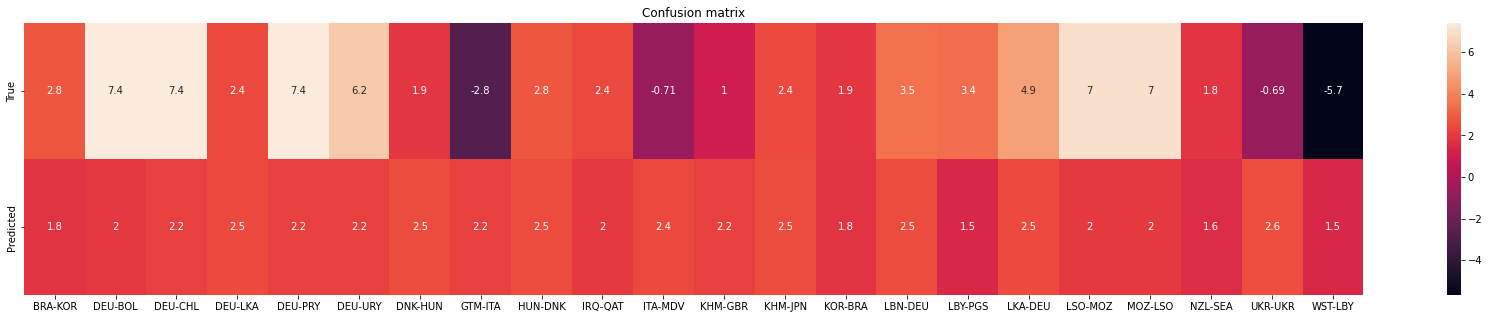

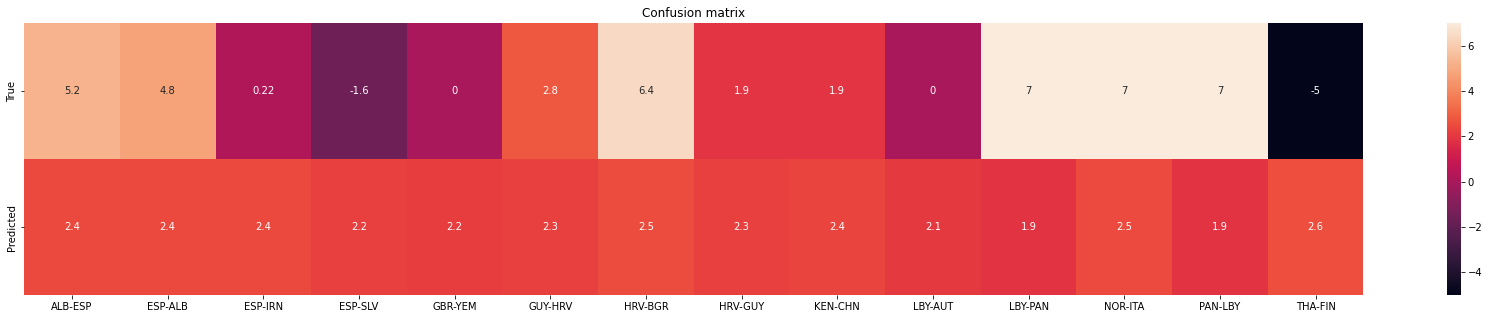

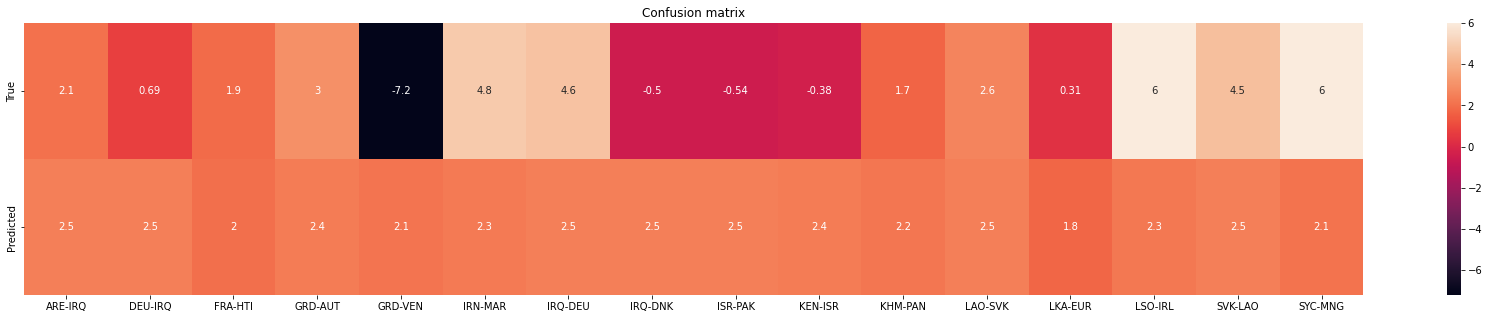

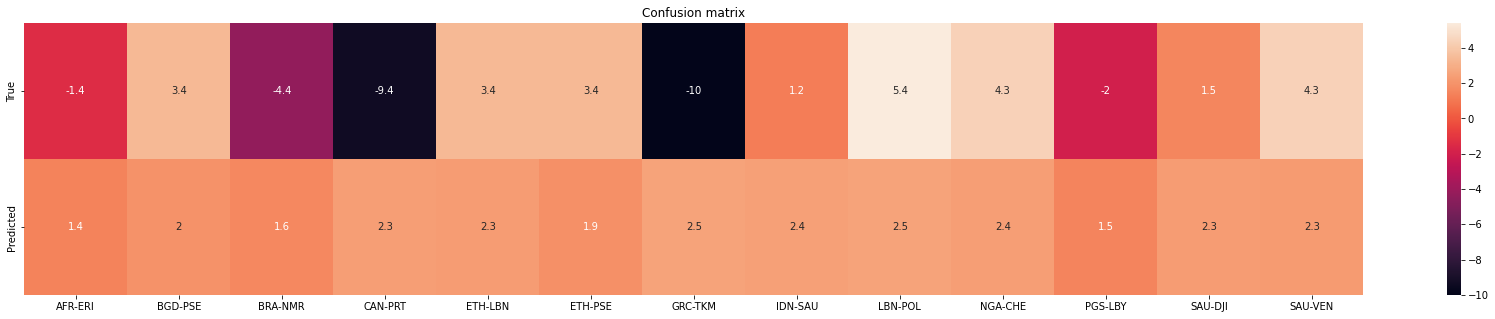

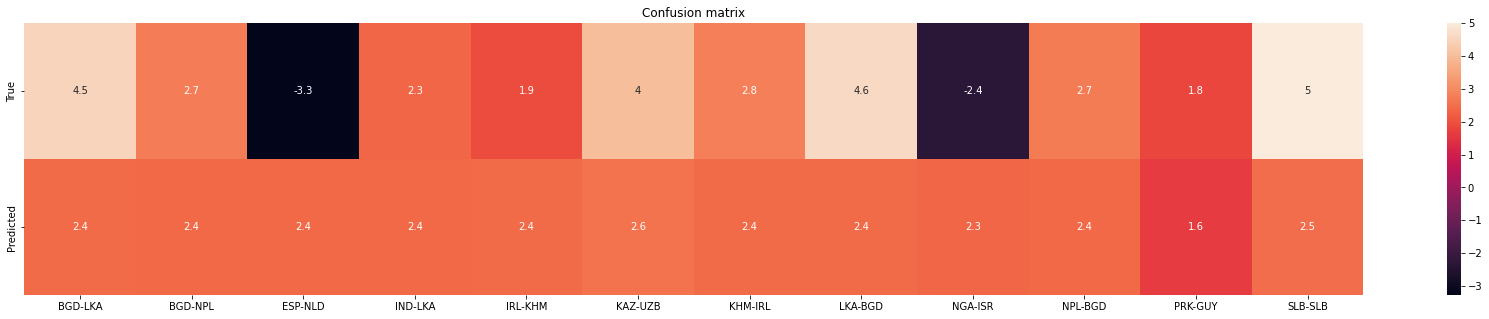

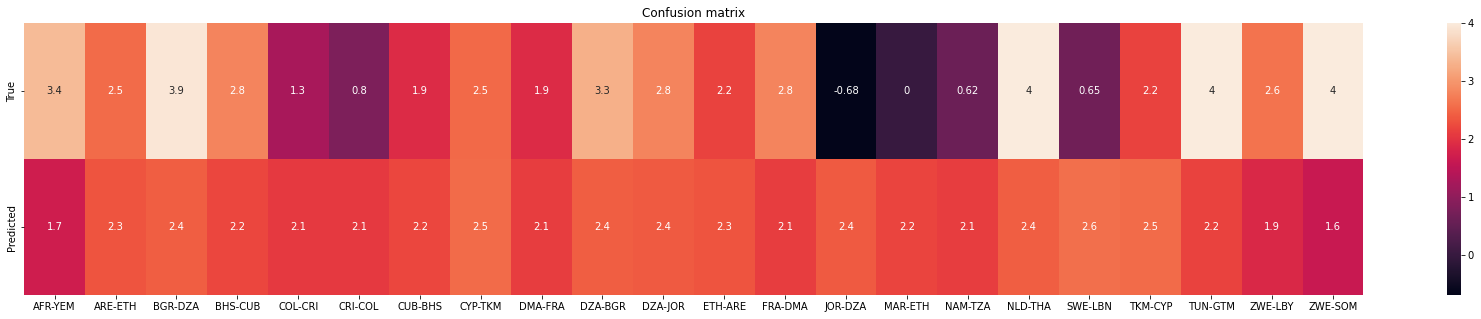

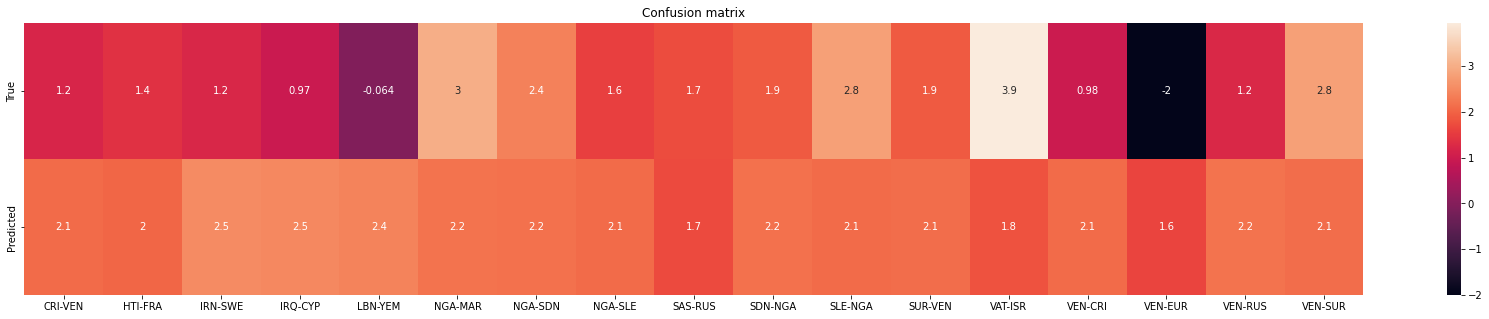

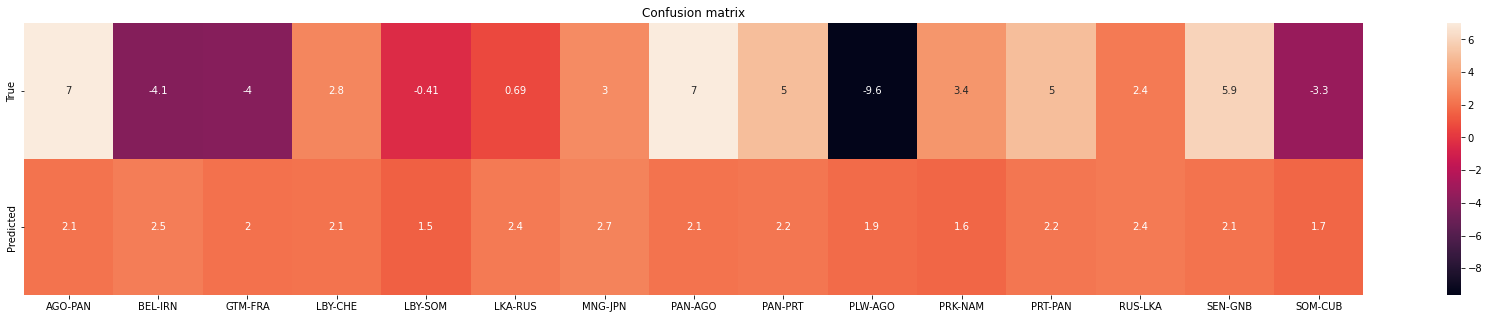

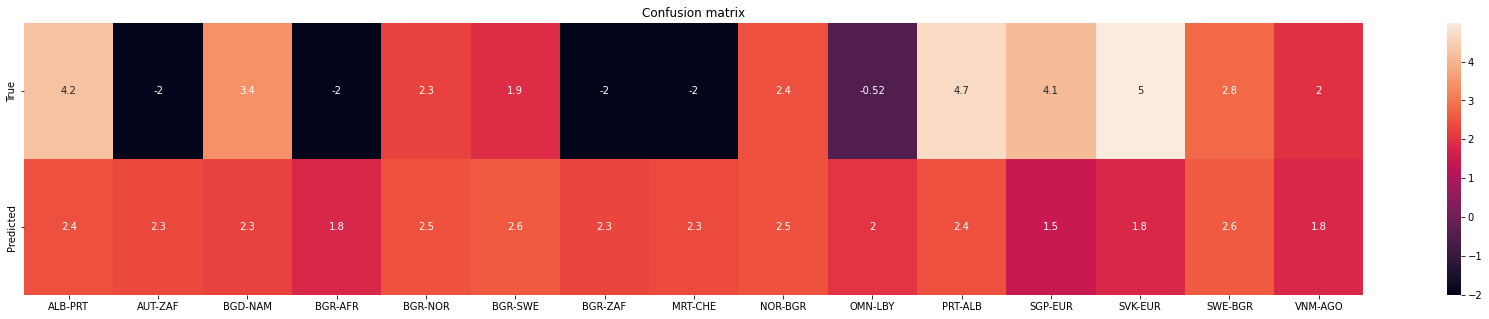

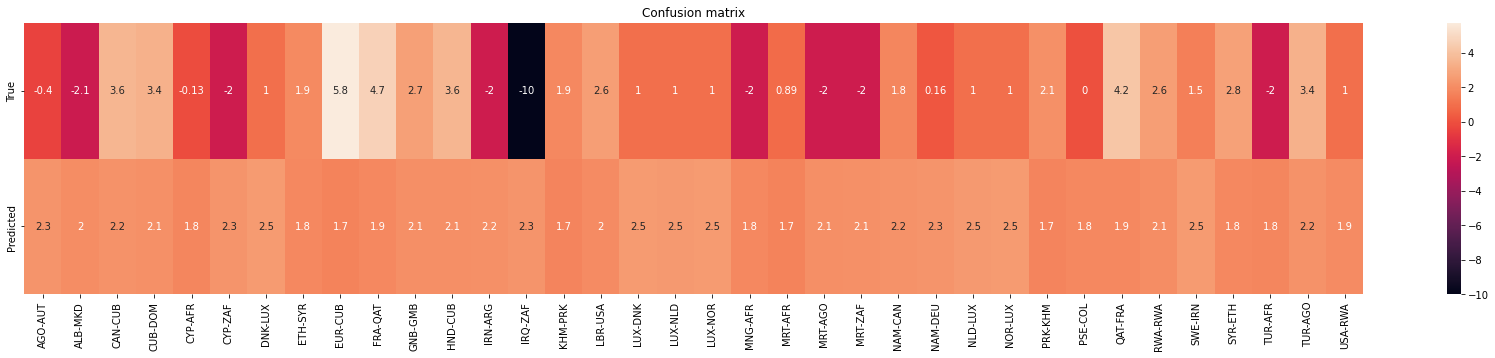

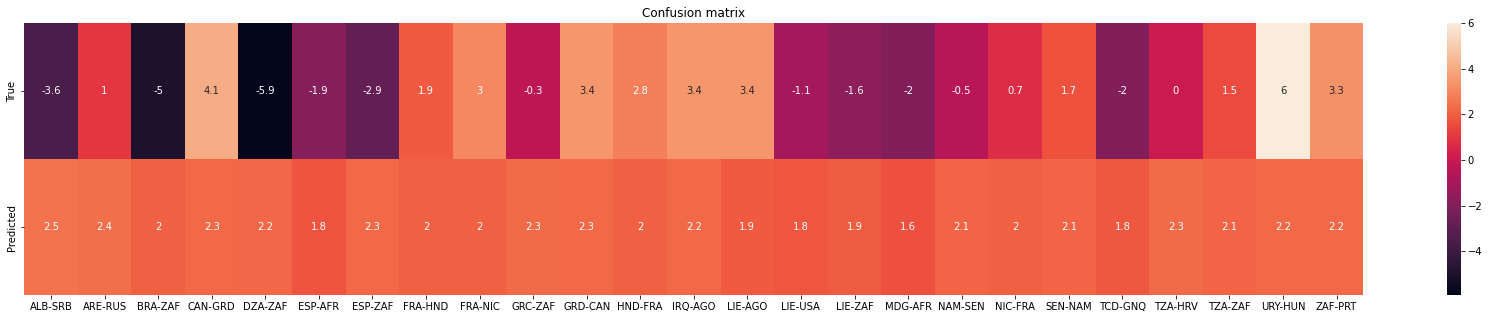

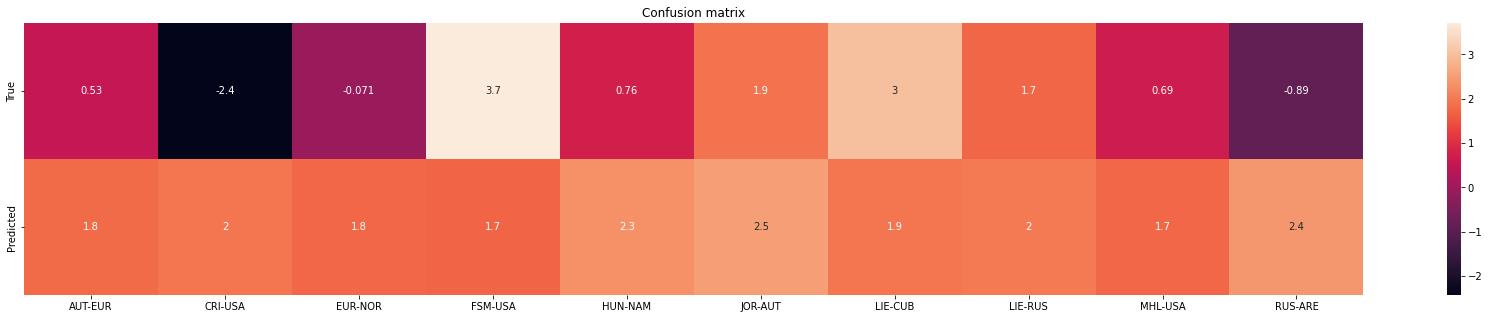

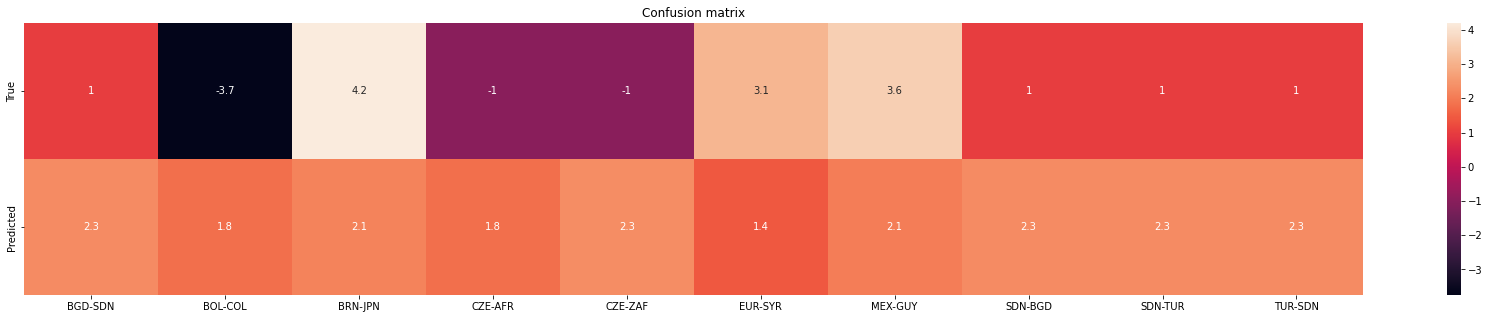

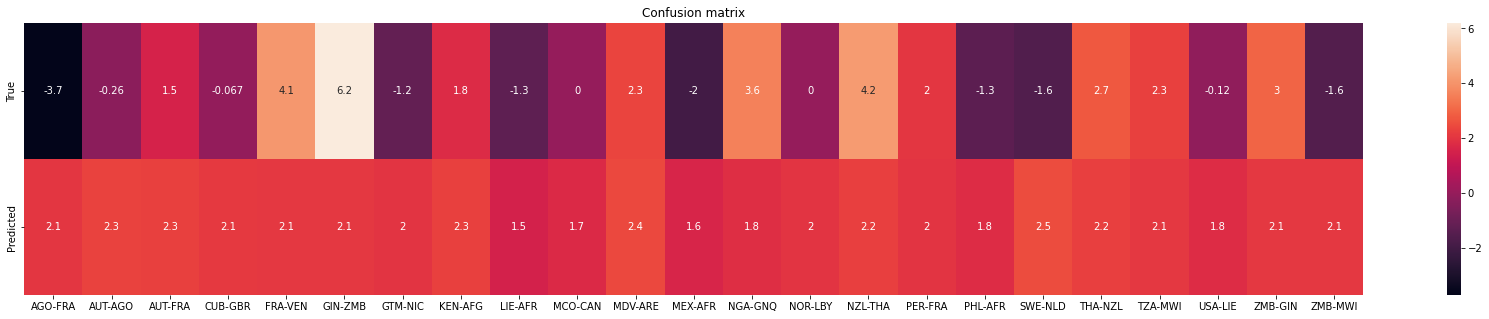

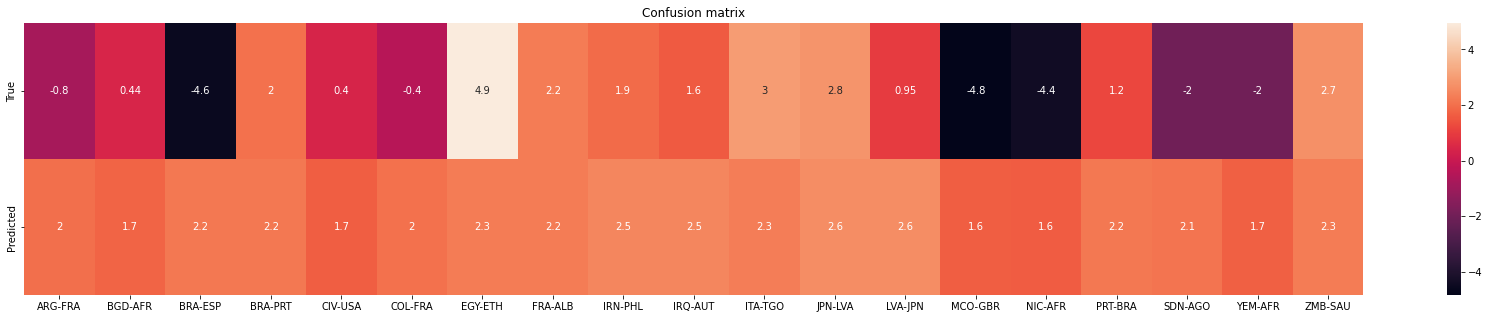

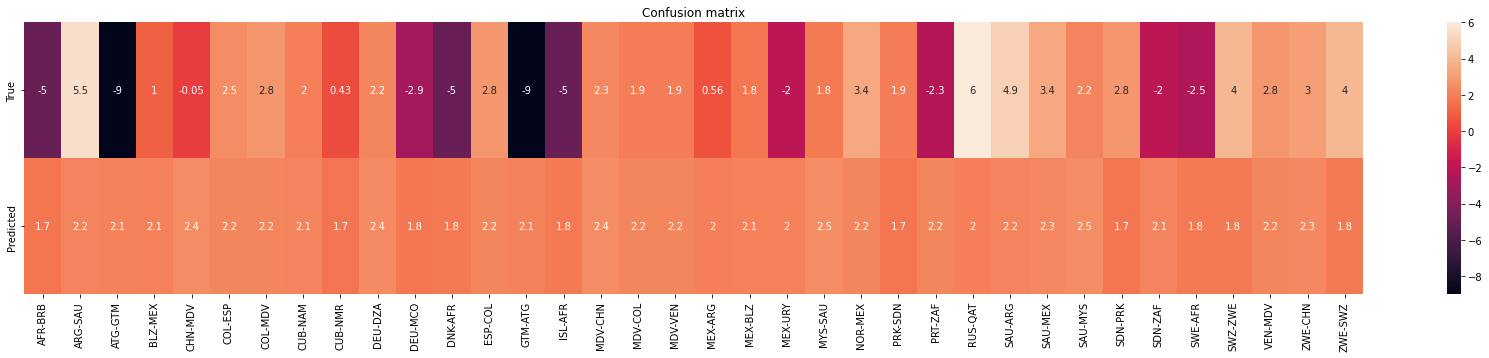

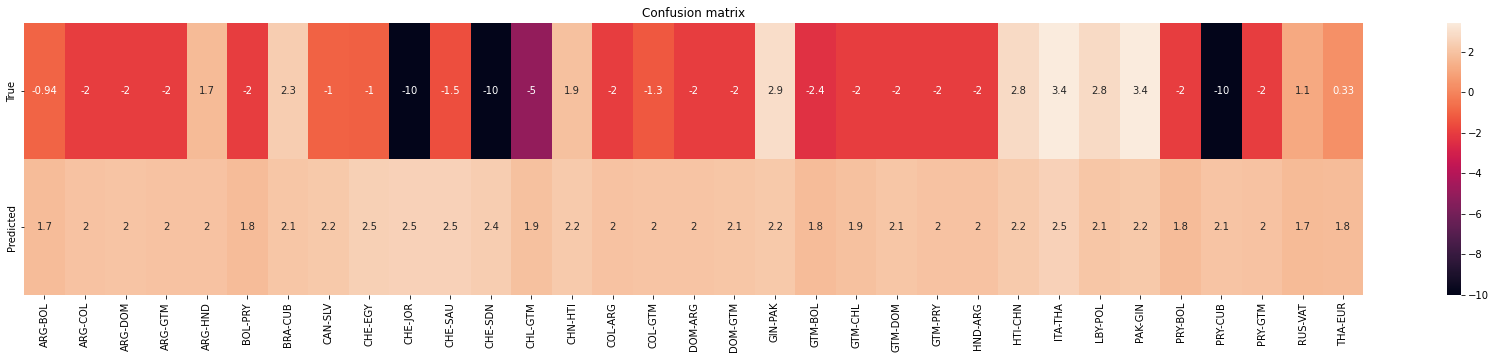

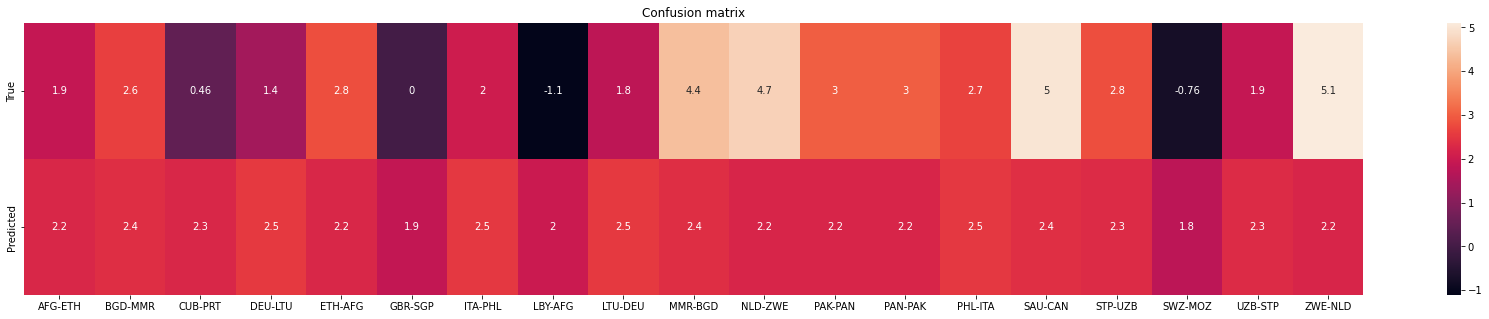

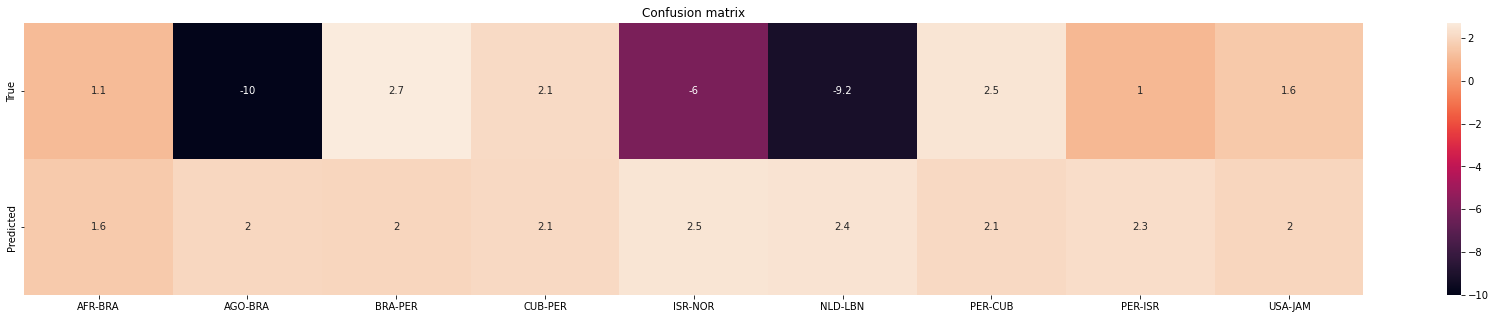

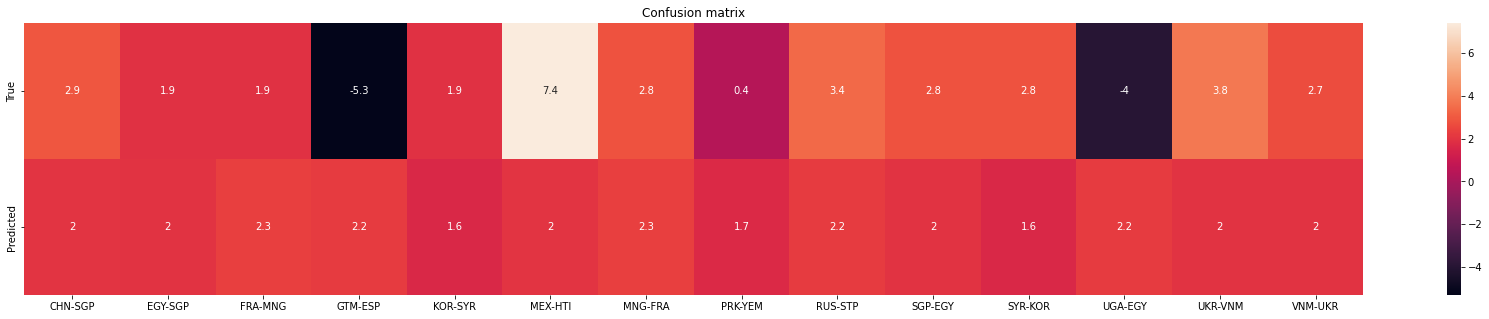

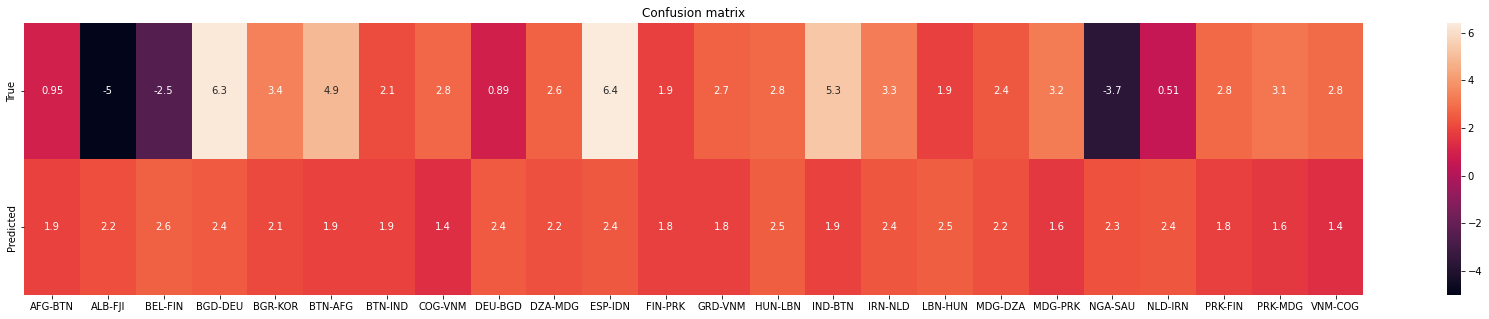

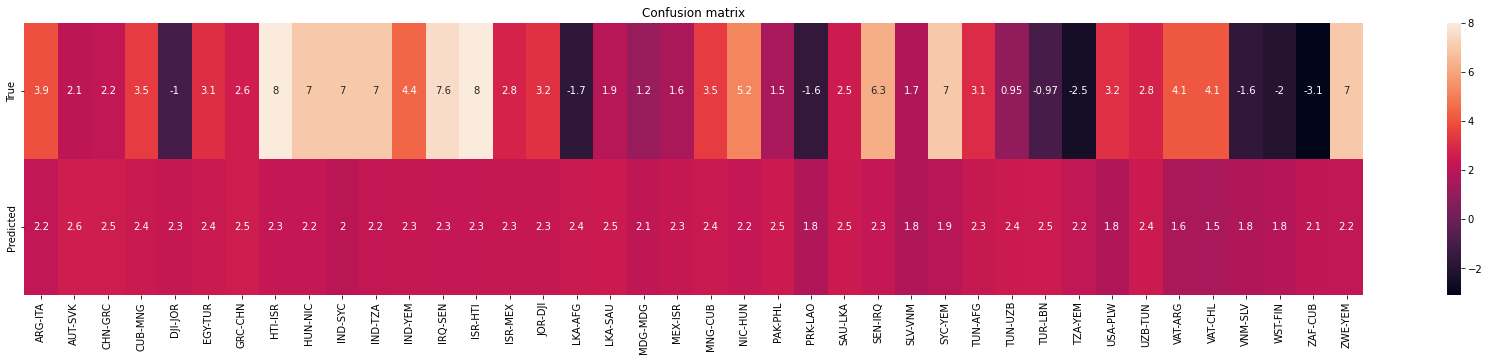

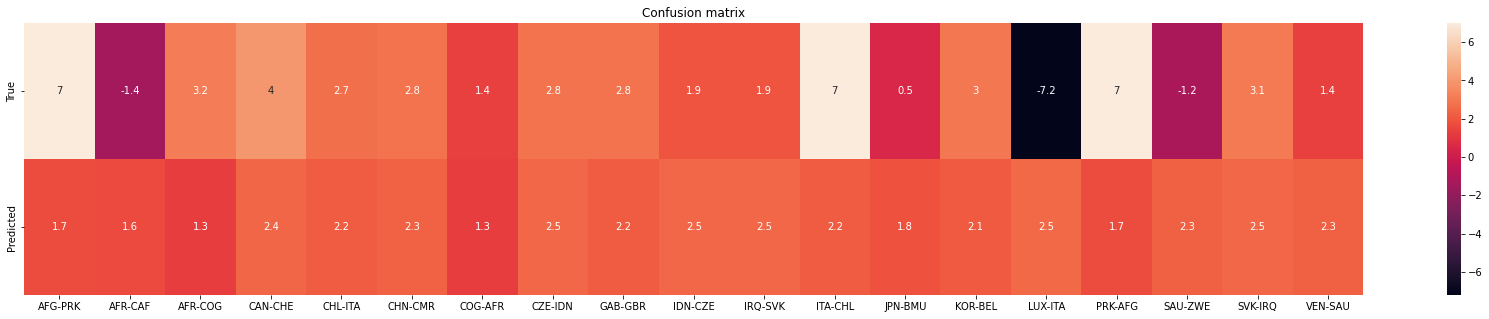

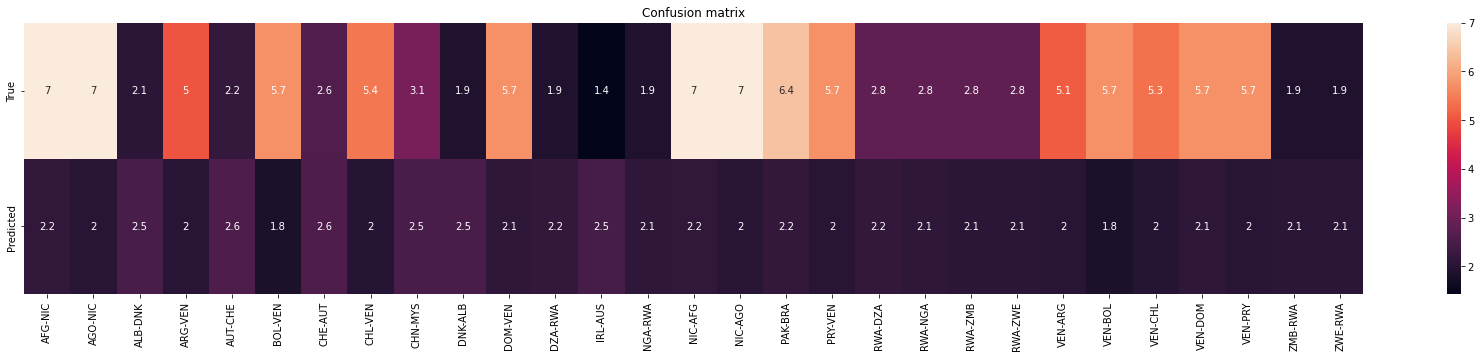

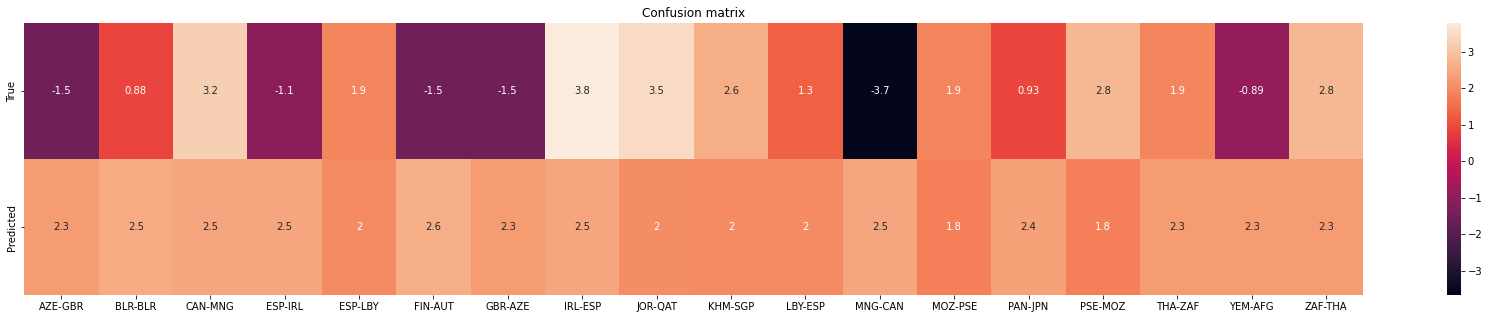

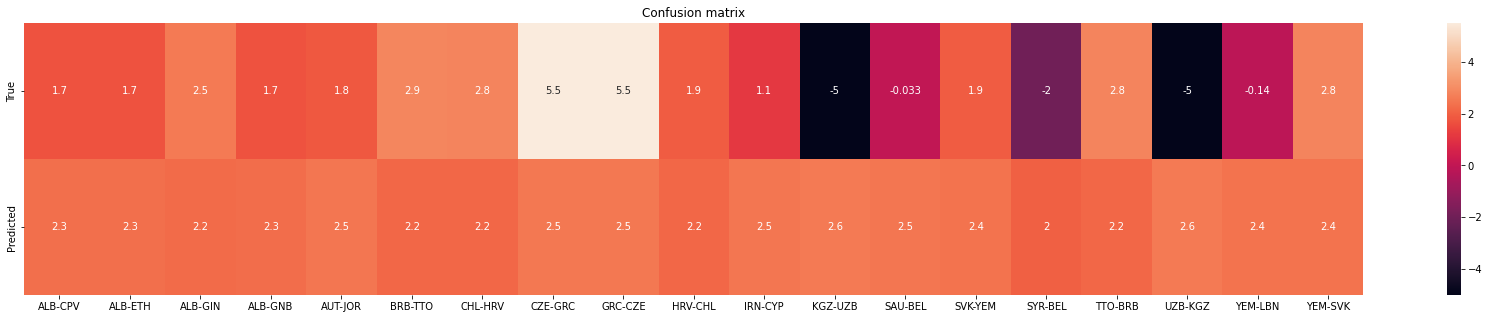

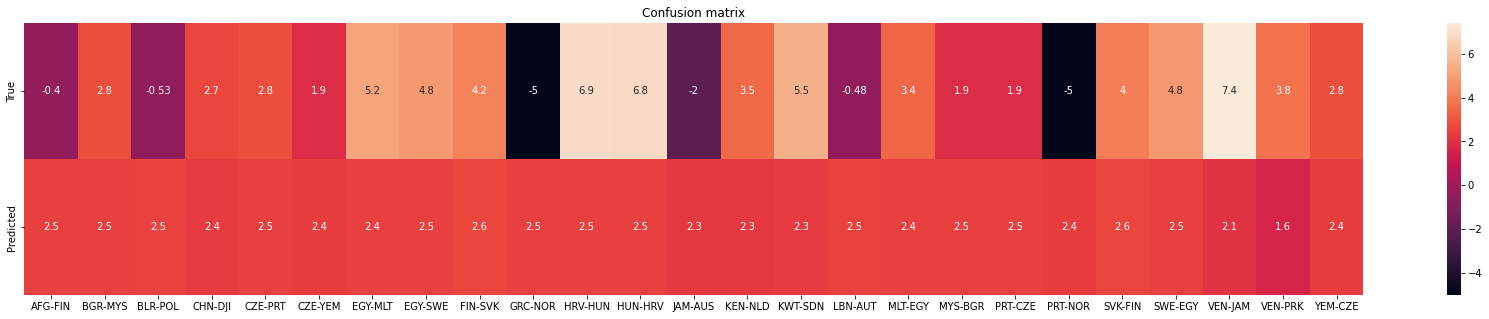

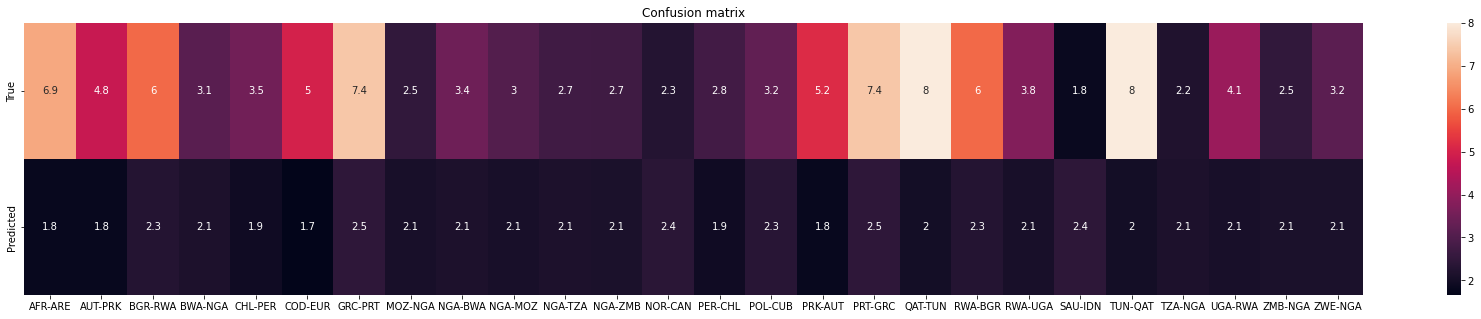

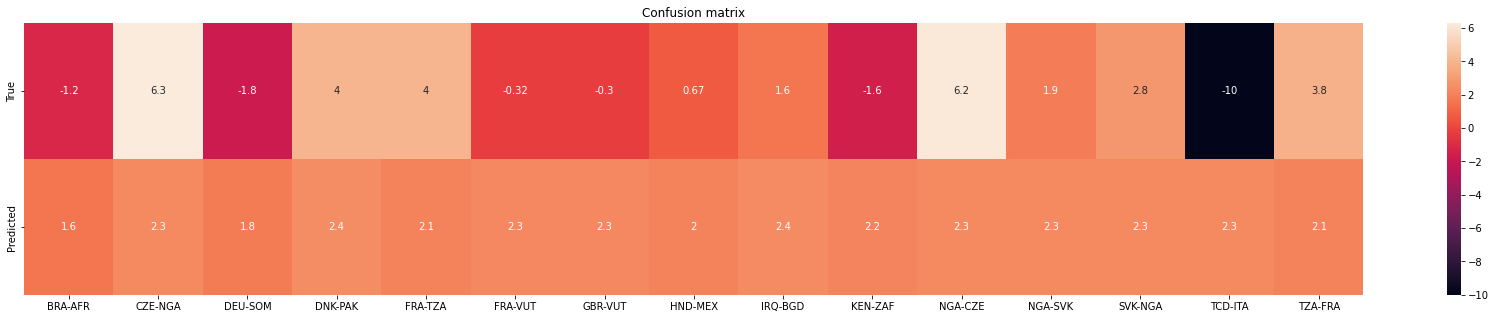

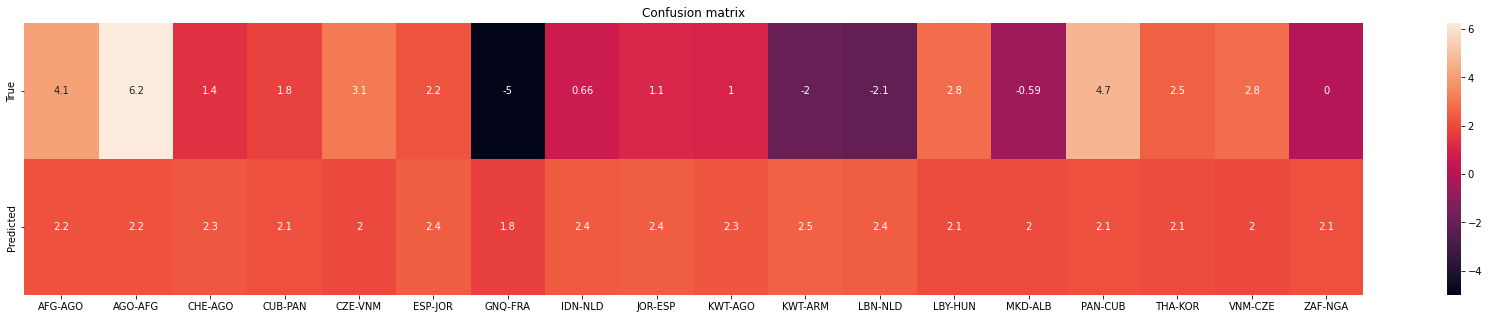

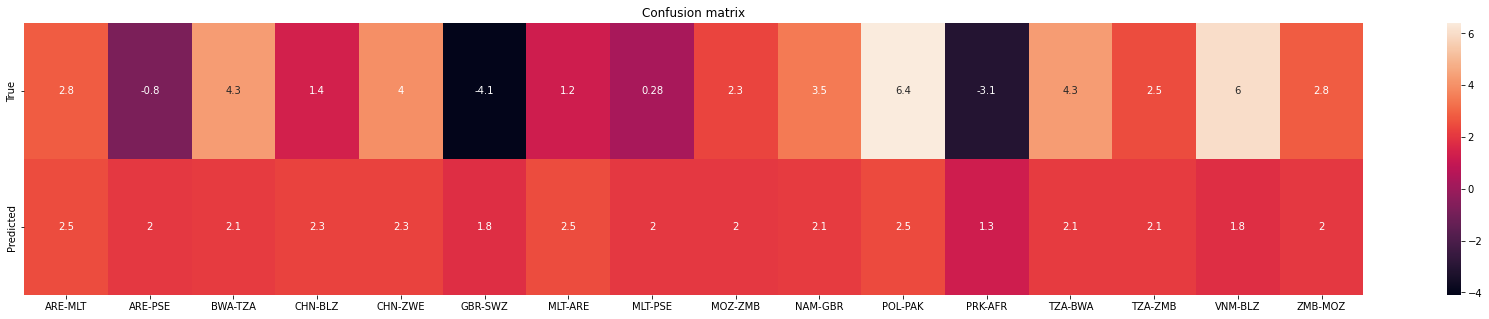

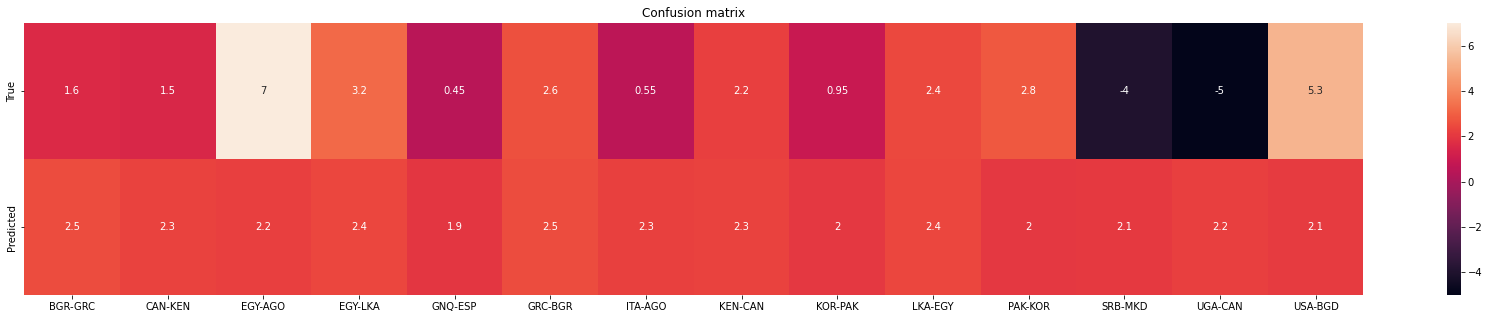

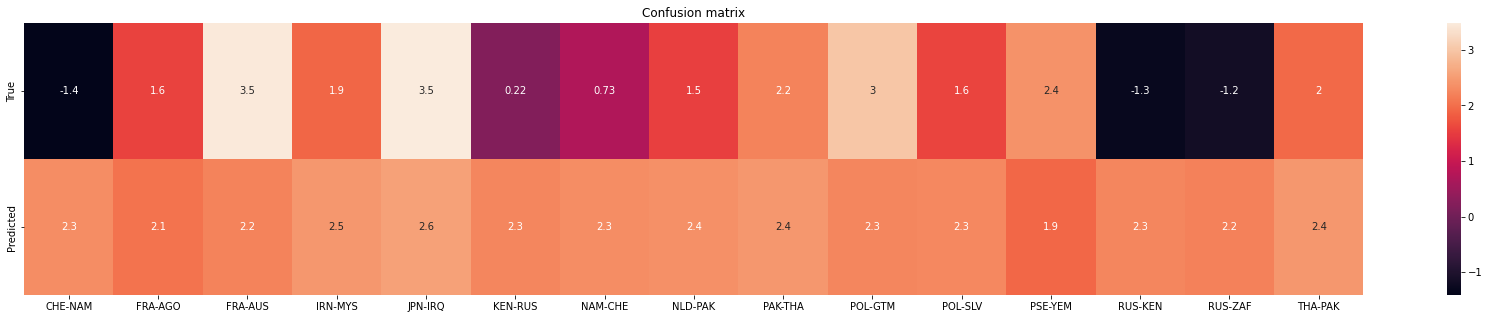

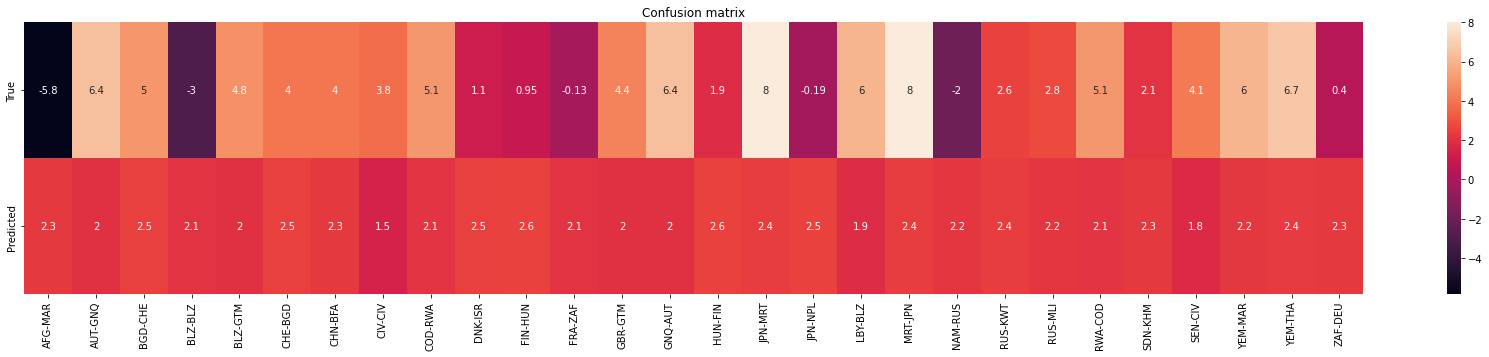

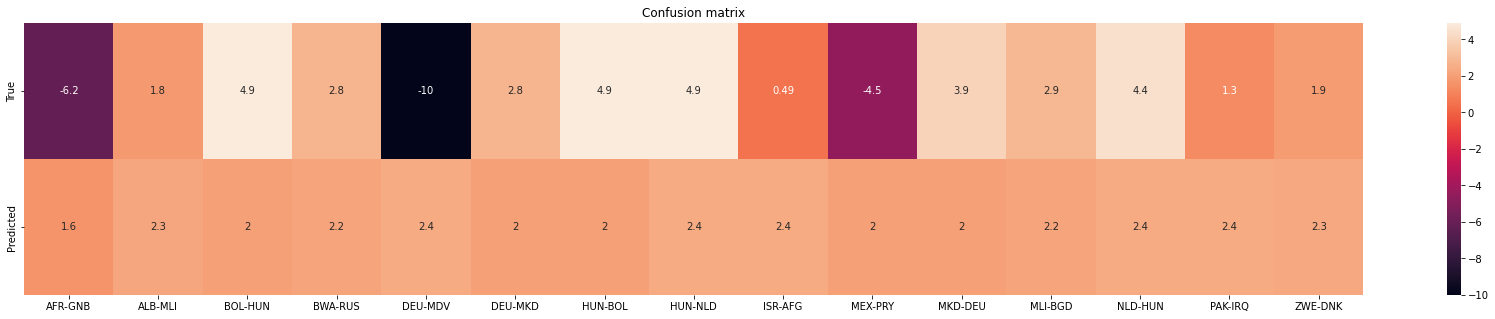

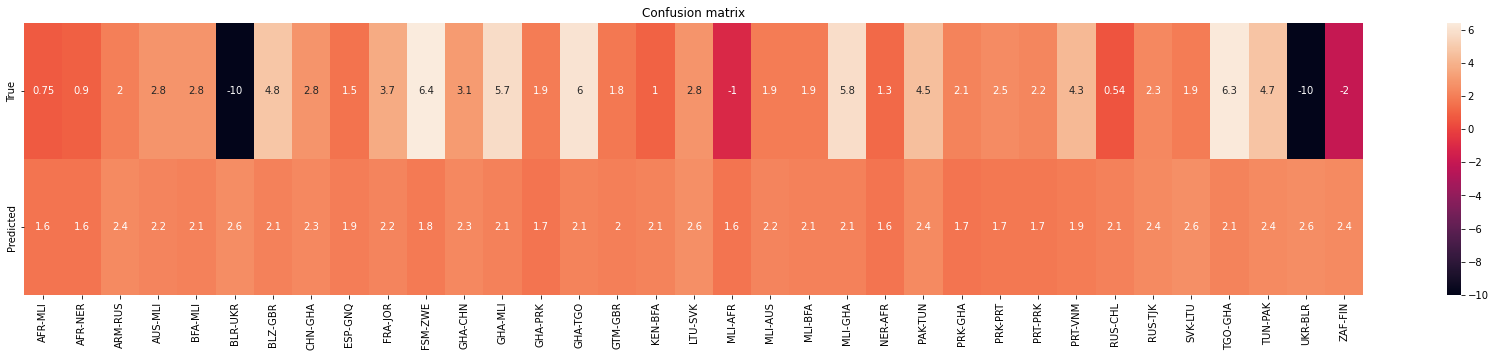

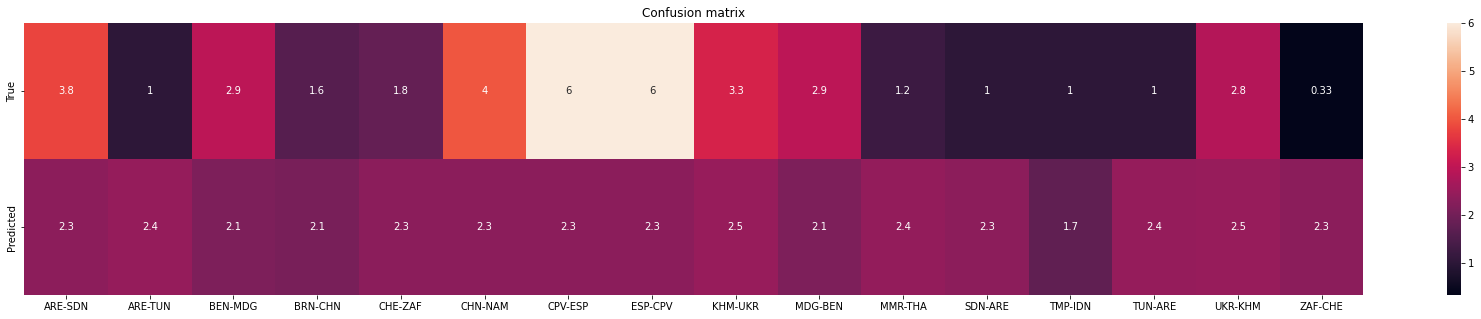

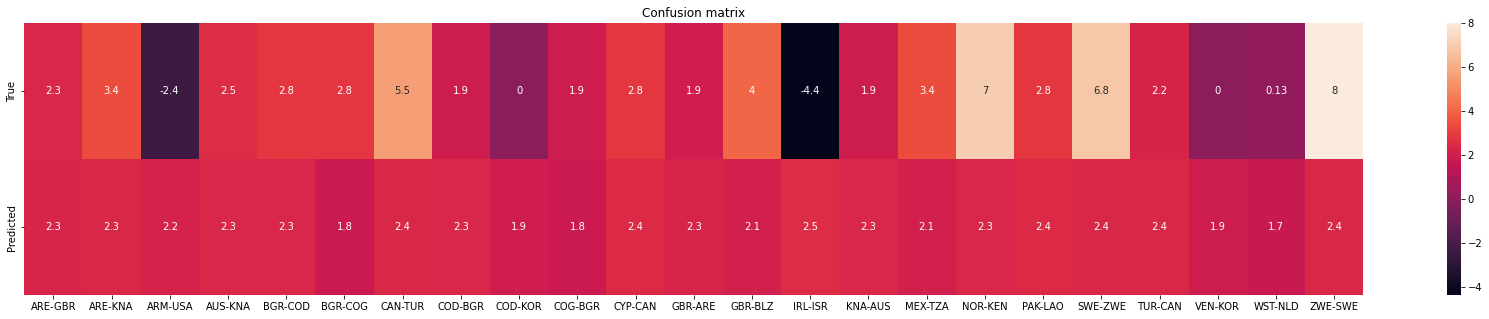

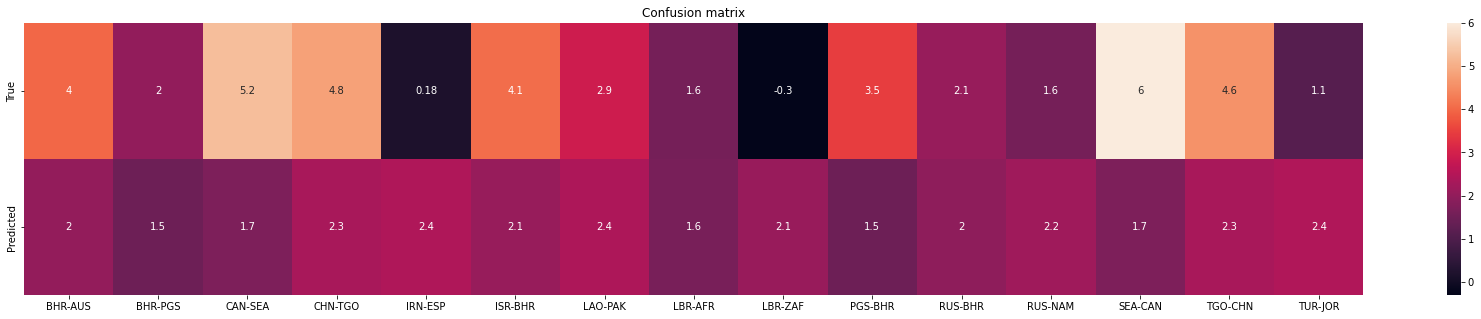

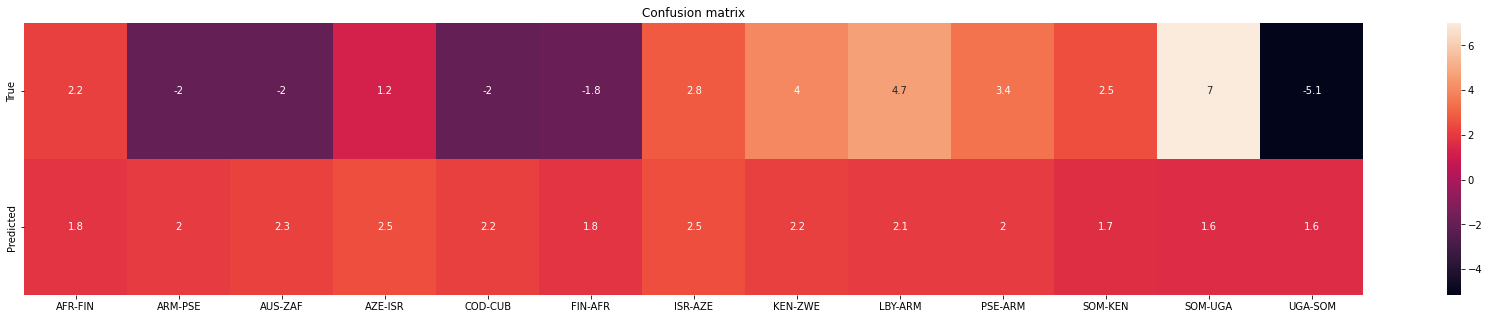

MSE: 10.8804


In [11]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    max_x = torch.add(torch.max(torch.nan_to_num(snapshot.x), 0).values, 1)
    X = torch.div(snapshot.x, max_x)
    #X = torch.clamp(X, 10e-5, 10e3)
    X = torch.nan_to_num(X)
    max_w = torch.add(torch.max(torch.nan_to_num(snapshot.edge_attr), 0).values, 1)
    W = torch.div(snapshot.edge_attr, max_w)
    #W = torch.clamp(W, 10e-5, 100)
    W = torch.nan_to_num(W)
    
    y_hat = model(X, snapshot.edge_index, W)
    y_hat = torch.sum(torch.mul(y_hat[snapshot.edge_index[0]], y_hat[snapshot.edge_index[1]]), 1)
    
    y_true = torch.diagonal(snapshot.y[snapshot.edge_index[0]][:, snapshot.edge_index[1]])
    
    plot_confusion_matrix(y_hat, y_true)
    cost = cost + torch.mean((y_hat-y_true)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

In [12]:
torch.save(model.state_dict(), '../../trained_models/GConvGRU.pt')